In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from multiprocessing import Pool, cpu_count
import time
import tqdm as tqdm
import pickle
import emcee
import corner
import arviz as az

from astropy.io import ascii, fits
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as cons
from astropy.visualization.wcsaxes import SphericalCircle

import scipy.integrate as integrate
from scipy.optimize import curve_fit, minimize
from scipy.special import beta
from scipy.interpolate import interp1d

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.3, Om0=0.27, Tcmb0=2.725)

In [3]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 20 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')
cm4 = plt.cm.get_cmap('Pastel2')
cm5 = plt.cm.get_cmap('Set3')
cm6 = plt.cm.get_cmap('gist_rainbow')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors2 = [cm2(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]
colors4 = [cm4(value) for value in color_values]
colors5 = [cm5(value) for value in color_values]
colors6 = [cm6(value) for value in color_values]

/tmp/ipykernel_1785304/1944463329.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm1 = plt.cm.get_cmap('jet')
/tmp/ipykernel_1785304/1944463329.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm2 = plt.cm.get_cmap('rainbow')
/tmp/ipykernel_1785304/1944463329.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm3 = plt.cm.get_cmap('gnuplot2')
/tmp/ipykernel_1785304/1944463329.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated i

/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:123: OptimizeWarning: Covariance of the parameters could not be estimated
  popt1, pcov1 = curve_fit(func1, mag, sigma_nmad)


[ 0.00142689 -0.04548921  0.36606062  1.        ]


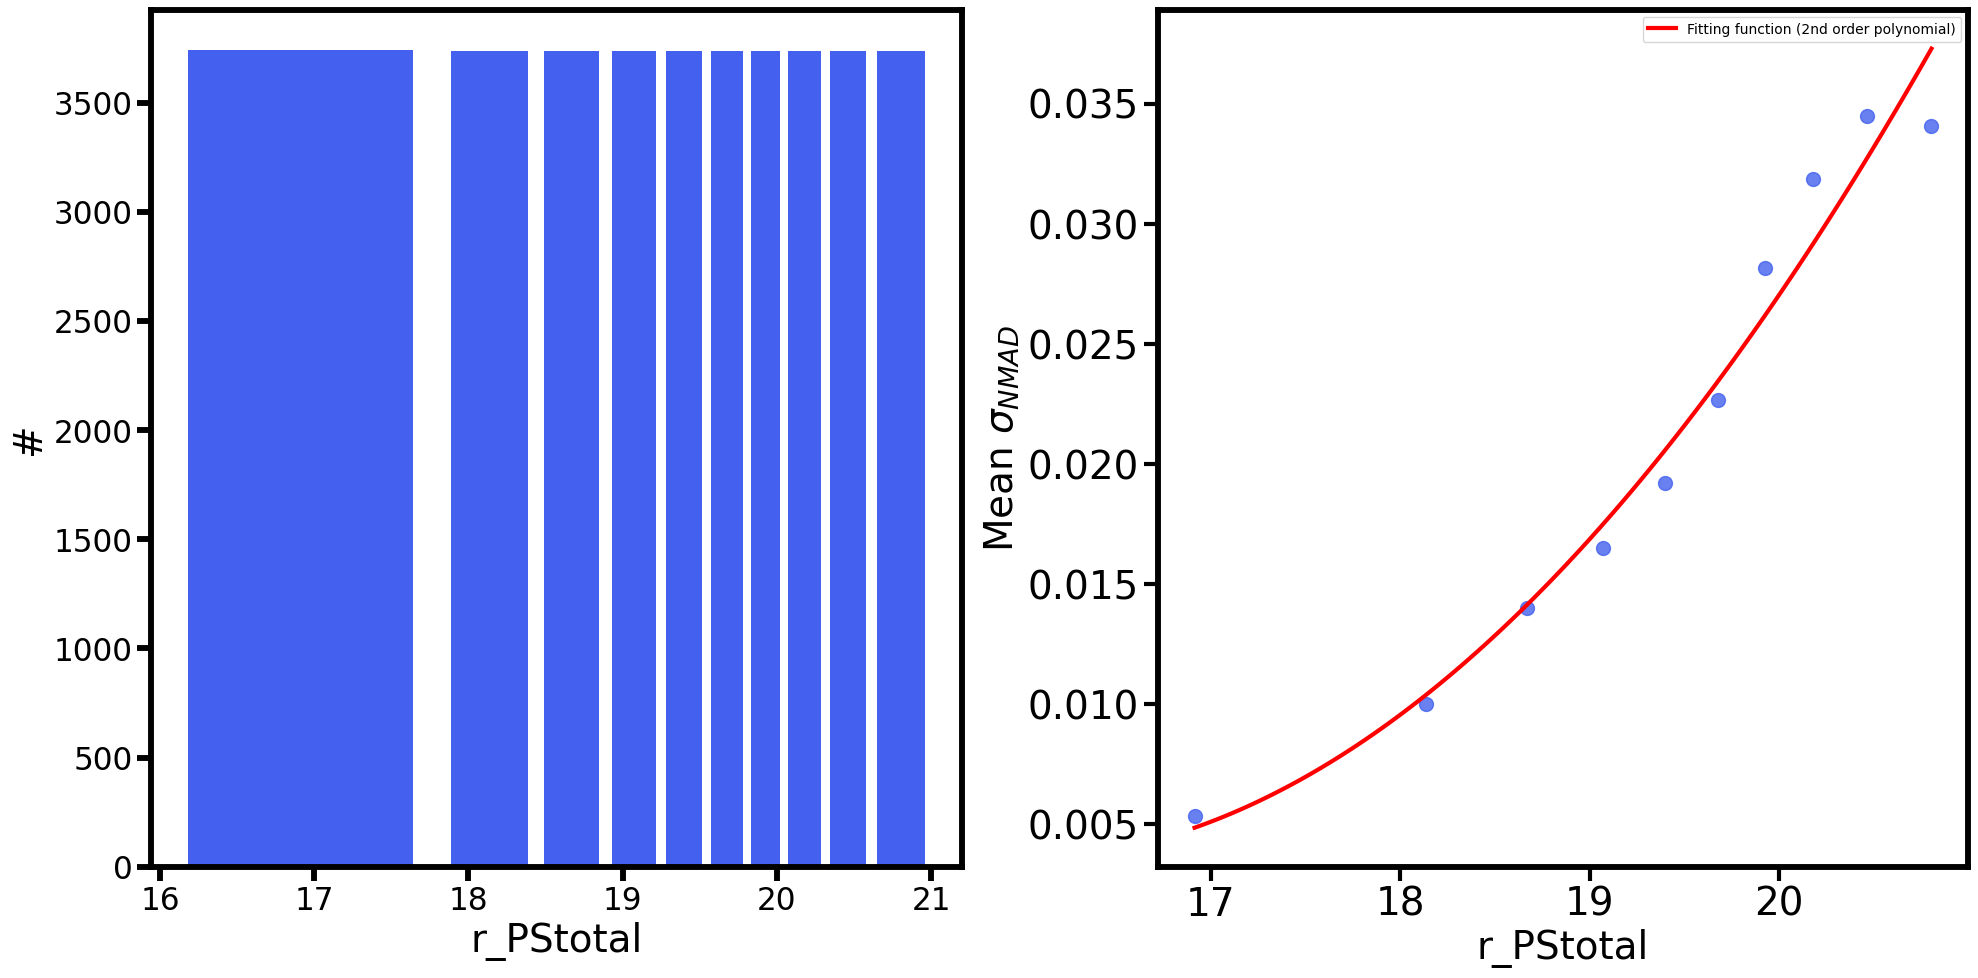

In [4]:
#Another way to do this would be to add an "__init__.py" to the folder '/work/Doc/galaxy-cluster-membership/' and import it as galaxy-cluster-membership.galaxy_cluster_membership I think
#See https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
# import sys
# sys.path.insert(1, '/work/Doc/galaxy-cluster-membership/')
from galaxy_cluster_membership import *

### Start from here

In [ ]:
#Load mock data
mock_PDF_attributes = pd.read_csv("mock_PDF_attributes.csv", 
                                usecols=['z_phot_pdfs_mock', 'weights_0_pdfs_mock', 'weights_1_pdfs_mock', 'weights_2_pdfs_mock', 
                                         'means_0_pdfs_mock', 'means_1_pdfs_mock', 'means_2_pdfs_mock', 'stds_0_pdfs_mock', 'stds_1_pdfs_mock', 
                                         'stds_2_pdfs_mock', 'rmag_clones', 'zspec_clones', 'gr_color_clones', 'num_of_clones'])

z_phot_pdfs_mock = np.array(mock_PDF_attributes['z_phot_pdfs_mock'])


hdul = fits.open("cluster-mocks/lightcone_zphot_subhalos_AllFrom1.fits")
scat = hdul[1].data

#Units:
#x, y, z: cMpc / h (comoving distances)
#ra, dec: degrees (you can verify that in the Pablo's mock README, and also by plotting the distribution of mock galaxies)

magr = scat["mag_r"]
magnitude_limit = 21

mask_good = (magr < magnitude_limit) & ~np.isnan(z_phot_pdfs_mock)

haloId = scat["haloId"][mask_good]
galaxyId = scat["galaxyId"][mask_good]
z_phot_original = scat["z_phot"][mask_good]
z_spec = scat["z_app"][mask_good]
ra = scat["RA"][mask_good]
dec = scat["DEC"][mask_good]
magr = scat["mag_r"][mask_good]
magu = scat["mag_u"][mask_good]
magg = scat["mag_g"][mask_good]
magi = scat["mag_i"][mask_good]
magz = scat["mag_z"][mask_good]
x = scat["pos_x"][mask_good] / cosmo.h #Mpc
y = scat["pos_y"][mask_good] / cosmo.h #Mpc
z = scat["pos_z"][mask_good] / cosmo.h #Mpc
vx = scat["vel_x"][mask_good]
vy = scat["vel_y"][mask_good]
vz = scat["vel_z"][mask_good]
firstHaloinFoFGroupId = scat["firstHaloinFoFGroupId"][mask_good]
g_r_color_mock = magg - magr


z_phot_pdfs_mock = np.array(mock_PDF_attributes['z_phot_pdfs_mock'])[mask_good]
weights_0_pdfs_mock = np.array(mock_PDF_attributes['weights_0_pdfs_mock'])[mask_good]
weights_1_pdfs_mock = np.array(mock_PDF_attributes['weights_1_pdfs_mock'])[mask_good]
weights_2_pdfs_mock = np.array(mock_PDF_attributes['weights_2_pdfs_mock'])[mask_good]
means_0_pdfs_mock = np.array(mock_PDF_attributes['means_0_pdfs_mock'])[mask_good]
means_1_pdfs_mock = np.array(mock_PDF_attributes['means_1_pdfs_mock'])[mask_good]
means_2_pdfs_mock = np.array(mock_PDF_attributes['means_2_pdfs_mock'])[mask_good]
stds_0_pdfs_mock = np.array(mock_PDF_attributes['stds_0_pdfs_mock'])[mask_good]
stds_1_pdfs_mock = np.array(mock_PDF_attributes['stds_1_pdfs_mock'])[mask_good]
stds_2_pdfs_mock = np.array(mock_PDF_attributes['stds_2_pdfs_mock'])[mask_good]
rmag_clones = np.array(mock_PDF_attributes['rmag_clones'])[mask_good]
zspec_clones = np.array(mock_PDF_attributes['zspec_clones'])[mask_good]
gr_color_clones = np.array(mock_PDF_attributes['gr_color_clones'])[mask_good]
num_of_clones = np.array(mock_PDF_attributes['num_of_clones'])[mask_good]

weights_pdfs_mock = np.vstack((weights_0_pdfs_mock, weights_1_pdfs_mock, weights_2_pdfs_mock))
means_pdfs_mock = np.vstack((means_0_pdfs_mock, means_1_pdfs_mock, means_2_pdfs_mock))
stds_pdfs_mock = np.vstack((stds_0_pdfs_mock, stds_1_pdfs_mock, stds_2_pdfs_mock))

### Dealing with the photo-zs of the mock

In [19]:
training_set_pdfs = pd.read_csv("testing_dataset_photoz_pdfs_desi.csv", 
                   usecols=['z', 'g_PStotal', 'r_PStotal', 'zml',
                           'pdf_weights_0', 'pdf_weights_1', 'pdf_weights_2', 'pdf_means_0', 'pdf_means_1', 
                           'pdf_means_2', 'pdf_stds_0', 'pdf_stds_1', 'pdf_stds_2']) 

r_PStotal_pdfs = training_set_pdfs['r_PStotal']

#Imposing a magnitude range similar to that for the mock galaxies
training_set_pdfs = training_set_pdfs[~np.isnan(r_PStotal_pdfs) & (r_PStotal_pdfs < magnitude_limit)]

z_pdfs = np.array(training_set_pdfs['z'])
z_phot_pdfs = np.array(training_set_pdfs['zml'])
g_PStotal_pdfs = np.array(training_set_pdfs['g_PStotal'])
r_PStotal_pdfs = np.array(training_set_pdfs['r_PStotal'])
weights_0_pdfs = np.array(training_set_pdfs['pdf_weights_0'])
weights_1_pdfs = np.array(training_set_pdfs['pdf_weights_1'])
weights_2_pdfs = np.array(training_set_pdfs['pdf_weights_2'])
means_0_pdfs = np.array(training_set_pdfs['pdf_means_0'])
means_1_pdfs = np.array(training_set_pdfs['pdf_means_1'])
means_2_pdfs = np.array(training_set_pdfs['pdf_means_2'])
stds_0_pdfs = np.array(training_set_pdfs['pdf_stds_0'])
stds_1_pdfs = np.array(training_set_pdfs['pdf_stds_1'])
stds_2_pdfs = np.array(training_set_pdfs['pdf_stds_2'])

g_r_color_pdfs = g_PStotal_pdfs - r_PStotal_pdfs

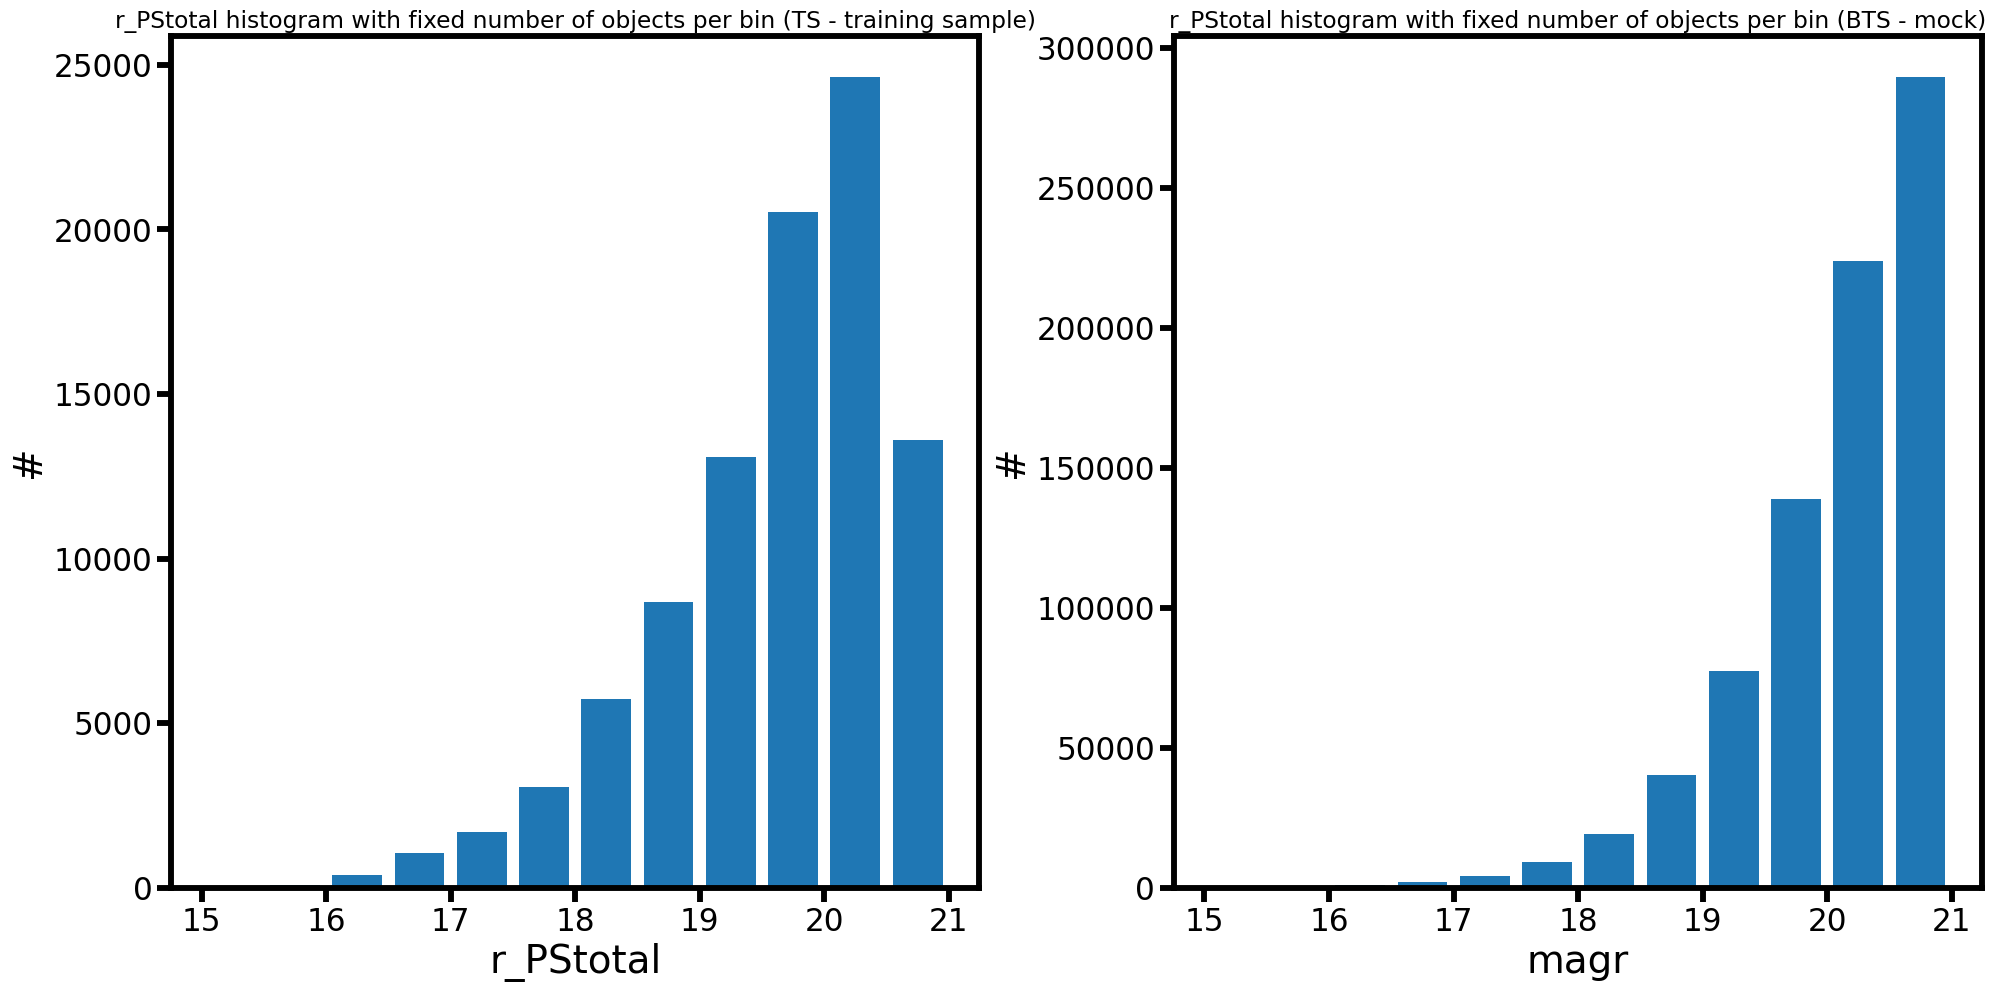

In [26]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

dm = 0.5
mag_bins = np.arange(15, 21+dm, dm)
num_bins = len(mag_bins) - 1

# n_TS, bins_TS, _ = ax1.hist(r_PStotal_pdfs, histedges_equalN(r_PStotal_pdfs, num_bins), histtype='bar', rwidth=0.8)
n_TS, bins_TS, _ = ax1.hist(r_PStotal_pdfs, mag_bins, histtype='bar', rwidth=0.8)
ax1.set_xlabel("r_PStotal", fontsize=fontsize)
ax1.set_ylabel("#", fontsize=fontsize)
ax1.set_title("r_PStotal histogram with fixed number of objects per bin (TS - training sample)", fontsize=fontsize*0.6)

# n_BTS, bins_BTS, _ = ax2.hist(magr, histedges_equalN(magr, num_bins), histtype='bar', rwidth=0.8)
n_BTS, bins_BTS, _ = ax2.hist(magr, mag_bins, histtype='bar', rwidth=0.8)
ax2.set_xlabel("magr", fontsize=fontsize)
ax2.set_ylabel("#", fontsize=fontsize)
ax2.set_title("r_PStotal histogram with fixed number of objects per bin (BTS - mock)", fontsize=fontsize*0.6)

fig.tight_layout(pad=1.0)

In [27]:
#We will have to associate one photo-z PDF property for each galaxy in the mock. 
# First, we create arrays to store these properties for each mock galaxy
z_phot_pdfs_mock = np.zeros_like(haloId)
weights_0_pdfs_mock = np.zeros_like(haloId)
weights_1_pdfs_mock = np.zeros_like(haloId)
weights_2_pdfs_mock = np.zeros_like(haloId)
means_0_pdfs_mock = np.zeros_like(haloId)
means_1_pdfs_mock = np.zeros_like(haloId)
means_2_pdfs_mock = np.zeros_like(haloId)
stds_0_pdfs_mock = np.zeros_like(haloId)
stds_1_pdfs_mock = np.zeros_like(haloId)
stds_2_pdfs_mock = np.zeros_like(haloId)

rmag_clones = np.zeros_like(haloId)
zspec_clones = np.zeros_like(haloId)
gr_color_clones = np.zeros_like(haloId)
num_of_clones = np.zeros_like(haloId)

#Let's define dz, a range of spectroscopic redshifts inside of which we will search for clones, and a dm, a range for the magnitudes
# dz=0.005 is a typical value for delta_z of a cluster at redshift z=0.3
dz = 0.001
dm = 0.5

for i in range(len(haloId)):

    magr_i = magr[i]
    zspec_i = z_spec[i]
    gr_color_i = g_r_color_mock[i]

    #Determine to what magnitude bin this galaxy belongs to.
    magr_upper = magr_i + dm
    magr_lower = magr_i - dm

    #Determine also a redshift range
    z_upper = zspec_i + dz
    z_lower = zspec_i - dz

    #Create a mask to select galaxies in the training set that are inside this range of z_spec and magr
    mask_TS = (r_PStotal_pdfs >= magr_lower) & (r_PStotal_pdfs <= magr_upper) & (z_pdfs <= z_upper) & (z_pdfs >= z_lower)
    
    #Among the galaxies in the training set beloging to the (r, z_spec) bin, we look for the one with the most similar color
    if np.sum(mask_TS) > 0:
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(np.array([g_r_color_pdfs[mask_TS]]).T)
        d, index = nbrs.kneighbors(np.array([[gr_color_i]]).T)
        index = index[0][0]

        #Finally, associate the photo-z PDFs properties of the clones to the respective mock galaxy
        z_phot_pdfs_mock[i] = z_phot_pdfs[mask_TS][index]
        weights_0_pdfs_mock[i] = weights_0_pdfs[mask_TS][index]
        weights_1_pdfs_mock[i] = weights_1_pdfs[mask_TS][index]
        weights_2_pdfs_mock[i] = weights_2_pdfs[mask_TS][index]
        means_0_pdfs_mock[i] = means_0_pdfs[mask_TS][index]
        means_1_pdfs_mock[i] = means_1_pdfs[mask_TS][index]
        means_2_pdfs_mock[i] = means_2_pdfs[mask_TS][index]
        stds_0_pdfs_mock[i] = stds_0_pdfs[mask_TS][index]
        stds_1_pdfs_mock[i] = stds_1_pdfs[mask_TS][index]
        stds_2_pdfs_mock[i] = stds_2_pdfs[mask_TS][index]

        rmag_clones[i] = r_PStotal_pdfs[mask_TS][index]
        zspec_clones[i] = z_pdfs[mask_TS][index]
        gr_color_clones[i] = g_r_color_pdfs[mask_TS][index]
        num_of_clones[i] = np.sum(mask_TS)

    #If there is no clone, we assign a NaN to the PDF properties.
    if np.sum(mask_TS) == 0:
        z_phot_pdfs_mock[i] = np.nan
        weights_0_pdfs_mock[i] = np.nan
        weights_1_pdfs_mock[i] = np.nan
        weights_2_pdfs_mock[i] = np.nan
        means_0_pdfs_mock[i] = np.nan
        means_1_pdfs_mock[i] = np.nan
        means_2_pdfs_mock[i] = np.nan
        stds_0_pdfs_mock[i] = np.nan
        stds_1_pdfs_mock[i] = np.nan
        stds_2_pdfs_mock[i] = np.nan

        rmag_clones[i] = np.nan
        zspec_clones[i] = np.nan
        gr_color_clones[i] = np.nan
        num_of_clones[i] = np.nan

In [28]:
# Create a DataFrame
df = pd.DataFrame({
    "z_phot_pdfs_mock": z_phot_pdfs_mock,
    "weights_0_pdfs_mock": weights_0_pdfs_mock,
    "weights_1_pdfs_mock": weights_1_pdfs_mock,
    "weights_2_pdfs_mock": weights_2_pdfs_mock,
    "means_0_pdfs_mock": means_0_pdfs_mock,
    "means_1_pdfs_mock": means_1_pdfs_mock,
    "means_2_pdfs_mock": means_2_pdfs_mock,
    "stds_0_pdfs_mock": stds_0_pdfs_mock,
    "stds_1_pdfs_mock": stds_1_pdfs_mock,
    "stds_2_pdfs_mock": stds_2_pdfs_mock,
    "rmag_clones": rmag_clones,
    "zspec_clones": zspec_clones,
    "gr_color_clones": gr_color_clones,
    "num_of_clones": num_of_clones
})

# Save to CSV
df.to_csv("mock_PDF_attributes.csv", index=False)  # Omit row indices

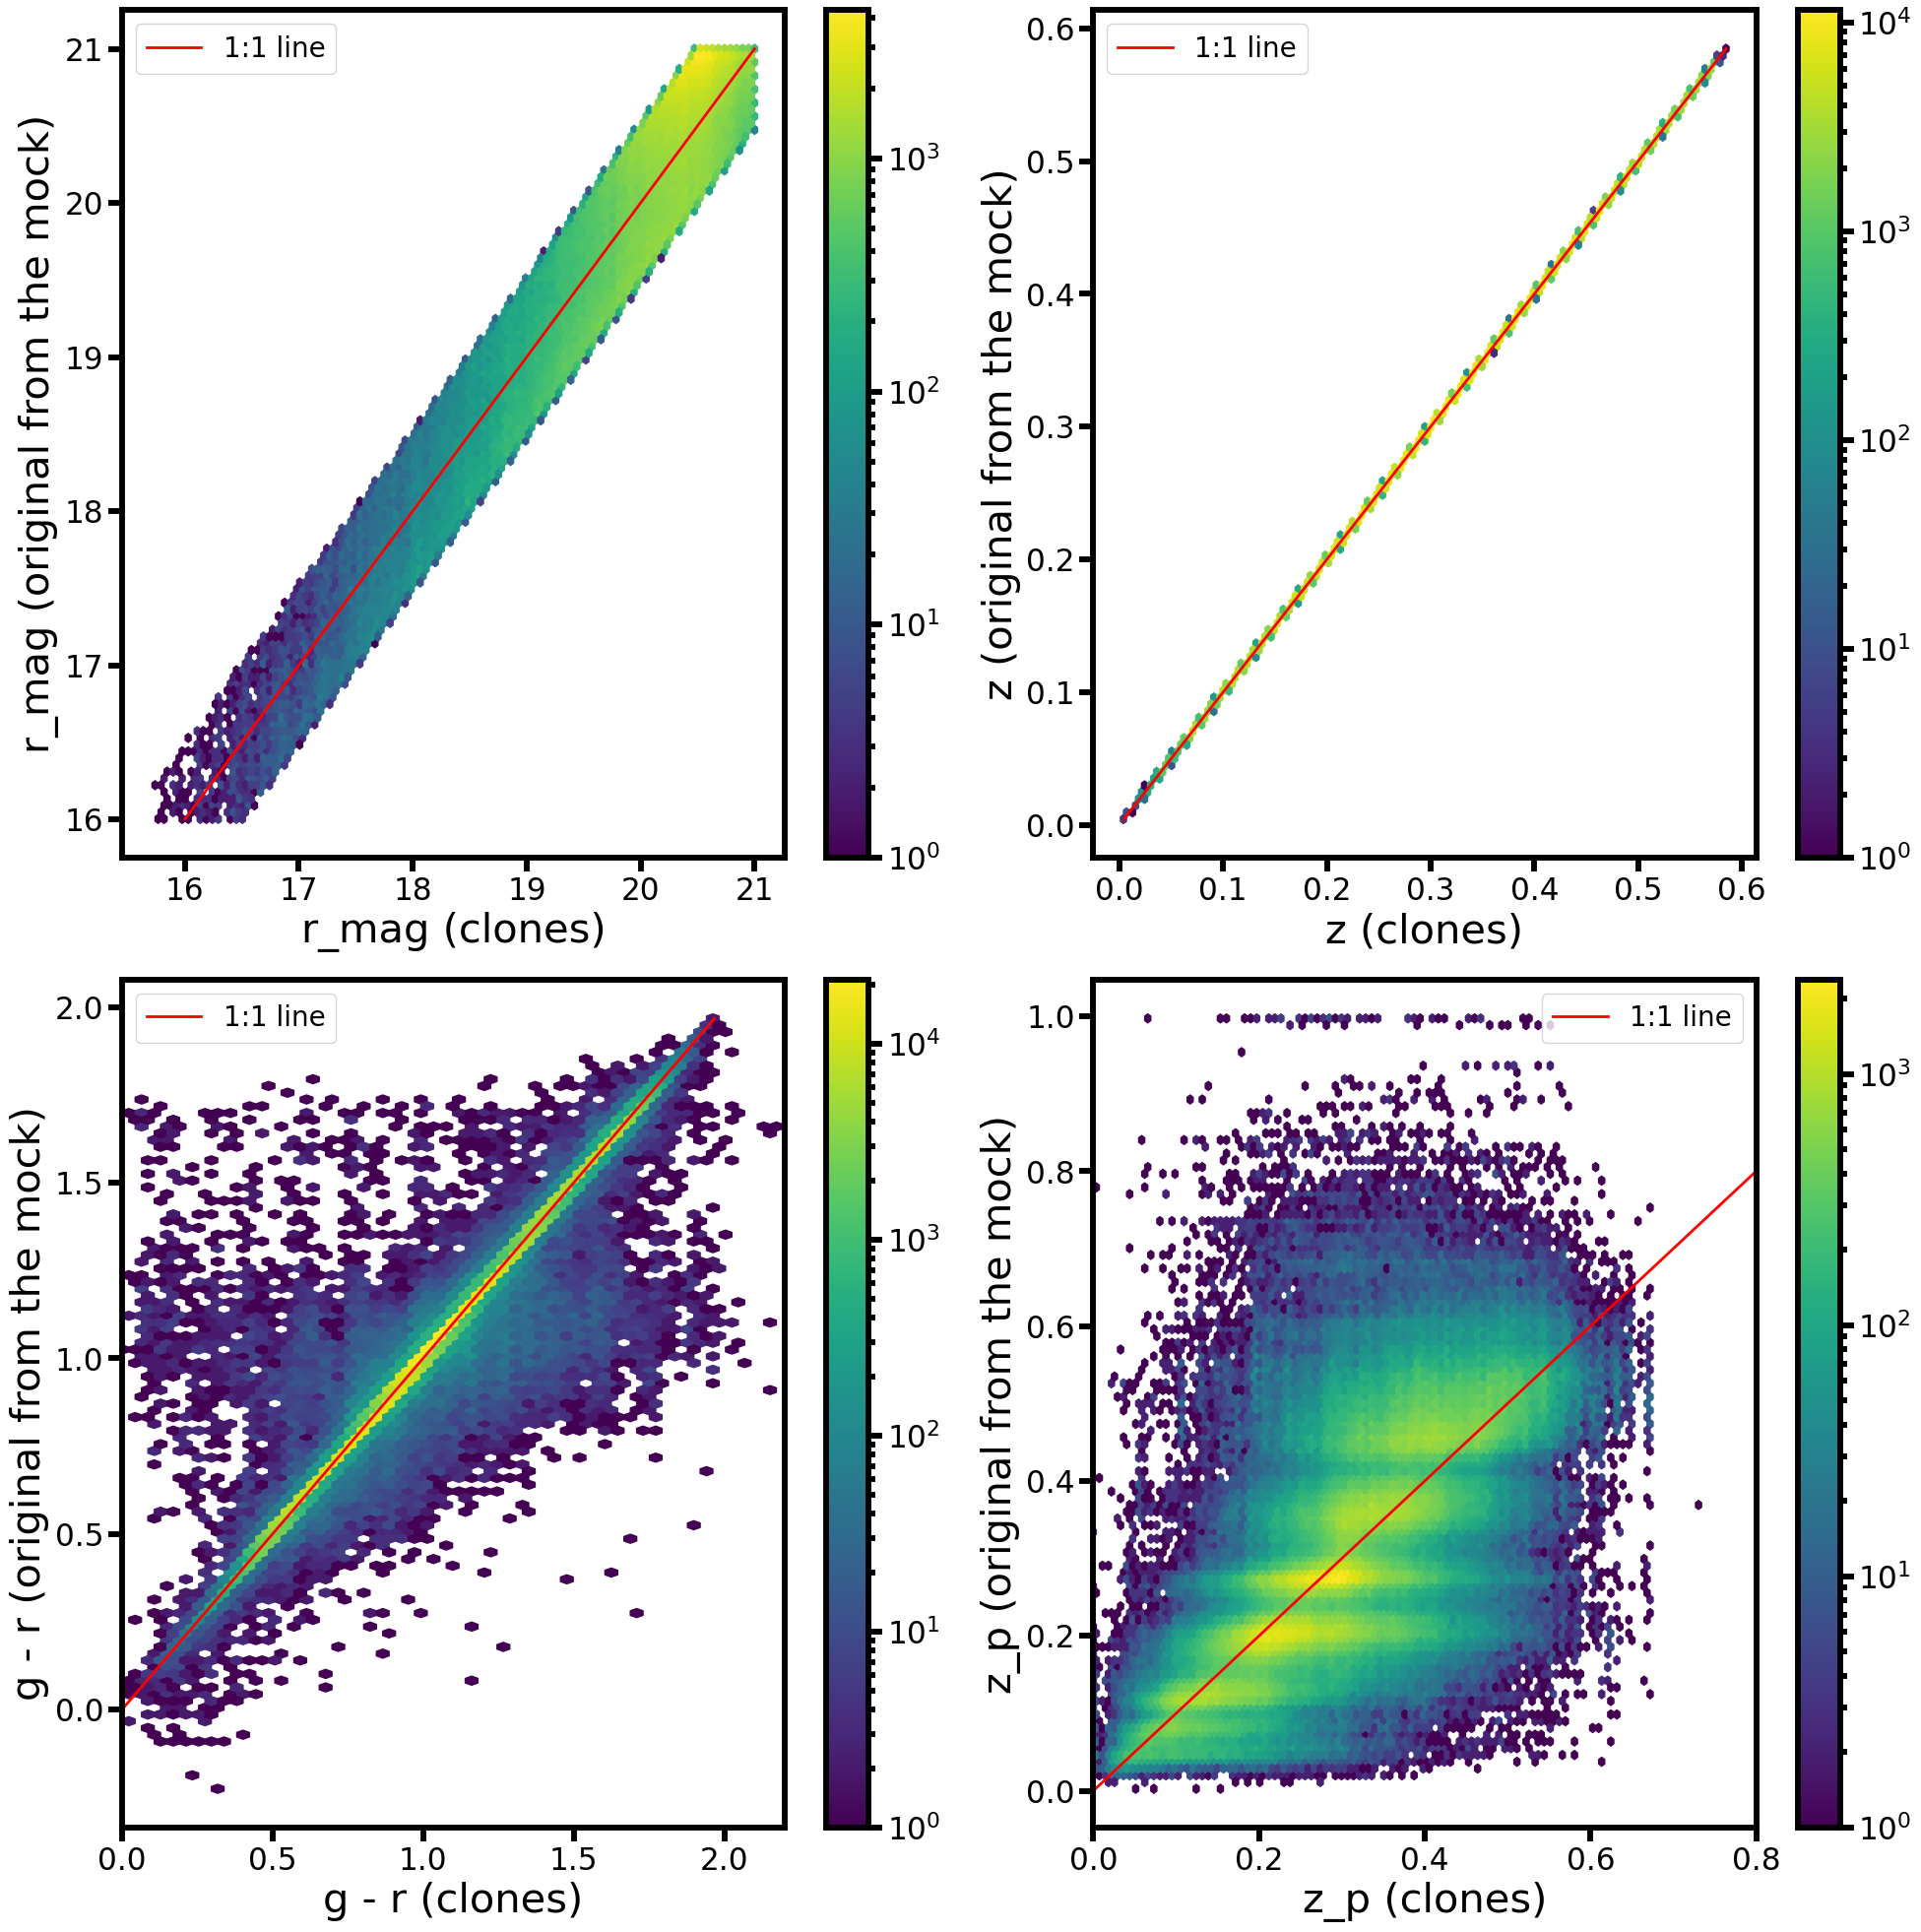

In [29]:
fig, axs = plt.subplots(figsize=(20, 20), nrows=2, ncols=2)

hb = axs[0, 0].hexbin(rmag_clones, magr, gridsize=100, cmap='viridis', bins='log')
axs[0, 0].plot([magr.min(), magr.max()], [magr.min(), magr.max()], lw=2, color="red", label="1:1 line")
axs[0, 0].set_xlabel("r_mag (clones)", fontsize=30)
axs[0, 0].set_ylabel("r_mag (original from the mock)", fontsize=30)
plt.colorbar(hb, ax=axs[0, 0])
axs[0, 0].legend(fontsize=20)

hb = axs[0, 1].hexbin(zspec_clones, z_spec, gridsize=100, cmap='viridis', bins='log')
axs[0, 1].plot([z_spec.min(), z_spec.max()], [z_spec.min(), z_spec.max()], lw=2, color="red", label="1:1 line")
axs[0, 1].set_xlabel("z (clones)", fontsize=30)
axs[0, 1].set_ylabel("z (original from the mock)", fontsize=30)
plt.colorbar(hb, ax=axs[0, 1])
axs[0, 1].legend(fontsize=20)

hb = axs[1, 0].hexbin(gr_color_clones, g_r_color_mock, gridsize=100, cmap='viridis', bins='log')
axs[1, 0].plot([g_r_color_mock.min(), g_r_color_mock.max()], [g_r_color_mock.min(), g_r_color_mock.max()], lw=2, color="red", label="1:1 line")
axs[1, 0].set_xlabel("g - r (clones)", fontsize=30)
axs[1, 0].set_ylabel("g - r (original from the mock)", fontsize=30)
plt.colorbar(hb, ax=axs[1, 0])
axs[1, 0].set_xlim(0, 2.2)
axs[1, 0].legend(fontsize=20)

hb = axs[1, 1].hexbin(z_phot_pdfs_mock, z_phot_original, gridsize=100, cmap='viridis', bins='log')
axs[1, 1].plot([z_phot_original.min(), z_phot_original.max()], [z_phot_original.min(), z_phot_original.max()], lw=2, color="red", label="1:1 line")
axs[1, 1].set_xlabel("z_p (clones)", fontsize=30)
axs[1, 1].set_ylabel("z_p (original from the mock)", fontsize=30)
plt.colorbar(hb, ax=axs[1, 1])
axs[1, 1].set_xlim(0, 0.8)
axs[1, 1].legend(fontsize=20)

fig.tight_layout(pad=2.0)

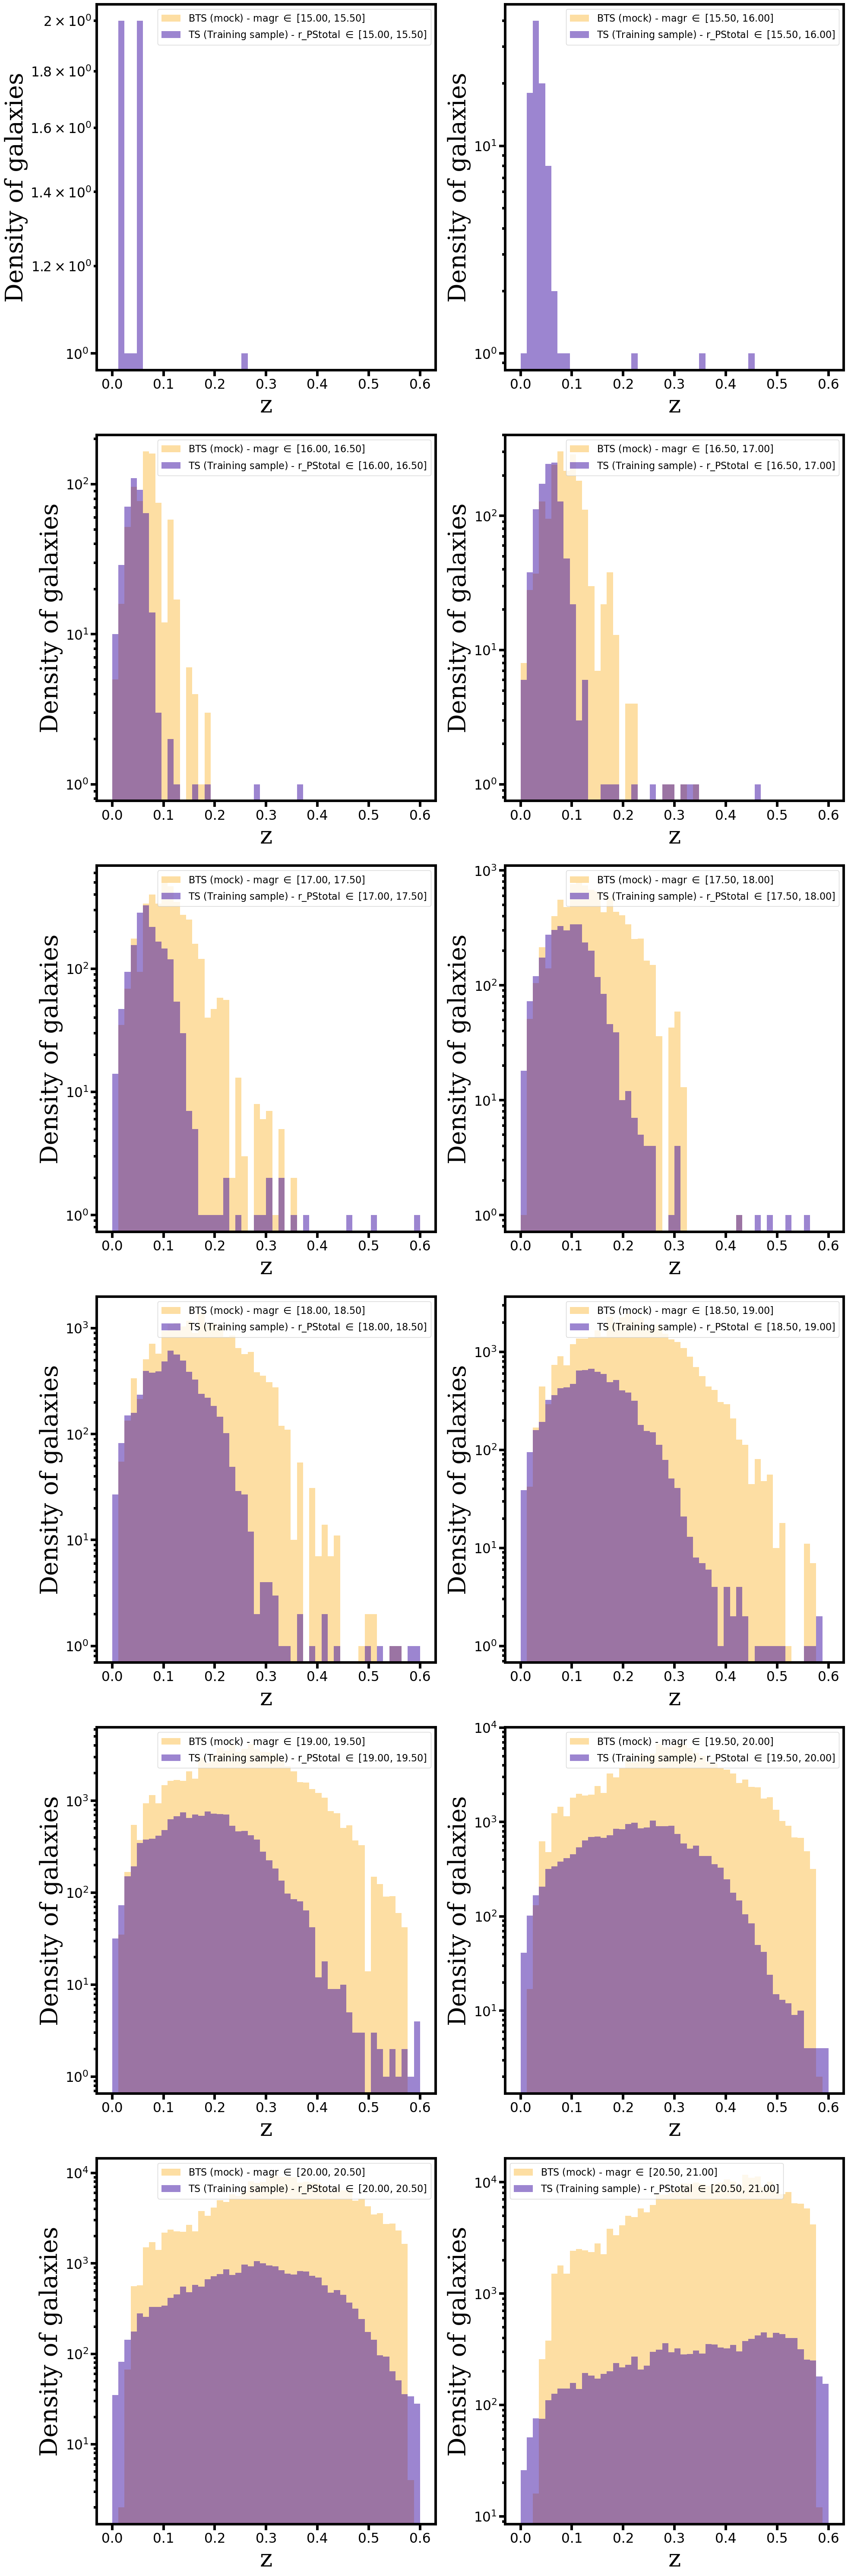

In [132]:
fig, axs = plt.subplots(nrows=int(num_bins/2), ncols=2, figsize=(2*10, num_bins/2*10))

for i in range(num_bins):
    ax = axs[i//2, i%2]
    ax.hist(z_spec[mask_no_clones][(magr[mask_no_clones] > bins_BTS[i]) & (magr[mask_no_clones] < bins_BTS[i+1])], bins=50, color="#fcbf49", alpha=0.5, 
                            density=False, label=r"BTS (mock) - magr $\in$ [{:.2f}, {:.2f}]".format(bins_BTS[i], bins_BTS[i+1]), range=[0, 0.6])
    ax.hist(z_pdfs[(r_PStotal_pdfs > bins_TS[i]) & (r_PStotal_pdfs < bins_TS[i+1])], bins=50, color="#3a0ca3", 
                        alpha=0.5, density=False, label=r"TS (Training sample) - r_PStotal $\in$ [{:.2f}, {:.2f}]".format(bins_TS[i], bins_TS[i+1]), range=[0, 0.6])

    ax.set_yscale("log")
    ax.set_ylabel("Density of galaxies", fontdict=font)
    ax.set_xlabel("z", fontdict=font)
    ax.legend(fontsize=labelsize)

fig.tight_layout(pad=2.0)


### Let's determine the properties of the 20 most populated clusters of the mock

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 50))

j_start = 1250
for j in np.arange(j_start+0, j_start+10, 1):
    
    print(j)

    halo_id = halo_ids_list_unique[j]
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot_pdfs[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]
    
    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)

    z_bins = 30
    i = np.argmax(np.histogram(halo_zspec, bins=z_bins)[0])
    z_cluster = np.histogram(halo_zspec, bins=z_bins)[1][i]
    
    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h
    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)
    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)
    
    
    ax1 = axs[int(np.floor((j-j_start)/2)), (j-j_start)%2]
    sc = ax1.scatter(halo_ra, halo_dec, c=halo_zphot, cmap=cm1)
    ax1.set_xlabel("R.A.", fontdict=font)
    ax1.set_ylabel("Dec.", fontdict=font)

    ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")

    ax1.tick_params(axis='x', rotation=45)

    c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

    r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
                lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
    ax1.add_patch(r1)

    r2 = SphericalCircle(c0, 3*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
                lw=3, label=r"$3 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
    ax1.add_patch(r2)
    
    ax1.text(ra0-3*r200_deg, dec0+3*r200_deg, s=r"$RA_0 = {:.2f}$".format(ra0), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.8*r200_deg, s=r"$Dec_0 = {:.2f}$".format(dec0), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.6*r200_deg, s=r"$z_C = {:.2f}$".format(z_cluster), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.4*r200_deg, s=r"$m200 = {:.2f} (1e15 Msun/h)$".format(m200.value/1e15), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.2*r200_deg, s=r"$r200 = {:.2f}º$".format(r200.value), fontsize=15)
    
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
    cbar.set_label(label="z_phot", fontdict=font)
    cbar.ax.tick_params(labelsize=labelsize)

    ax1.legend(fontsize=labelsize)
    
    fig.tight_layout(pad=3.0)

plt.savefig("../figures/cluster_mock_properties/cluster_mock_properties_{}_to_{}.png".format(j_start, j_start+9), dpi='figure', format='png')

### Defining list of clusters' halo ids and loading cluster data

In [6]:
#I have to apply the mask "firstHaloinFoFGroupId > 0" because otherwise I will have the value -9223372036854775808
#in it, which is actually a value assumed by python for the galaxies with no firstHaloinFoFGroupId assigned to it

halo_members_list = []
for i in range(len(np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0]))):
    halo_members = np.sum(firstHaloinFoFGroupId == np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[i])
    halo_members_list.append(halo_members)

halo_ids_list = np.array([])
for i_mock in np.arange(0, 500, 1):
    halo_ids = np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[halo_members_list == np.flip(np.sort(halo_members_list))[i_mock]]
    halo_ids_list = np.concatenate((halo_ids_list, halo_ids))

halo_ids_list_unique = []
for h in halo_ids_list:
    if ~np.isin(h, halo_ids_list_unique): halo_ids_list_unique.append(h)


## Running in a loop

In [ ]:
table = Table(scat)

for i_mock in np.arange(0, 100):
    
    halo_id = halo_ids_list_unique[i_mock]
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot_pdfs[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]

    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)
    
    z_bins = 20
    bw = (halo_zspec.max() - halo_zspec.min()) / z_bins

    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
    zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
    log_dens_zz = kde.score_samples(zz)

    z_cluster = zz[np.argmax(np.exp(log_dens_zz))]
    
    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h
    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)

    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

    pre_mask = (ra < ra0 + 6*r200_deg) & (ra > ra0 - 6*r200_deg) & (dec < dec0 + 6*r200_deg) & (dec > dec0 - 6*r200_deg)
    halo_mask_restricted = halo_mask[pre_mask]

    dist = clustercentric_distance(ra[pre_mask], dec[pre_mask], ra0, dec0)
    
    dist_field = dist[~halo_mask_restricted]
    
    sigma_z = np.array([sigma_nmad_(r) for r in magr[pre_mask]])

    #Define the volume of the cluster
    #fz1 determines the extent of the "mask_cluster", fz2 determines the extent to compute P(C | zp), and fr defines the radial extent of the objects
    fz1 = 1.0
    fz2 = fz1
    fr = 5.0

    #This mask defines all galaxies in the fr*R200 projected area of the cluster
    mask_cluster_region = dist < fr*r200_deg

    #This one restricts the above mask to only the galaxies delimited by +/-fz*sigma from the cluster redshift, defining a list of candidate members
    mask_cluster = mask_cluster_region & (z_phot_pdfs[pre_mask] > z_cluster - fz1*sigma_z*(1+z_cluster)) & (z_phot_pdfs[pre_mask] < z_cluster + fz1*sigma_z*(1+z_cluster))
    
    bw = (z_phot_pdfs[pre_mask][mask_cluster].max() - z_phot_pdfs[pre_mask][mask_cluster].min()) / z_bins

    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(z_phot_pdfs[pre_mask][mask_cluster][:, np.newaxis])
    zz_phot = np.linspace(z_phot_pdfs[pre_mask][mask_cluster].min(), z_phot_pdfs[pre_mask][mask_cluster].max(), 
                          len(z_phot_pdfs[pre_mask][mask_cluster]))[:, np.newaxis]
    log_dens_zz_phot = kde.score_samples(zz_phot)

    zp_peak = zz_phot[np.argmax(np.exp(log_dens_zz_phot))]
    zp_bias = zp_peak - z_cluster

    z_phot_pdfs_unbiased = z_phot_pdfs - zp_bias

    mask_cluster_unbiased = mask_cluster_region & (z_phot_pdfs_unbiased[pre_mask] > z_cluster - 
                        fz1*sigma_z*(1+z_cluster)) & (z_phot_pdfs_unbiased[pre_mask] < z_cluster + fz1*sigma_z*(1+z_cluster))

    halo_zphot = z_phot_pdfs_unbiased[halo_mask]
    
    P_pz_C_array = P_pz_v2(z_cluster, magr[pre_mask][mask_cluster_unbiased],
                       means_pdfs_mock.T[pre_mask][mask_cluster_unbiased], 
                       weights_pdfs_mock.T[pre_mask][mask_cluster_unbiased],
                       stds_pdfs_mock.T[pre_mask][mask_cluster_unbiased], fz=3.0)
    
    mask_infalling = spec_members_vesc(m200, r200_mpc/cosmo.h, z_cluster, z_spec[pre_mask][mask_cluster_unbiased], 1.0)
    z_infalling = z_spec[pre_mask][mask_cluster_unbiased][mask_infalling]

    
    completeness_zp = []
    purity_zp = []
    d = 0.01
    Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

    for Pmem_cut in Pmem_cut_arr_zp:

        c = np.sum((P_pz_C_array > Pmem_cut) & mask_infalling) / np.sum(mask_infalling)
        p = np.sum((P_pz_C_array > Pmem_cut) & mask_infalling) / np.sum(P_pz_C_array > Pmem_cut)

        completeness_zp.append(c)
        purity_zp.append(p)
        
    #We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
    completeness_zp = np.array(completeness_zp)
    purity_zp = np.array(purity_zp)

    F1_zp = 2 * completeness_zp*purity_zp/(completeness_zp + purity_zp)

    cut_zp = Pmem_cut_arr_zp[np.argmax(F1_zp)]

    table[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp].write("tables/testing-on-mocks/cluster-mock_{}_members.csv".format(i_mock), format='csv', overwrite=True)

## Not a loop anymore

In [7]:
#To select the five more populated halos, I just need to do the following for the 
#last five elements of np.sort(halo_members_list)

#I am selecting the haloId of the cluster with the higher number of elements
#To select the five most populated cluster, I just need to apply i = 1, 2, 3, 4, 5

i_mock = 0
halo_id = halo_ids_list_unique[i_mock]
halo_mask = firstHaloinFoFGroupId == halo_id

halo_ra = ra[halo_mask]
halo_dec = dec[halo_mask]
halo_zphot = z_phot_pdfs_mock[halo_mask]
halo_zspec = z_spec[halo_mask]
halo_magr = magr[halo_mask]
halo_x = x[halo_mask]
halo_y = y[halo_mask]
halo_z = z[halo_mask]

#Define some quantities for the cluster (center cordinates (RA, Dec) and (x0, y0, z0), redshift, radius, photo-z error (sigma))
ra0 = np.mean(halo_ra)
dec0 = np.mean(halo_dec)

x0 = np.mean(halo_x)
y0 = np.mean(halo_y)
z0 = np.mean(halo_z)

z_bins = 20
bw = (halo_zspec.max() - halo_zspec.min()) / z_bins
kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
log_dens_zz = kde.score_samples(zz)
z_cluster = zz[np.argmax(np.exp(log_dens_zz))][0]

m200 = scat["m_crit200"][mask_good][halo_mask].max() * 1e10 * u.Msun / cosmo.h
r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
r200_mpc = r200.to(u.Mpc)
# kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
kpc_scale = cosmo.kpc_comoving_per_arcmin(z=z_cluster).value/60.
r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

if i_mock == 0:
    r200_mpc = 2.9086829322414 * u.Mpc
    r200_deg = 0.13733324834507615 #deg

/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
#This pre-mask is a just way to reduce the number of candidate members and run the method faster.
#It a very 6R200-sides square around the cluster center.
pre_mask = (ra < ra0 + 6*r200_deg) & (ra > ra0 - 6*r200_deg) & (dec < dec0 + 6*r200_deg) & (dec > dec0 - 6*r200_deg)
halo_mask_restricted = halo_mask[pre_mask]

dist = clustercentric_distance(ra[pre_mask], dec[pre_mask], ra0, dec0)

#Computing the distance between all galaxies that I know are not in the cluster and the center of the cluster
# dist_field = clustercentric_distance(ra[~halo_mask], dec[~halo_mask], ra0, dec0)
dist_field = dist[~halo_mask_restricted]

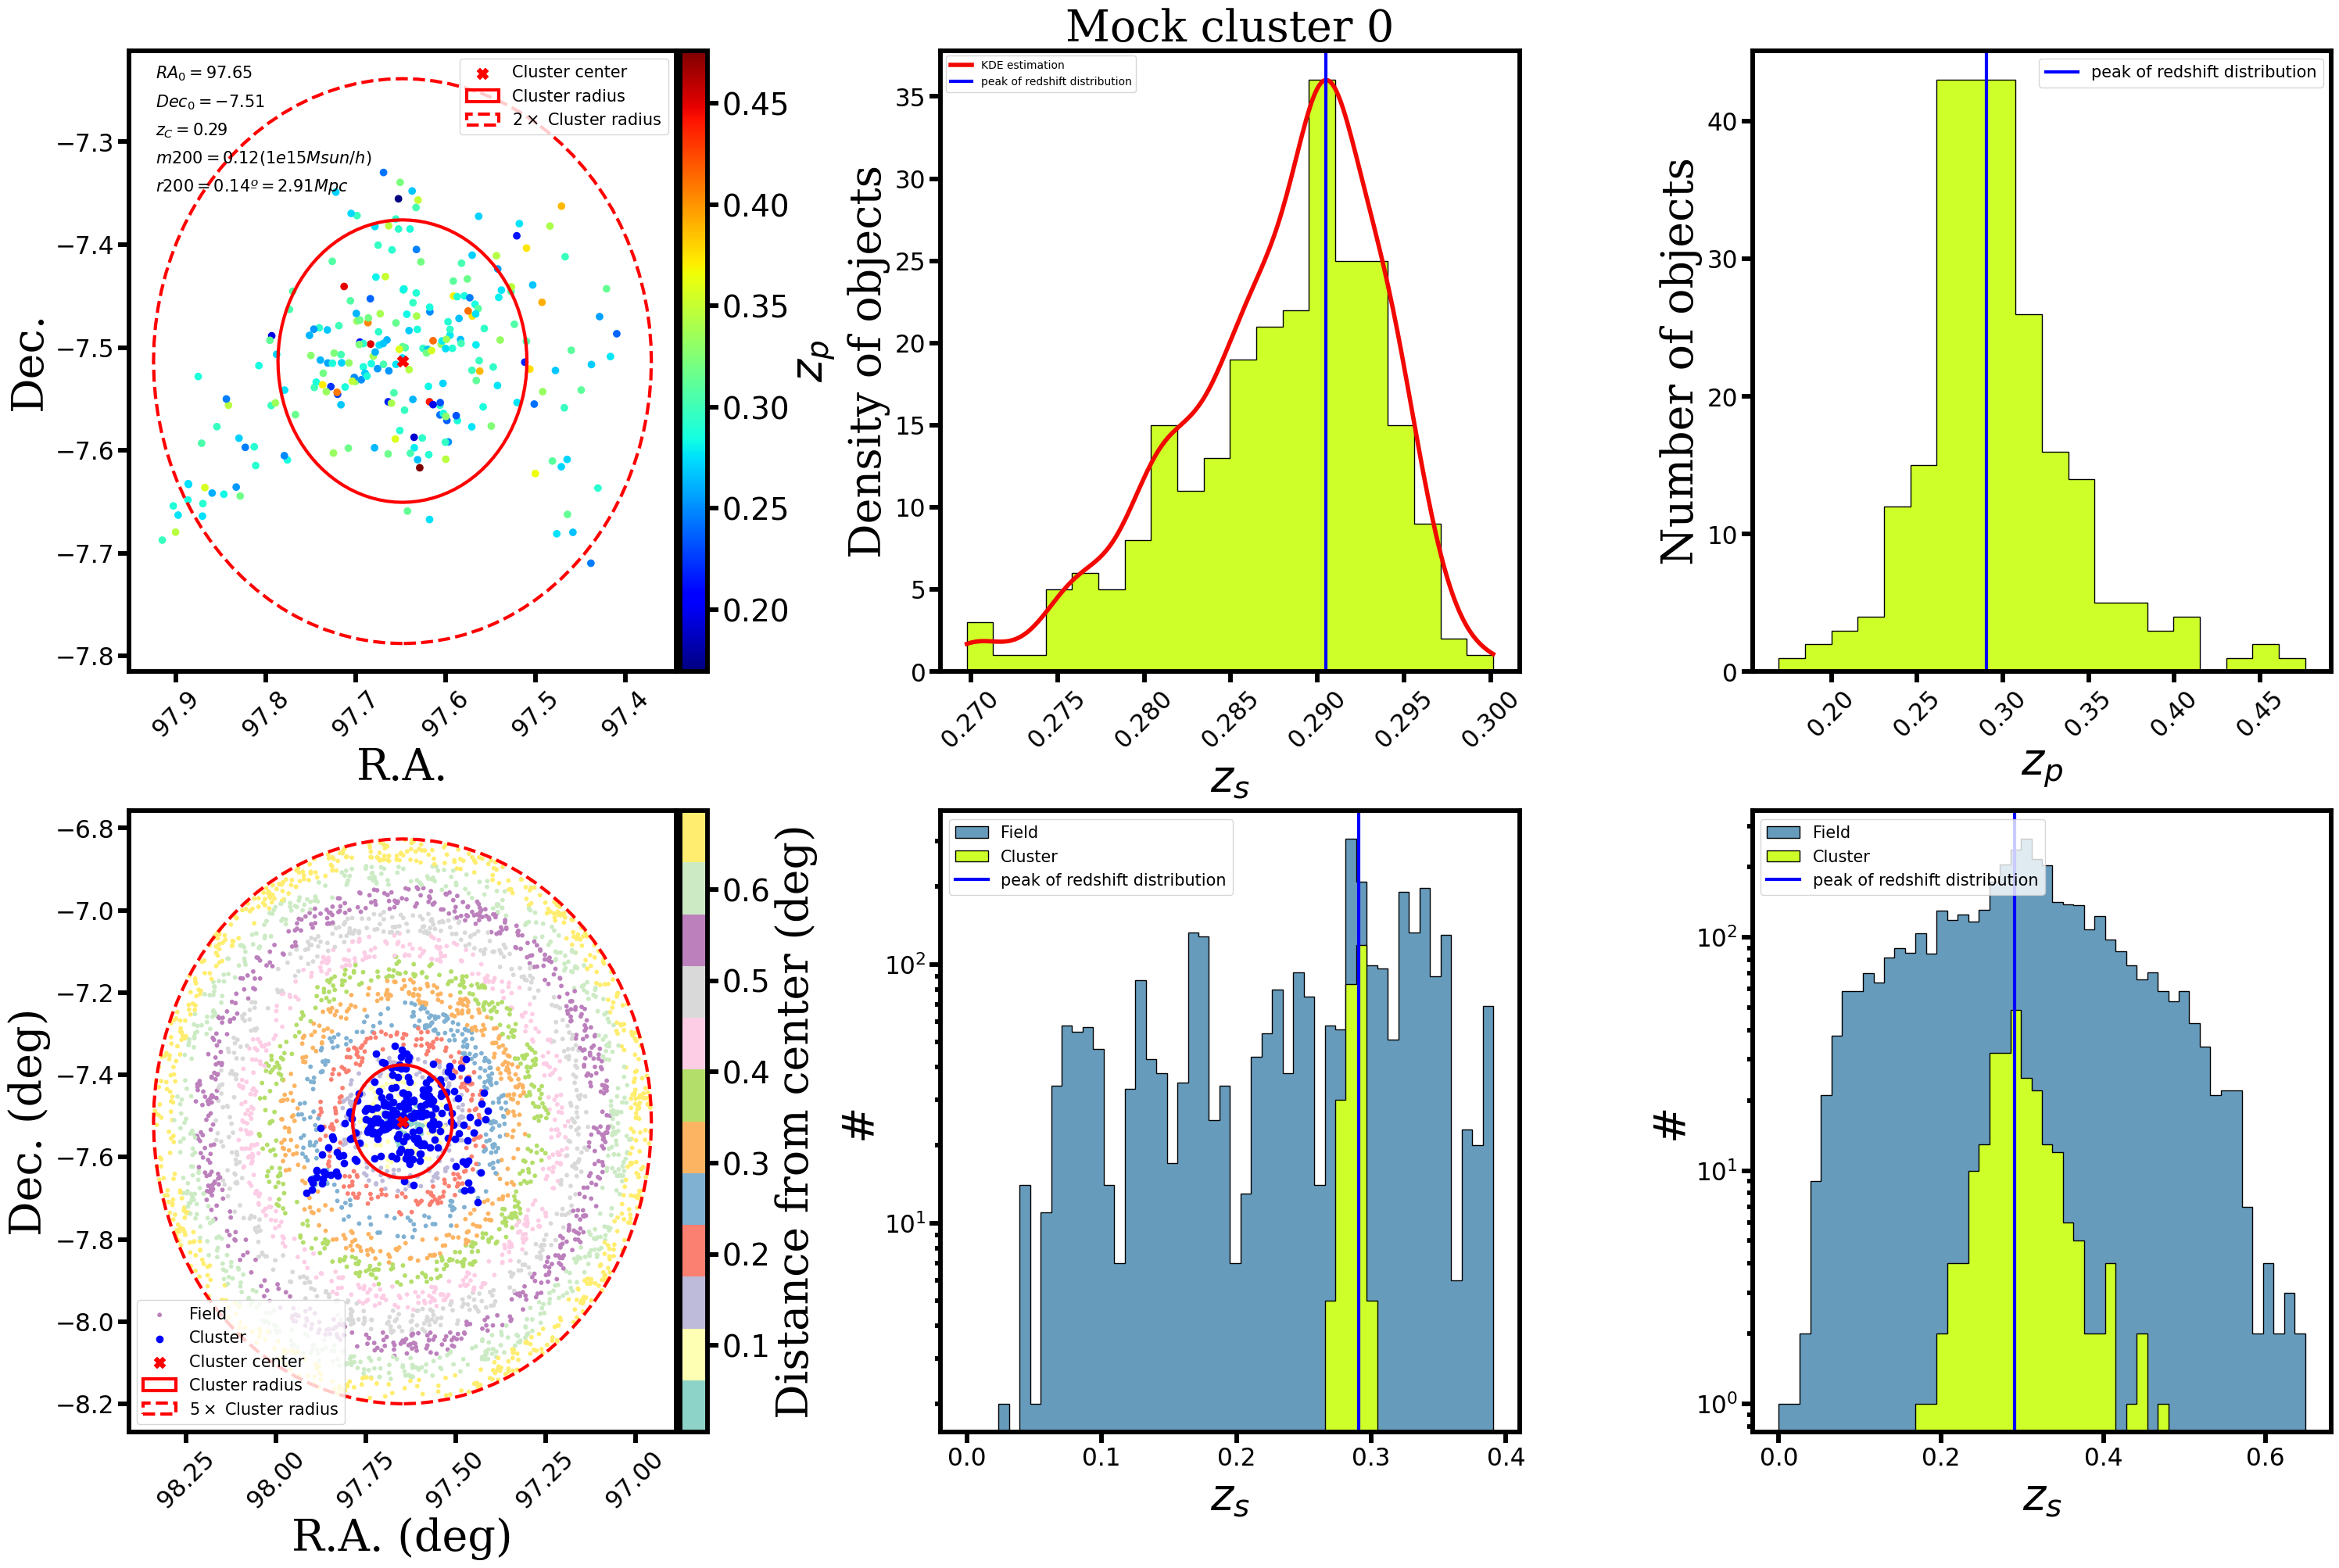

In [207]:
z_bins = 20
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(30, 20))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[0, 2]
ax4 = axs[1, 0]
ax5 = axs[1, 1]
ax6 = axs[1, 2]

#Plot spatial distribution
sc = ax1.scatter(halo_ra, halo_dec, c=halo_zphot, cmap=cm1)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")

ax1.set_xlabel("R.A.", fontdict=font)
ax1.set_ylabel("Dec.", fontdict=font)
ax1.tick_params(axis='x', rotation=45)

ax1.text(ra0+2*r200_deg, dec0+2*r200_deg, s=r"$RA_0 = {:.2f}$".format(ra0), fontsize=15)
ax1.text(ra0+2*r200_deg, dec0+1.8*r200_deg, s=r"$Dec_0 = {:.2f}$".format(dec0), fontsize=15)
ax1.text(ra0+2*r200_deg, dec0+1.6*r200_deg, s=r"$z_C = {:.2f}$".format(z_cluster), fontsize=15)
ax1.text(ra0+2*r200_deg, dec0+1.4*r200_deg, s=r"$m200 = {:.2f} (1e15 Msun/h)$".format(m200.value/1e15), fontsize=15)
ax1.text(ra0+2*r200_deg, dec0+1.2*r200_deg, s=r"$r200 = {:.2f}º = {:.2f} Mpc$".format(r200_deg, r200_mpc.value), fontsize=15)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)
r2 = SphericalCircle(c0, 2*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$2 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r2)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$z_p$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.invert_xaxis()
ax1.legend(fontsize=15)


#Distribution of spec-zs of cluster galaxies
hist = ax2.hist(halo_zspec, bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k', 
         range=[halo_zspec.min(), halo_zspec.max()])[0]
ax2.set_xlabel("z_spec", fontdict=font)
ax2.set_ylabel("Number of objects", fontdict=font)
ax2.tick_params(axis='x', rotation=45)
ax2.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)

f = hist[np.argmax(hist)] / np.exp(log_dens_zz)[np.argmax(np.exp(log_dens_zz))]
ax2.plot(zz, np.exp(log_dens_zz)*f, lw=4, color=colors1[8], label="KDE estimation")
ax2.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax2.set_xlabel(r"$z_s$", fontdict=font)
ax2.set_ylabel("Density of objects", fontdict=font)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=10)


#Distribution of photo-zs of cluster galaxies
ax3.hist(halo_zphot, bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k')[2]
ax3.set_xlabel(r"$z_p$", fontdict=font)
ax3.set_ylabel("Number of objects", fontdict=font)
ax3.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax3.tick_params(axis='x', rotation=45)
ax3.legend(fontsize=15)


#Plot spatial distribution with field
max_dist = 5*r200_deg
sc = ax4.scatter(ra[pre_mask][~halo_mask_restricted][dist_field < max_dist], dec[pre_mask][~halo_mask_restricted][dist_field < max_dist], 
                c=dist_field[dist_field < max_dist], cmap=cm.Set3, s=10, label="Field")
sc2 = ax4.scatter(halo_ra, halo_dec, c="blue", label="Cluster")
ax4.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax4.tick_params(axis='x', rotation=45)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax4.add_patch(r1)

r2 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax4.add_patch(r2)

ax4.set_xlabel("R.A. (deg)", fontdict=font)
ax4.set_ylabel("Dec. (deg)", fontdict=font)

divider = make_axes_locatable(ax4)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)
ax4.legend(fontsize=15)
ax4.invert_xaxis()


#Distribution of spec-zs with field
max_z = z_cluster + 0.1
ax5.hist(z_spec[pre_mask][~halo_mask_restricted][dist_field < max_dist], bins=50, 
        color="#669bbc", histtype='stepfilled', edgecolor='k', range=[0, max_z], label="Field", density=False)[2]

ax5.hist(halo_zspec, bins=50, color=colors1[5], histtype='stepfilled', edgecolor='k',
        range=[0, max_z], label="Cluster", density=False)[2]

ax5.set_xlabel(r"$z_s$", fontdict=font)
ax5.set_ylabel("#", fontdict=font)
ax5.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax5.set_yscale("log")
ax5.legend(fontsize=15, loc=2)


#Distribution of photo-zs with field
ax6.hist(z_phot_pdfs_mock[pre_mask][~halo_mask_restricted][dist_field < max_dist], bins=50, 
        color="#669bbc", histtype='stepfilled', edgecolor='k', 
        range=[0, z_phot_pdfs_mock[pre_mask][~halo_mask_restricted][dist_field < max_dist].max()], label="Field", density=False)[2]

ax6.hist(halo_zphot, bins=50, color=colors1[5], histtype='stepfilled', edgecolor='k',
        range=[0, z_phot_pdfs_mock[pre_mask][~halo_mask_restricted][dist_field < max_dist].max()], label="Cluster", density=False)[2]

ax6.set_xlabel(r"$z_s$", fontdict=font)
ax6.set_ylabel("#", fontdict=font)
ax6.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax6.set_yscale("log")
ax6.legend(fontsize=15, loc=2)



fig.tight_layout(pad=1.0)
# plt.savefig("../figures/membership-testing-on-mocks/RA_DEC_z_zphot(KNN-with-z)_distribution_mock{}.png".format(i_mock), dpi='figure', format='png')

### Definining a volume for the cluster and removing bias from photo-zs


In [172]:
sigma_z = np.array([sigma_nmad_(r) for r in magr[pre_mask]])

#Define the volume of the cluster
#fz1 determines the extent of the "mask_cluster", fz2 determines the extent to compute P(C | zp), and fr defines the radial extent of the objects
fz1 = 3.0
fz2 = fz1
fr = 5.0

#This mask defines all galaxies in the fr*R200 projected area of the cluster
mask_cluster_region = dist < fr*r200_deg

#This one restricts the above mask to only the galaxies delimited by +/-fz*sigma from the cluster redshift, defining a list of candidate members
mask_cluster = mask_cluster_region & (z_phot_pdfs_mock[pre_mask] > z_cluster - fz1*sigma_z*(1+z_cluster)) & (z_phot_pdfs_mock[pre_mask] < 
                                                                                                             z_cluster + fz1*sigma_z*(1+z_cluster))

In [173]:
bw = (z_phot_pdfs_mock[pre_mask][mask_cluster].max() - z_phot_pdfs_mock[pre_mask][mask_cluster].min()) / z_bins

kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(z_phot_pdfs_mock[pre_mask][mask_cluster][:, np.newaxis])
zz_phot = np.linspace(z_phot_pdfs_mock[pre_mask][mask_cluster].min(), z_phot_pdfs_mock[pre_mask][mask_cluster].max(), 
                      len(z_phot_pdfs_mock[pre_mask][mask_cluster]))[:, np.newaxis]
log_dens_zz_phot = kde.score_samples(zz_phot)

zp_peak = zz_phot[np.argmax(np.exp(log_dens_zz_phot))]
zp_bias = zp_peak - z_cluster

z_phot_pdfs_unbiased = z_phot_pdfs_mock - zp_bias 

mask_cluster_unbiased = mask_cluster_region & (z_phot_pdfs_unbiased[pre_mask] > z_cluster - 
                    fz1*sigma_z*(1+z_cluster)) & (z_phot_pdfs_unbiased[pre_mask] < z_cluster + fz1*sigma_z*(1+z_cluster))

halo_zphot = z_phot_pdfs_unbiased[halo_mask]

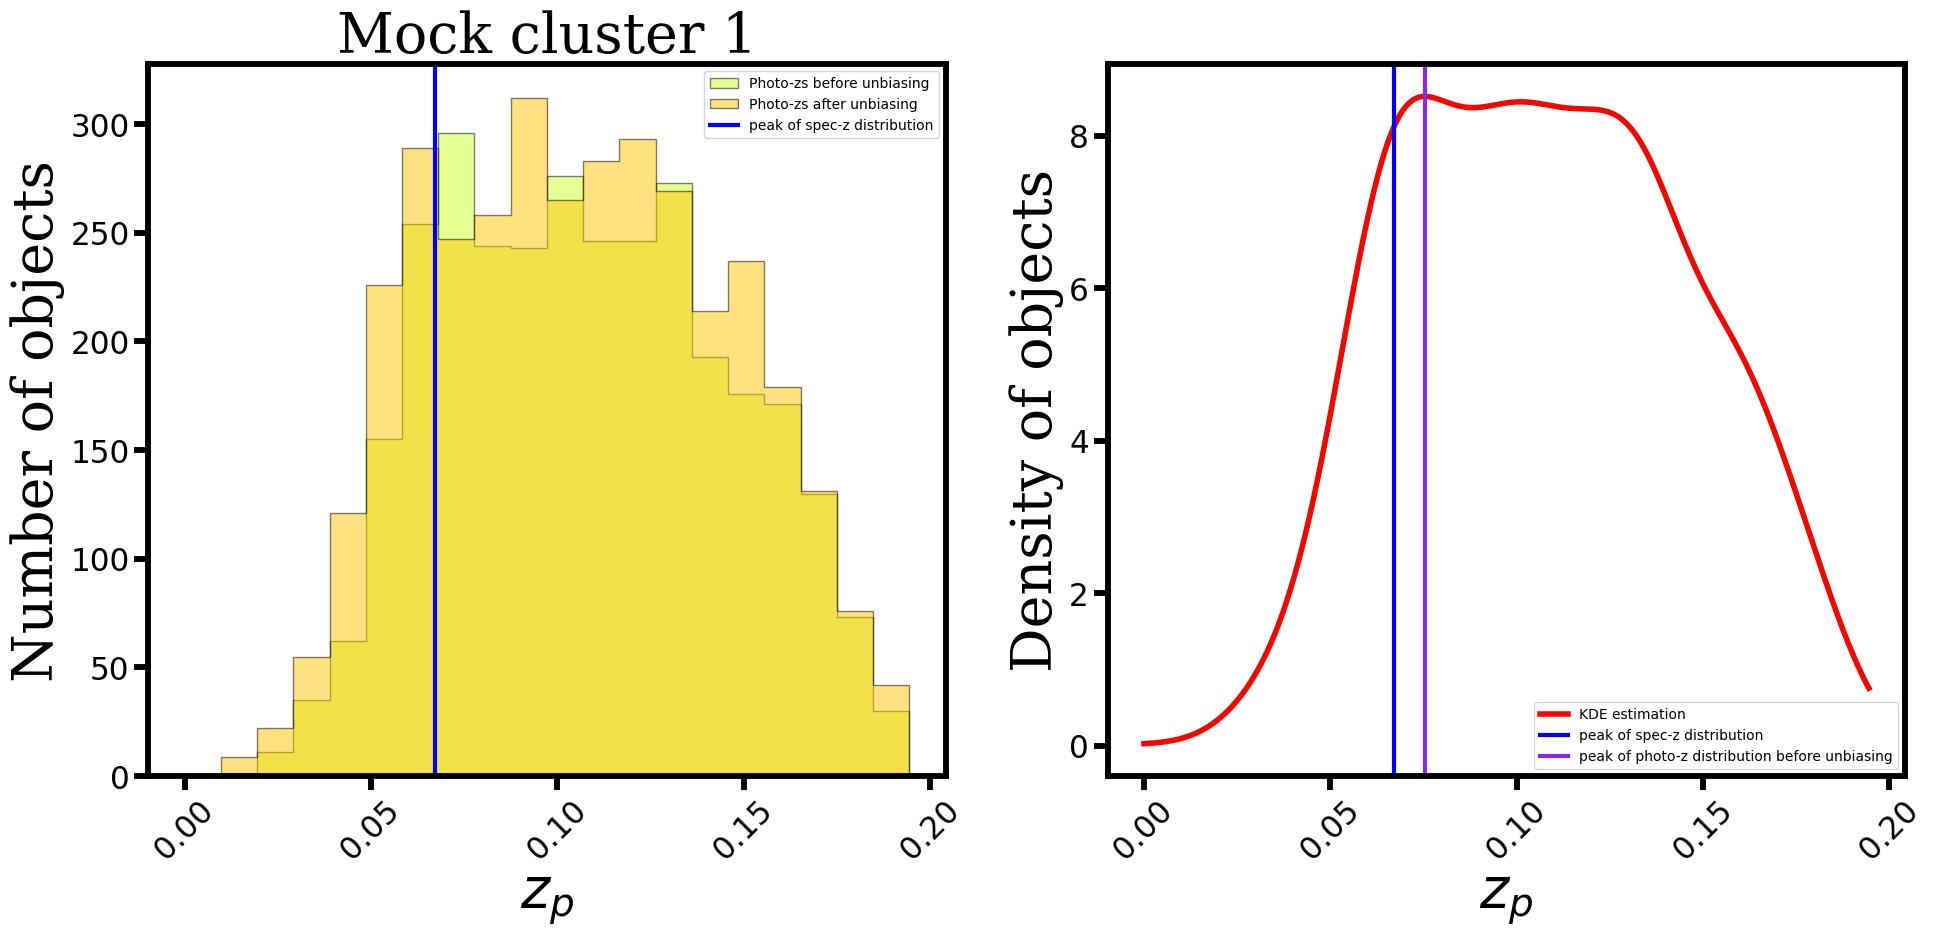

In [174]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(z_phot_pdfs_mock[pre_mask][mask_cluster], bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k', 
         range=[z_phot_pdfs_mock[pre_mask][mask_cluster].min(), z_phot_pdfs_mock[pre_mask][mask_cluster].max()], alpha=0.5, label="Photo-zs before unbiasing")[2]
ax1.hist(z_phot_pdfs_unbiased[pre_mask][mask_cluster_unbiased], bins=z_bins, color=colors1[6], histtype='stepfilled', edgecolor='k', 
         range=[z_phot_pdfs_mock[pre_mask][mask_cluster].min(), z_phot_pdfs_mock[pre_mask][mask_cluster].max()], label="Photo-zs after unbiasing", alpha=0.5)[2]
ax1.axvline(z_cluster, color="blue", lw=3, label="peak of spec-z distribution")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel(r"$z_p$", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(fontsize=10)

ax2 = fig.add_subplot(122)
ax2.plot(zz_phot, np.exp(log_dens_zz_phot), lw=4, color=colors1[8], label="KDE estimation")
ax2.axvline(z_cluster, color="blue", lw=3, label="peak of spec-z distribution")
ax2.axvline(zp_peak, color="blueviolet", lw=3, label="peak of photo-z distribution before unbiasing")
ax2.set_xlabel(r"$z_p$", fontdict=font)
ax2.set_ylabel("Density of objects", fontdict=font)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=10)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/zphot_biased_unbiased_mock{}.png".format(i_mock), dpi='figure', format='png')

### Compute P(C | zp)

To estimate completeness and purity for P(C | zp), I will define the true cluster members + infalling galaxies as the ones selected via 3-sigma-clipping on the spectroscopic redshifts

In [175]:
P_pz_C_array = P_pz_v2(z_cluster, magr[pre_mask][mask_cluster_unbiased],
                       means_pdfs_mock.T[pre_mask][mask_cluster_unbiased], 
                       weights_pdfs_mock.T[pre_mask][mask_cluster_unbiased],
                       stds_pdfs_mock.T[pre_mask][mask_cluster_unbiased], fz=fz2)

/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:329: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:336: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitti

### Selecting true infalling galaxies to compute purity and completeness

#### Selecting spectroscopic members using $|\vec{v}_{pec}| < v_{esc}$

In [ ]:

mask_infalling = spec_members_vesc(m200, r200_mpc/cosmo.h, z_cluster, z_spec[pre_mask][mask_cluster_unbiased], 1.0)
z_infalling = z_spec[pre_mask][mask_cluster_unbiased][mask_infalling]

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ax1.hist(z_infalling, bins=z_bins, histtype='stepfilled', color=colors3[7], alpha=1.0, edgecolor="black", linewidth=2.0)
ax1.set_title(r"$|v_{pec}| < 1.0 \times v_{esc}$", fontdict=font)

ax1.axvline(z_cluster, color="red", label=r"$z_C$")

ax1.set_xlabel(r"$z$", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)

fig.tight_layout()

# plt.savefig("../figures/membership-testing-on-mocks/spec_members_mock{}.png".format(i_mock), dpi='figure', format='png')

In [ ]:
completeness_zp = []
purity_zp = []
d = 0.01
Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_zp:
    
    c = np.sum((P_pz_C_array > Pmem_cut) & mask_infalling) / np.sum(mask_infalling)
    p = np.sum((P_pz_C_array > Pmem_cut) & mask_infalling) / np.sum(P_pz_C_array > Pmem_cut)
    
    completeness_zp.append(c)
    purity_zp.append(p)

#### Selecting spectroscopic members based on velocity-dispersion + sigma-clipping

In [66]:
#Leonard & King (2010)
sigma_V = np.sqrt(50)*cosmo.H0*r200_mpc

#George et al. (2011)
delta_z = (sigma_V * (1 + z_cluster) / cons.c.to(u.km / u.s)).value

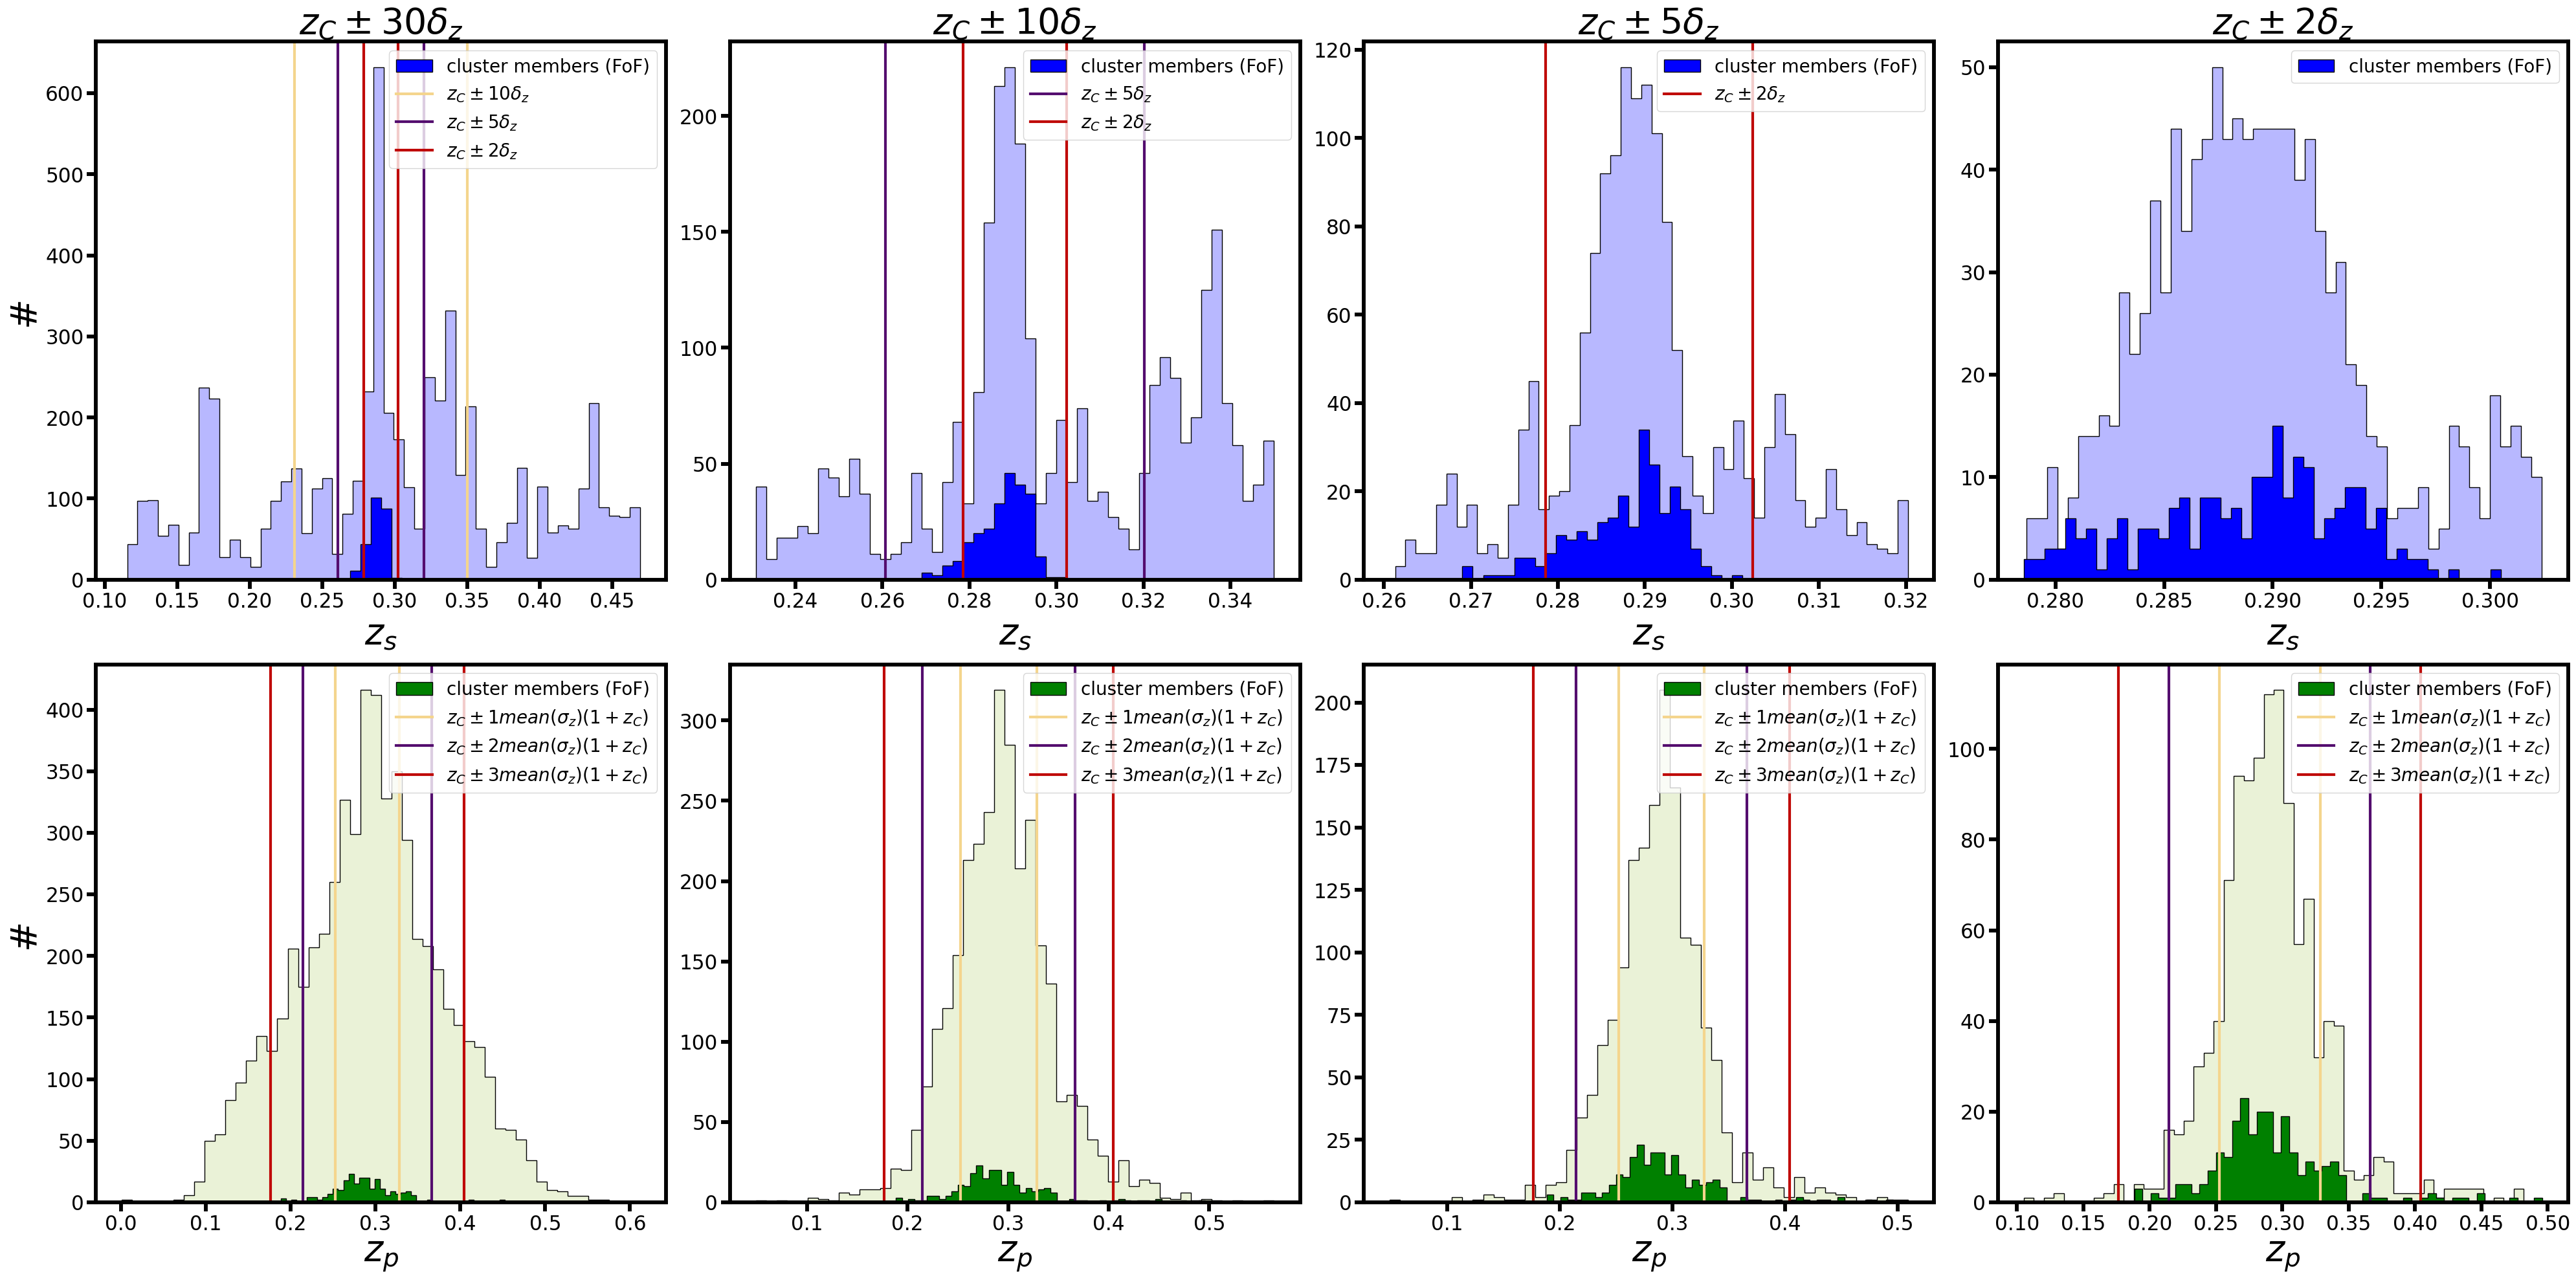

In [ ]:
fdz_list = [30, 10, 5, 2]
fz1_list = [1, 2, 3]
random_colors = ["#708d81", "#f4d58d", "#540d6e", "#bf0603"]

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(40, 20))

for i, fdz in zip(range(0, 4), fdz_list):

    z_range = fdz * delta_z
    mask = (z_spec[pre_mask][mask_cluster_region] > z_cluster-z_range) & (z_spec[pre_mask][mask_cluster_region] < z_cluster+z_range) 

    axs[0, i].hist(z_spec[pre_mask][mask_cluster_region][mask], bins=50, color="#b8b8ff", histtype='stepfilled', edgecolor='k')
    axs[0, i].hist(halo_zspec, bins=50, color="blue", histtype='stepfilled', edgecolor='k', label="cluster members (FoF)", 
                   range=[z_cluster-z_range, z_cluster+z_range])
    axs[0, 0].set_ylabel("#", fontdict=font)
    axs[0, i].set_xlabel(r"$z_s$", fontdict=font)
    axs[0, i].set_title(r"$z_C \pm {}\delta_z$".format(fdz), fontdict=font)

    for fdz_i, c in zip(fdz_list[i+1:], random_colors[i+1:]): 
        z_range = fdz_i * delta_z
        axs[0, i].axvline(z_cluster-z_range, color=c, lw=3, ls="-", label=r"$z_C \pm {}\delta_z$".format(fdz_i))
        axs[0, i].axvline(z_cluster+z_range, color=c, lw=3, ls="-")

    axs[0, i].legend(fontsize=20, loc=1)


    axs[1, i].hist(z_phot_pdfs_mock[pre_mask][mask_cluster_region][mask], bins=50, color="#eaf2d7", histtype='stepfilled', edgecolor='k')
    axs[1, i].hist(halo_zphot, bins=50, color="green", histtype='stepfilled', edgecolor='k', label="cluster members (FoF)")
    axs[1, 0].set_ylabel("#", fontdict=font)
    axs[1, i].set_xlabel(r"$z_p$", fontdict=font)

    for fz1_i, c in zip(fz1_list, random_colors[1:]): 
        axs[1, i].axvline(z_cluster-fz1_i*np.mean(sigma_z)*(1+z_cluster), color=c, lw=3, ls="-", label=r"$z_C \pm {} mean(\sigma_z)(1 + z_C)$".format(fz1_i))
        axs[1, i].axvline(z_cluster+fz1_i*np.mean(sigma_z)*(1+z_cluster), color=c, lw=3, ls="-")

    axs[1, i].legend(fontsize=20, loc=1)

fig.tight_layout(pad=1.5)



In [77]:
#These values of z_lower and z_upper can be better defined in terms of the velocity dispersion
fdz = 4.0
z_lower = z_cluster - fdz*delta_z
z_upper = z_cluster + fdz*delta_z

specz_members_sigma_clipping, id_members_sigma_clipping = sigma_clipping(z_spec[pre_mask][mask_cluster_region], galaxyId[pre_mask][mask_cluster_region],
                                                z_lower, z_upper, 3)


mask_infalling = np.isin(galaxyId[pre_mask][mask_cluster_region], id_members_sigma_clipping)

In [78]:
completeness_zp = []
purity_zp = []
d = 0.01
Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_zp:

    c = np.sum(np.isin(id_members_sigma_clipping, galaxyId[pre_mask][mask_cluster_unbiased][P_pz_C_array > Pmem_cut])) / len(id_members_sigma_clipping)
    p = np.sum(np.isin(galaxyId[pre_mask][mask_cluster_unbiased][P_pz_C_array > Pmem_cut], id_members_sigma_clipping)) / len(galaxyId[pre_mask][mask_cluster_unbiased]
                                                                                                                        [P_pz_C_array > Pmem_cut])
    
    completeness_zp.append(c)
    purity_zp.append(p)

#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_zp = np.array(completeness_zp)
purity_zp = np.array(purity_zp)

F1_zp = 2 * completeness_zp*purity_zp/(completeness_zp + purity_zp)

cut_zp = Pmem_cut_arr_zp[np.argmax(F1_zp)]

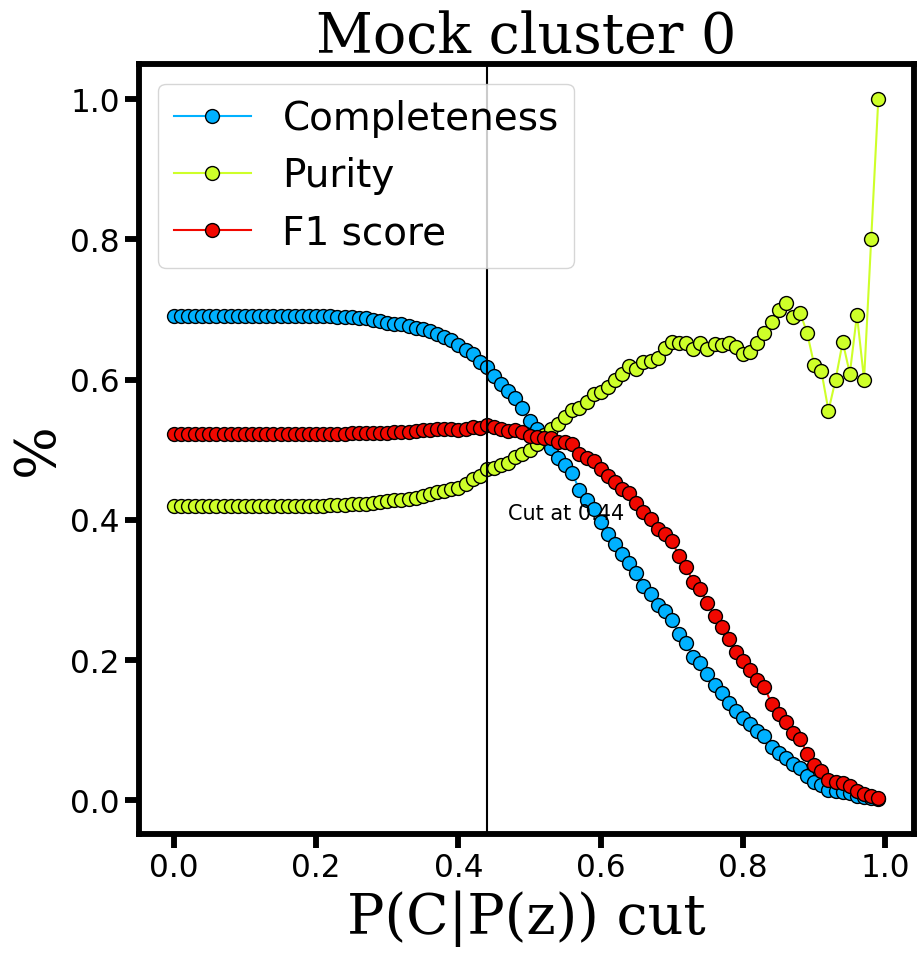

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, F1_zp, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C|P(z)) cut", fontdict=font)

ax1.axvline(cut_zp, color="black")
ax1.text(x=cut_zp+0.03, y=0.4, s="Cut at {:.2f}".format(cut_zp), fontsize=15)

ax1.legend(fontsize=labelsize, loc=2)

# plt.savefig("../figures/membership-testing-on-mocks/purity-completeness_P(C|zp)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

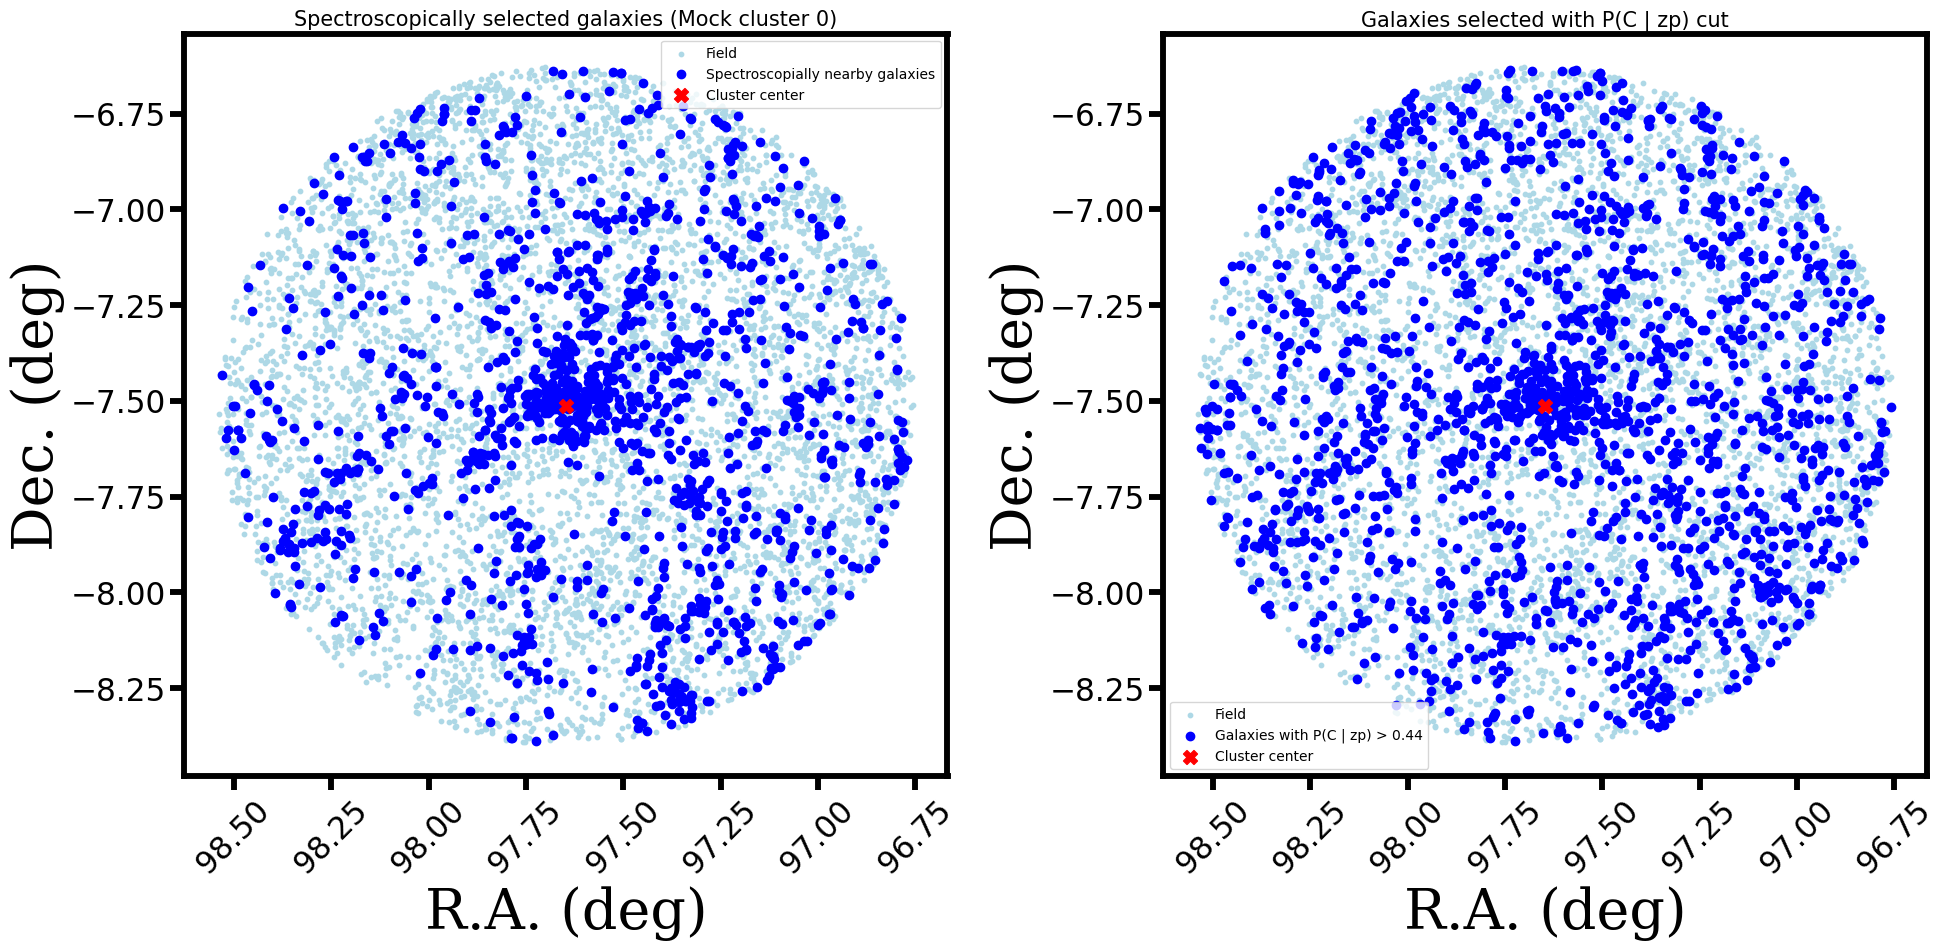

In [81]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[pre_mask][~halo_mask_restricted][dist_field < max_dist], dec[pre_mask][~halo_mask_restricted][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax1.scatter(ra[pre_mask][mask_cluster_region][mask_infalling], dec[pre_mask][mask_cluster_region][mask_infalling], c="blue", label="Spectroscopially nearby galaxies")
ax1.set_title("Spectroscopically selected galaxies (Mock cluster {:d})".format(i_mock), fontsize=15)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.legend(fontsize=10)
ax1.tick_params(axis='x', rotation=45)
ax1.invert_xaxis()

ax2.scatter(ra[pre_mask][~halo_mask_restricted][dist_field < max_dist], dec[pre_mask][~halo_mask_restricted][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], dec[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], c="blue", 
                label="Galaxies with P(C | zp) > {:.2f}".format(cut_zp))
ax2.set_title("Galaxies selected with P(C | zp) cut", fontsize=15)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax2.legend(fontsize=10)
ax2.tick_params(axis='x', rotation=45)
ax2.invert_xaxis()

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|zp)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

#### Selecting infalling galaxies in the mock using $\vec{v}_{3D} < v_{esc}$

In [39]:
vx_galaxies = vx[pre_mask][mask_cluster_unbiased]
vy_galaxies = vy[pre_mask][mask_cluster_unbiased]
vz_galaxies = vz[pre_mask][mask_cluster_unbiased]

x_galaxies = x[pre_mask][mask_cluster_unbiased]
y_galaxies = y[pre_mask][mask_cluster_unbiased]
z_galaxies = z[pre_mask][mask_cluster_unbiased]

dist3D = np.sqrt((x_galaxies - x0)**2 + (y_galaxies - y0)**2 + (z_galaxies - z0)**2)
v3D = (vx_galaxies*(x_galaxies - x0) + vy_galaxies*(y_galaxies - y0) + vz_galaxies*(z_galaxies - z0)) / dist3D

In [24]:
def v_esc(r):

    c = 6
    gc = 1/(np.log(1+c) - c/(1+c))
    G = cons.G

    s = np.pi*r/(2*r200_deg)
    K = gc*(np.log(1 + c*s)/s - np.log(1+c)) + 1

    if r < r200_deg: v_esc = np.sqrt(2*G*m200/(2 * r200_mpc)) * K
    else: v_esc = np.sqrt(2 * G * m200 / (3 * r200_mpc * s))

    return v_esc.to(u.km/u.s)

In [83]:
#Eu tô achando que tem que ter alguma limitação em termos de distância ao centro do aglomerado pra galáxia ser considerada infalling.
#Se eu só usar essa definição de v3D < vesc pra qualquer galáxia no cilindro de 5R200 do aglomerado, pode haver várias galáxias com uma velocidade projetada na direção do
#aglomerado que é menor que a velocidade de escape mas que está super longe do aglomerado de fato, e portanto não tem motivo pra se dizer que ela é "infalling".

# v_esc_array = np.array([v_esc(r) for r in dist[mask_cluster_unbiased]])[:, 0]
# mask_infalling = (np.abs(v3D) < v_esc_array) 

# mask_infalling = dist3D < 5*r200_mpc.value

mask_infalling = np.abs(z_spec[pre_mask][mask_cluster_region] - z_cluster) < delta_z

In [ ]:
completeness_zp = []
purity_zp = []
d = 0.01
Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_zp:

    p = np.sum(np.isin(galaxyId[pre_mask][mask_cluster_region][mask_infalling], galaxyId[pre_mask][mask_cluster_unbiased][P_pz_C_array > Pmem_cut])) / len(
                                                                    galaxyId[pre_mask][mask_cluster_unbiased][P_pz_C_array > Pmem_cut])
    c = np.sum(np.isin(galaxyId[pre_mask][mask_cluster_region][mask_infalling], galaxyId[pre_mask][mask_cluster_unbiased][P_pz_C_array > Pmem_cut])) / len(
                                                                    galaxyId[pre_mask][mask_cluster_region][mask_infalling])
    
    completeness_zp.append(c)
    purity_zp.append(p)

#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_zp = np.array(completeness_zp)
purity_zp = np.array(purity_zp)

F1_zp = 2 * completeness_zp*purity_zp/(completeness_zp + purity_zp)

cut_zp = Pmem_cut_arr_zp[np.argmax(F1_zp)]

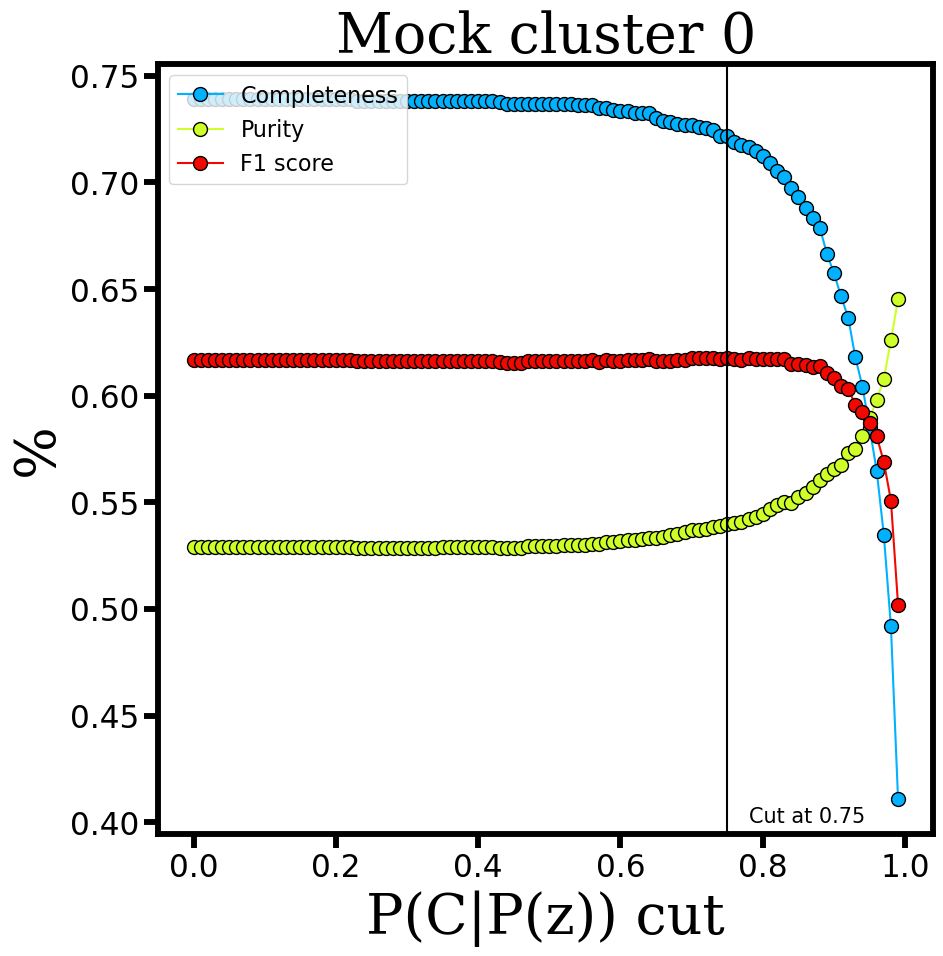

In [85]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, F1_zp, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C|P(z)) cut", fontdict=font)

ax1.axvline(cut_zp, color="black")
ax1.text(x=cut_zp+0.03, y=0.4, s="Cut at {:.2f}".format(cut_zp), fontsize=15)

# c_best = 1.0
# ax1.axhline(c_best, color="black", linestyle="dashed")
# ax1.text(0.65, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

# p_best = 0.82
# ax1.axhline(p_best, color="black", linestyle="dashed")
# ax1.text(0.65, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

ax1.legend(fontsize=labelsize, loc=2)

# plt.savefig("../figures/membership-testing-on-mocks/purity-completeness_P(C|zp)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

/tmp/ipykernel_367191/831106513.py:8: RuntimeWarning: invalid value encountered in divide
  K = gc*(np.log(1 + c*s)/s - np.log(1+c)) + 1


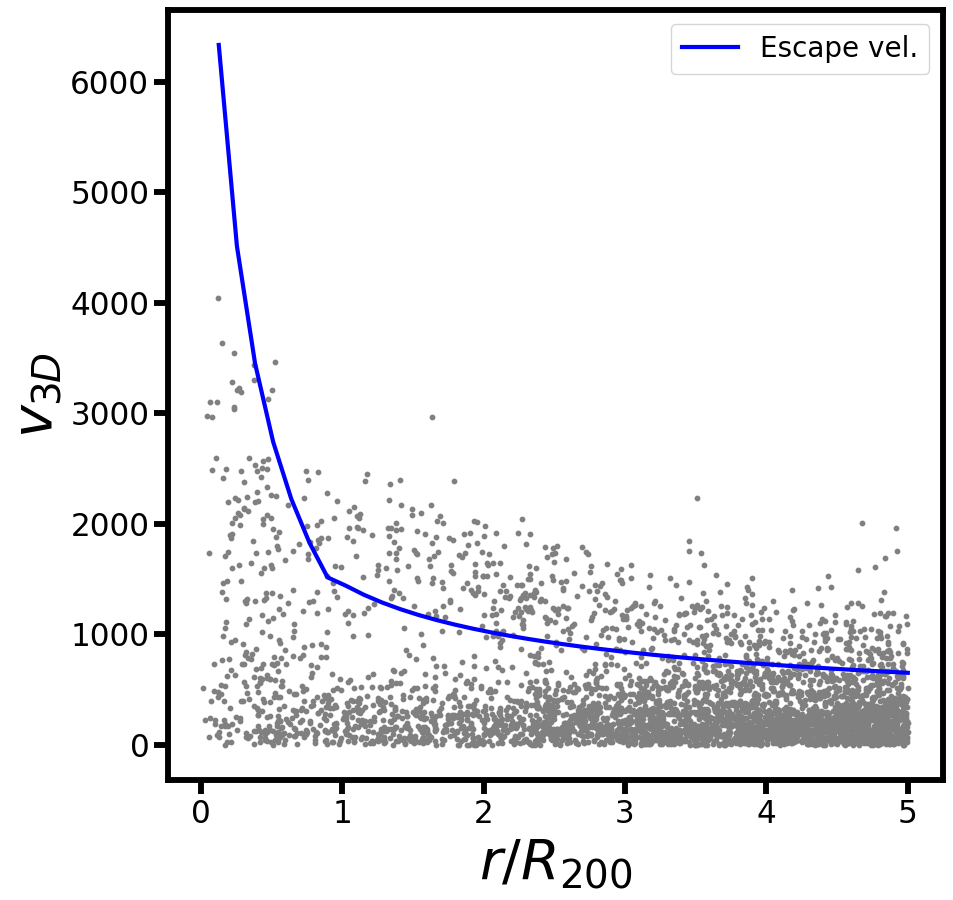

In [37]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(dist[mask_cluster_unbiased]/r200_deg, np.abs(v3D), s=10, marker="o", color="gray")

ax1.plot(np.linspace(0, 5*r200_deg, 40)/r200_deg, np.array([v_esc(r) for r in np.linspace(0, 5*r200_deg, 40)])[:, 0], 
                    ls="-", color="blue", lw=3, label="Escape vel.")


ax1.set_xlabel(r"$r/R_{200}$", fontdict=font)
ax1.set_ylabel(r"$v_{3D}$", fontdict=font)
# ax1.set_ylim(0, 1700)

ax1.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[pre_mask][~halo_mask_restricted][dist_field < max_dist], dec[pre_mask][~halo_mask_restricted][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax1.scatter(ra[pre_mask][mask_cluster_region][mask_infalling], dec[pre_mask][mask_cluster_region][mask_infalling], c="blue", label="Spectroscopially nearby galaxies")
ax1.set_title("Spectroscopically selected galaxies (Mock cluster {:d})".format(i_mock), fontsize=15)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.legend(fontsize=labelsize)
ax1.tick_params(axis='x', rotation=45)
ax1.invert_xaxis()

ax2.scatter(ra[pre_mask][~halo_mask_restricted][dist_field < max_dist], dec[pre_mask][~halo_mask_restricted][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], dec[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], c="blue", 
                label="Galaxies with P(C | zp) > {:.2f}".format(cut_zp))
ax2.set_title("Galaxies selected with P(C | zp) cut", fontsize=15)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax2.legend(fontsize=labelsize)
ax2.tick_params(axis='x', rotation=45)
ax2.invert_xaxis()

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|zp)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(z_phot_pdfs_unbiased[pre_mask][mask_cluster_region][mask_infalling], bins=z_bins, histtype='stepfilled', 
         color=colors3[1], alpha=0.5, label="photo-z of spec members (infalling)", range=[0, 0.7])
ax1.hist(z_phot_pdfs_unbiased[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], bins=z_bins, histtype='stepfilled', 
         color=colors3[4], alpha=0.5, label="photo-z of galaxies with P(C | zp) > {:.2f}".format(cut_zp), range=[0, 0.7])
ax1.hist(z_phot_pdfs_unbiased[pre_mask][mask_cluster_unbiased][np.isin(galaxyId[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], id_members_sigma_clipping)],
         bins=z_bins, histtype='stepfilled', 
         color=colors3[8], alpha=0.4, label="photo-z of galaxies at the intersection", range=[0, 0.7])

ax1.axvline(z_cluster - fz1*np.mean(sigma_z)*(1+z_cluster), color="red", ls='--')
ax1.axvline(z_cluster + fz1*np.mean(sigma_z)*(1+z_cluster), color="red", ls='--', label=r"$z_C \pm \alpha \times mean(\sigma_{NMAD})$")
ax1.axvline(z_cluster, color="red", label=r"$z_C$")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel(r"$z_p$", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)


bins = 50
ax2.hist(P_pz_C_array, bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=1.0)
ax2.set_xlabel("P(C|zp)", fontdict=font)
ax2.set_ylabel("Number of objects", fontdict=font)

fig.tight_layout(pad=4.0)

# plt.savefig("../figures/membership-testing-on-mocks/zp_and_probability_distribution_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

In [45]:
table = Table(scat)
table[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp].write("tables/testing-on-mocks/cluster-mock_{}_members-3sigma.csv".format(i_mock), format='csv', overwrite=True)

In [223]:
completeness_alpha = []
purity_alpha = []

fz_array = np.arange(1.0, 5.5, 0.5)

for fz in fz_array:
    mask_cluster = mask_cluster_region & (z_phot > z_cluster - fz*sigma_z*(1+z_cluster)) & (z_phot < z_cluster + fz*sigma_z*(1+z_cluster))
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster], galaxyId[halo_mask])) / len(galaxyId[mask_cluster])
    
    completeness_alpha.append(c)
    purity_alpha.append(p)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
ms = 10

ax1 = axs[0]
ax1.plot(fz_array, completeness_alpha, marker='o', color=colors1[2],label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(fz_array, purity_alpha, marker='o', color=colors1[5], label="Purity", markersize=ms, markeredgecolor="black")
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel(r"$\alpha$", fontdict=font)

c_best = 0.80
ax1.axhline(c_best, color="black", linestyle="dashed")
ax1.text(1.0, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

p_best = 0.03
ax1.axhline(p_best, color="black", linestyle="dashed")
ax1.text(1.0, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

cut_alpha = 2.5
ax1.axvline(cut_alpha, color="black")
ax1.text(x=cut_alpha-0.8, y=0.5, s=r"Cut at $\alpha =$ {:.2f}".format(cut_alpha), fontsize=15)


ax2 = axs[1]
ax2.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2], label="Completeness", markersize=ms, markeredgecolor="black")
ax2.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], label="Purity", markersize=ms, markeredgecolor="black")
ax2.set_xlabel("P(G|P(z)) cut", fontdict=font)
ax2.legend(fontsize=labelsize, loc=1)

# cut = 0.22
# ax2.axvline(cut, color="black")
# ax2.text(x=cut-0.26, y=0.5, s=r"Cut at $P(C|z_p) =$ {:.2f}".format(cut), fontsize=15)

ax2.axhline(c_best, color="black", linestyle="dashed")
ax2.text(0.06, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

ax2.axhline(p_best, color="black", linestyle="dashed")
ax2.text(0.06, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)


fig.tight_layout(pad=-0.7)

#### Selecting infalling galaxies in the mock using $R_{3D} < 5R_{200}$

In [176]:
distance_3D = np.sqrt((x - x0)**2 + (y - y0)**2 + (z - z0)**2)

infalling_mask = distance_3D < 5*r200_mpc.value

In [177]:
completeness_zp = []
purity_zp = []
d = 0.01
Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_zp:

    p = np.sum(np.isin(galaxyId[pre_mask][mask_cluster_unbiased][P_pz_C_array > Pmem_cut], galaxyId[infalling_mask])) / np.sum(P_pz_C_array > Pmem_cut)

    c = np.sum(np.isin(galaxyId[pre_mask][mask_cluster_unbiased][P_pz_C_array > Pmem_cut], galaxyId[infalling_mask])) / np.sum(infalling_mask)
    
    completeness_zp.append(c)
    purity_zp.append(p)

#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_zp = np.array(completeness_zp)
purity_zp = np.array(purity_zp)

F1_zp = 2 * completeness_zp*purity_zp/(completeness_zp + purity_zp)
F1_zp[np.isnan(F1_zp)] = 0

cut_zp = Pmem_cut_arr_zp[np.argmax(F1_zp)]

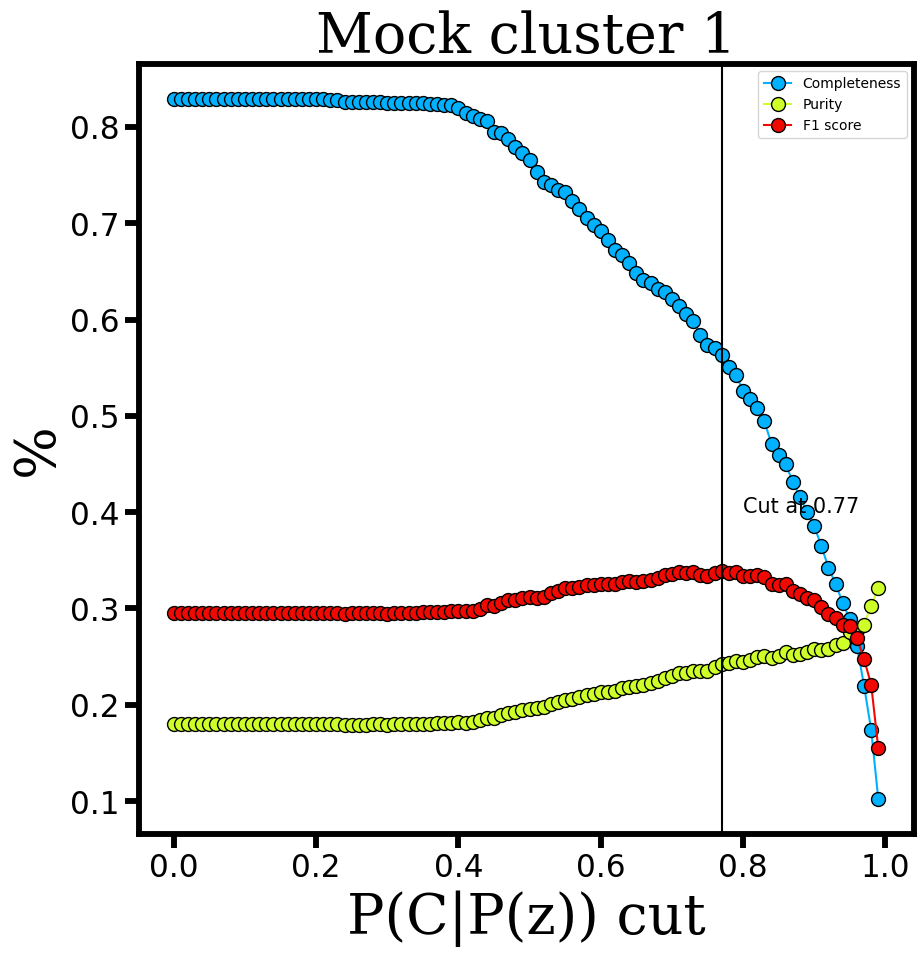

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2], label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, F1_zp, marker='o', color=colors1[8], label="F1 score", markersize=ms, markeredgecolor="black")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C|P(z)) cut", fontdict=font)

ax1.axvline(cut_zp, color="black")
ax1.text(x=cut_zp+0.03, y=0.4, s="Cut at {:.2f}".format(cut_zp), fontsize=15)

ax1.legend(fontsize=10)

# plt.savefig("../figures/membership-testing-on-mocks/purity-completeness_P(C|zp)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

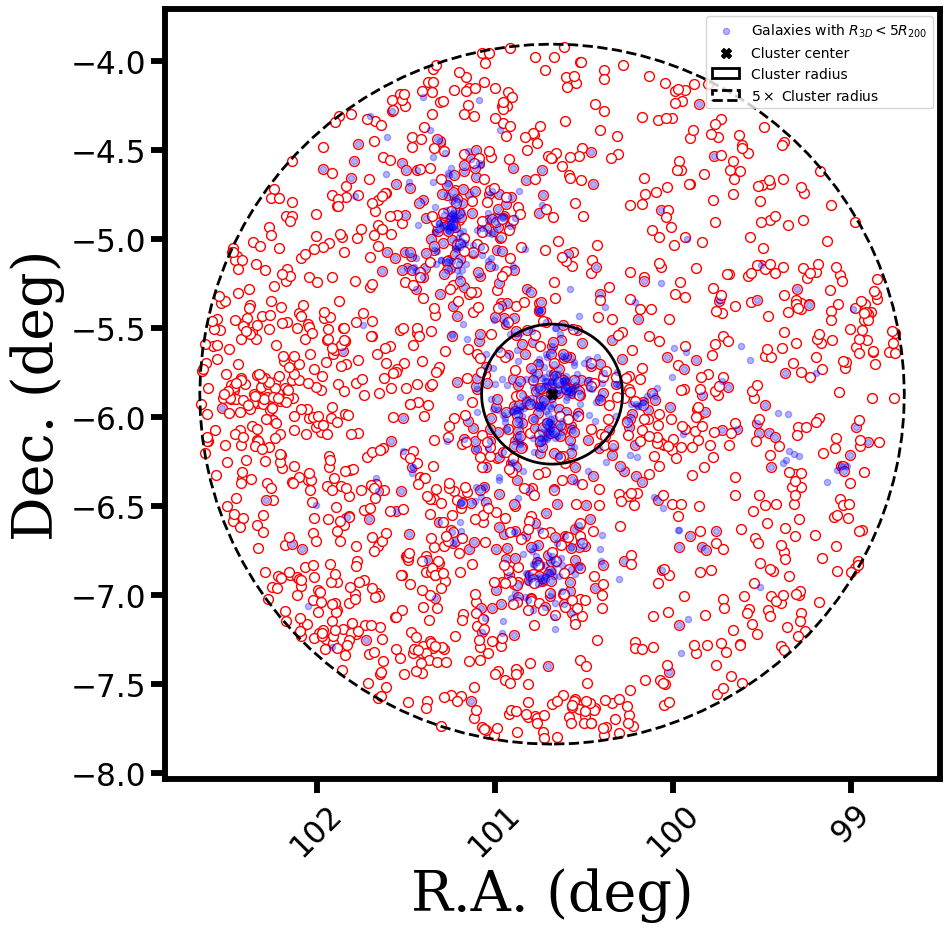

In [188]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(ra[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], dec[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], 
            c="white", s=50, edgecolor="red", label=r"")
ax1.scatter(ra[infalling_mask], dec[infalling_mask], c="blue", s=20, alpha=0.3, label=r"Galaxies with $R_{3D} < 5R_{200}$")

ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=50, color="k", label="Cluster center")

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=2, label="Cluster radius", edgecolor="k", facecolor="None")
ax1.add_patch(r1)
r2 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=2, label=r"$5 \times$ Cluster radius", edgecolor="k", facecolor="None", ls='--')
ax1.add_patch(r2)

ax1.legend(fontsize=10)
ax1.tick_params(axis='x', rotation=45)
ax1.invert_xaxis()

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|zp)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

## Cumulative elliptical density profile

In [ ]:
i_mock = 2

halo_id = halo_ids_list_unique[i_mock]
halo_mask = firstHaloinFoFGroupId == halo_id

halo_ra = ra[halo_mask]
halo_dec = dec[halo_mask]
halo_zphot = z_phot_pdfs_mock[halo_mask]
halo_zspec = z_spec[halo_mask]
halo_magr = magr[halo_mask]

#Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
ra0 = np.mean(halo_ra)
dec0 = np.mean(halo_dec)

z_bins = 20
bw = (halo_zspec.max() - halo_zspec.min()) / z_bins
kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
log_dens_zz = kde.score_samples(zz)
z_cluster = zz[np.argmax(np.exp(log_dens_zz))]

m200 = scat["m_crit200"][mask_good][halo_mask].max() * 1e10 * u.Msun / cosmo.h
r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
r200_mpc = r200.to(u.Mpc)
kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)
if i_mock == 0:
    r200_mpc = 2.9086829322414 * u.Mpc
    r200_deg = 0.13733324834507615 #deg

t = pd.read_csv("tables/testing-on-mocks/membership-mock-clusters/10-06-2025/fz1={}/cluster-mock_{}_members.csv".format(1.0, i_mock))
ra_selected = np.array(t["RA"]) #deg
dec_selected = np.array(t["DEC"]) #deg

/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [148]:
#Distribuição cumulativa observada
x = ra_selected
y = dec_selected

Rp = clustercentric_distance(x, y, ra0, dec0)
Hz, Rcz = np.histogram(Rp, bins=100, density=True)
dx1 = Rcz[1] - Rcz[0]
Fz = np.cumsum(Hz)*dx1

In [149]:
region_size = 5.0
xbin_size = region_size*100
ybin_size = region_size*100
xbins=xbin_size*1j
ybins=ybin_size*1j

dx2 = (x.max() - x.min()) / xbin_size
dy2 = (y.max() - y.min()) / ybin_size

#I approximate K as being the sqrt of the number of selected galaxies in the cluster
K = int(np.round(np.sqrt(len(x))))
xx, yy, zz = knn2D(np.deg2rad(x), np.deg2rad(y), K=K, xbins=xbins, ybins=ybins)

#I redefine the center of the cluster as the point with maximum density
ra0_new = np.rad2deg(xx[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dx2/2
dec0_new = np.rad2deg(yy[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dy2/2

xx_centered = np.rad2deg(xx) - ra0_new
yy_centered = np.rad2deg(yy) - dec0_new   

In [ ]:
#Existem algumas dificuldades de passar essas funções para o "galaxy_cluster_membership.py", a principal delas sendo que as quantidades "dx1", "dx2", e "dy2" precisam
#ser definidas localmente quando eu estou calculando a densidade cumulativa observada, enquanto que no "galaxy_cluster_membership.py" eu só estou definindo funções
#de maneira genérica, sem definir quantidades, ou seja, essas variáveis ficam lá sem ser definidas e dá erro.

#Distribuições cumulativas teóricas para o aglomerado e campo
#i) SIS; ii) SIS+ell; iii) NFW; iv) NFW+ell

def rho_SIS_(R, w1, w2, alpha):

    rho_c = 2 * np.pi * w1 * (R**(2 - alpha))/(2 - alpha)
    rho_f = np.pi * w2 * R**2
    rho = rho_c + rho_f

    return rho


def rho_SIS_ell_(x, y, R, w1, w2, alpha, q, theta):
    
    x_prime = x*np.cos(theta) - y*np.sin(theta)
    y_prime = x*np.sin(theta) + y*np.cos(theta)
    
    r = np.sqrt(x_prime**2 + y_prime**2/q**2)

    Sigma_c = w1 * r**(-alpha)  
    rho_c = np.array([np.sum(np.where(np.sqrt(x_prime**2 + y_prime**2/q**2) <= R[i], Sigma_c, 0)*dx2*dy2) for i in range(len(R))])
    rho_f = np.pi * w2 * R**2
    rho = rho_c + rho_f

    return rho


def rho_NFW_(R, rs, rho_s, w2):
    '''
    Parameters
    ----------
    theta : float
        Angle, in radians 
    '''
    
    x = R/rs
    rho_s *= 1e3 #For normalizing
    C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
    C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
    C = C_gt1 + C_lt1
        
    Sigma_c = 2*rs*rho_s/(x**2 - 1) * (1 - C/np.sqrt(np.abs(x**2 - 1)))
    
    rho_c = 2*np.pi*np.array([np.sum(Sigma_c[R < R[i]] * R[R < R[i]] * dx1) for i in range(len(R))])
    rho_f = np.pi * w2 * R**2
    rho = rho_c + rho_f
    
    return rho


def rho_NFW_ell_(x, y, R, rs, rho_s, w2, q, theta):
    '''
    Parameters
    ----------
    theta : float
        Angle, in radians 
    '''
    
    x_prime = x*np.cos(theta) - y*np.sin(theta)
    y_prime = x*np.sin(theta) + y*np.cos(theta)
    
    r = np.sqrt(x_prime**2 + y_prime**2/q**2)
    
    x = np.deg2rad(r)/rs
    C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
    C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
    C = C_gt1 + C_lt1
        
    Sigma_c = 2*rs*rho_s/(x**2 - 1) * (1 - C/np.sqrt(np.abs(x**2 - 1)))
    
    rho_c = np.array([np.sum(np.where(np.sqrt(x_prime**2 + y_prime**2/q**2) <= R[i], Sigma_c, 0)*dx2*dy2) for i in range(len(R))])
    rho_f = np.pi * w2 * R**2
    rho = rho_c + rho_f
    
    return rho

w1 = 0.07646509760140727, w2 = 5.74250030879186e-05, alpha = 0.908323506778033

Total processing time: 0.006902456283569336


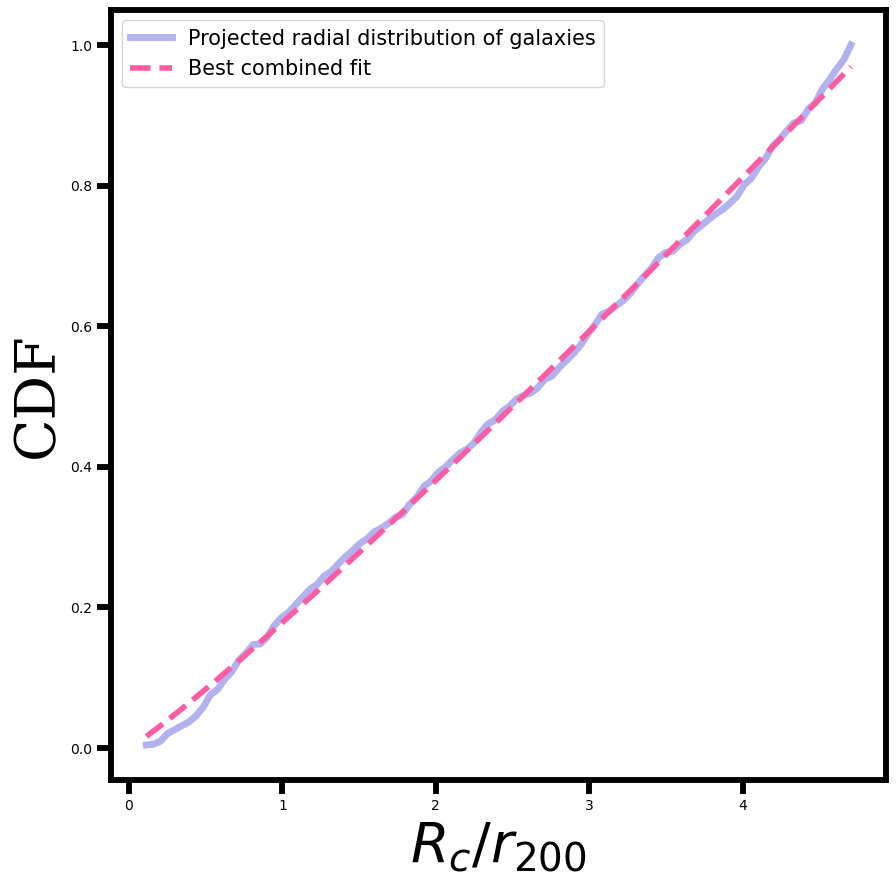

In [ ]:
params = curve_fit(rho_SIS_, Rcz[1:], Fz, bounds=((0, 0, 0), (np.inf, np.inf, np.inf)))[0]
w1, w2_SIS, alpha = params
print("w1 = {}, w2 = {}, alpha = {}".format(w1, w2_SIS, alpha))

rho_SIS = rho_SIS_(R=Rcz[1:], w1=w1, w2=w2_SIS, alpha=alpha)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)    
ax.plot(Rcz[1:]/r200_deg, Fz, lw=5.0, c=colors3[1], label="Projected radial distribution of galaxies", alpha=0.3)
ax.plot(Rcz[1:]/r200_deg, rho_SIS, lw=4.0, ls="--", label="Best combined fit", c=colors3[5])
ax.set_xlabel(r"$R_c/r_{200}$", fontdict=font)
ax.set_ylabel("CDF", fontdict=font)
ax.legend(fontsize=15)

/tmp/ipykernel_1785304/976212666.py:36: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_1785304/976212666.py:37: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)


rs = 0.3041560710642014, rho_s = 0.0011037652045764418, w2 = 0.032159906045617144


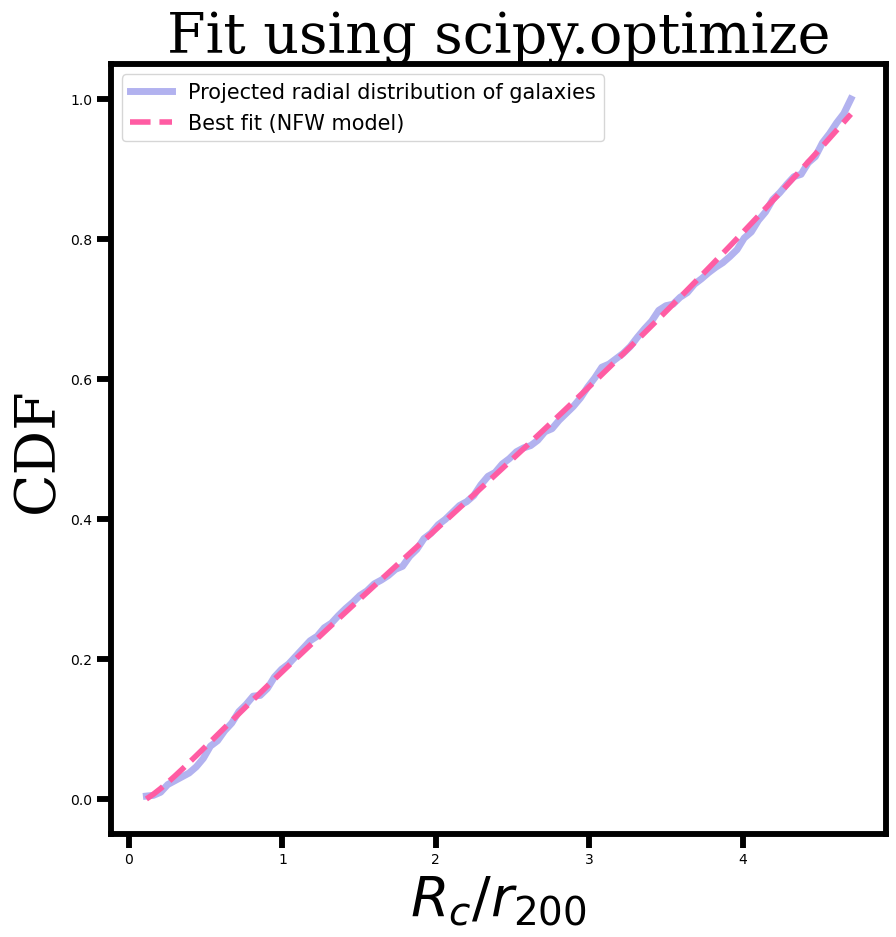

In [152]:
params = curve_fit(rho_NFW_, Rcz[1:], Fz, bounds=((0, 0, 0), (np.inf, np.inf, np.inf)))[0]
rs, rho_s, w2_NFW = params

if i_mock == 48:
    rs = 0.009
    rho_s = 21.8
    w2_NFW = 0.28

print("rs = {}, rho_s = {}, w2 = {}".format(rs, rho_s, w2_NFW))

rho_NFW = rho_NFW_(R=Rcz[1:], rs=rs, rho_s=rho_s, w2=w2_NFW)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)    
ax.plot(Rcz[1:]/r200_deg, Fz, lw=5.0, c=colors3[1], label="Projected radial distribution of galaxies", alpha=0.3)
ax.plot(Rcz[1:]/r200_deg, rho_NFW, lw=4.0, ls="--", label="Best fit (NFW model)", c=colors3[5])
ax.set_xlabel(r"$R_c/r_{200}$", fontdict=font)
ax.set_ylabel("CDF", fontdict=font)
ax.set_title("Fit using scipy.optimize", fontdict=font)
ax.legend(fontsize=15)

## MCMC with emcee

In [170]:
model = "SIS"
# model = "SIS_ell"
# model = "NFW"
# model = "NFW_ell"

def log_likelihood(params, x, y, R, data): 
    
    if model == "SIS":
        w1, w2, alpha = params 
        model_density = rho_SIS_(R, w1, w2, alpha)
        
    elif model == "SIS_ell":
        w1, w2, alpha, q, theta = params 
        model_density = rho_SIS_ell_(x, y, R, w1, w2, alpha, q, theta)
        
    elif model == "NFW":
        rs, rho_s, w2 = params 
        model_density = rho_NFW_(R, rs, rho_s, w2)
        
    elif model == "NFW_ell":
        rs, rho_s, w2, q, theta = params 
        model_density = rho_NFW_ell_(x, y, R, rs, rho_s, w2, q, theta)
    
    residuals = data - model_density
    sigma = np.sqrt(1/len(data) * (residuals)**2)
    
    # Assuming Gaussian noise, the log likelihood is proportional to the square of residuals
    return -0.5 * np.sum(residuals**2/sigma**2 + np.log(2 * np.pi * sigma**2)) * 0.2


# Define prior distributions (simple uniform priors in this case)
def log_prior(params):
    
    if model == "SIS":    
        w1, w2, alpha = params
        if 0 < w1 < 1 and 0 < w2 < 2 and 0 < alpha:
            return 0.0  # log(1) = 0, uniform prior
        return -np.inf  # log(0) = -inf, to reject parameters outside these ranges
    
    elif model == "SIS_ell":    
        w1, w2, alpha, q, theta = params
        if 0.5 < q < 1 and 0 < theta < np.pi and 0 < w1 < 1 and 0 < w2 < 2 and 0 < alpha:
            return 0.0  # log(1) = 0, uniform prior
        return -np.inf  # log(0) = -inf, to reject parameters outside these ranges
    
    elif model == "NFW":    
        rs, rho_s, w2 = params
        if 0 < rs < 1 and 0 < rho_s and 0 < w2 < 3:
            return 0.0  # log(1) = 0, uniform prior
        return -np.inf  # log(0) = -inf, to reject parameters outside these ranges
    
    elif model == "NFW_ell":    
        rs, rho_s, w2, q, theta = params
        if 0.5 < q < 1 and 0 < theta < np.pi and 0 < rs < 1 and 0 < rho_s and 0 < w2 < 3:
            return 0.0  # log(1) = 0, uniform prior
        return -np.inf  # log(0) = -inf, to reject parameters outside these ranges
    

def log_probability(params, x, y, R, data):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, R, data)


def run_mcmc(nsteps, pos, log_probability, args, moves, multi_process=False):

    nwalkers, ndim = pos.shape

    if multi_process == False:
        sampler = emcee.EnsembleSampler(
            nwalkers, 
            ndim, 
            log_probability, 
            args=args,
            moves=moves
        )
        sampler.run_mcmc(pos, nsteps, progress=True);

    elif multi_process == True:
        with Pool(processes=nwalkers) as pool:
            sampler = emcee.EnsembleSampler(
                nwalkers,
                ndim,
                log_probability,
                args=args,
                pool=pool
                )
            
            start = time.time()

            sampler.run_mcmc(pos, nsteps, progress=True)
            
            end = time.time()
            multi_time = end - start
            print("Multiprocessing took {0:.1f} seconds".format(multi_time))

    return sampler

In [154]:
#Let's try to minimize the -log_likelihood associated to the models
#This is to kind of determine the initial values for the parameters when initializing the chains
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)

if model == "SIS": 
    initial = np.array([w1, w2_SIS, alpha]) + 0.01 * np.random.randn(3)
    soln = minimize(nll, initial, args=(xx_centered, yy_centered, Rcz[1:], Fz))

elif model == "SIS_ell": 
    initial = np.array([w1, w2_SIS, alpha, 0.75, np.pi/2]) + np.array([0.01, 0.01, 0.01, 0.1, 0.3]) * np.random.randn(5)
    soln = minimize(nll, initial, args=(xx_centered, yy_centered, Rcz[1:], Fz))

elif model == "NFW": 
    initial = np.array([rs, rho_s, w2_NFW]) + 0.001 * np.random.randn(3)
    soln = minimize(nll, initial, bounds=[(0, np.inf), (0, np.inf), (0, np.inf)], args=(xx_centered, yy_centered, Rcz[1:], Fz))

/tmp/ipykernel_1785304/976212666.py:36: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_1785304/976212666.py:37: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)


In [155]:
nsteps = 100000
nwalkers = 32
burn_in = 0.2

pos = soln.x + 1e-4 * np.random.randn(nwalkers, len(soln.x))

if model == "SIS":
    sampler = run_mcmc(nsteps, 
                       pos,
                       log_probability, 
                       args=(xx_centered, yy_centered, Rcz[1:], Fz), 
                       moves=emcee.moves.StretchMove(),
                       multi_process=False)
    
    labels = [r"$w_1$", r"$w_2$", r"$\alpha$"]


elif model == "NFW":
    nsteps0=20000
    sampler0 = run_mcmc(nsteps0, 
                       pos,
                       log_probability, 
                       args=(xx_centered, yy_centered, Rcz[1:], Fz), 
                       moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)],
                       multi_process=False)
    
    flat_samples = sampler0.get_chain(discard=int(nsteps0*burn_in), thin=15, flat=True)
    means = np.mean(flat_samples, axis=0)

    pos2 = means + 1e-4 * np.random.randn(nwalkers, len(means))
    sampler = run_mcmc(nsteps, 
                       pos2,
                       log_probability, 
                       args=(xx_centered, yy_centered, Rcz[1:], Fz), 
                       moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)],
                       multi_process=False)
    
    labels = [r"$r_s$", r"$\rho_s$", r"$w_2$"]


samples = sampler.get_chain()

#flat = flatten the chains across the ensample
#discard = discard the burn_in phase
#thin = "thins" the sample every N iterations (for instance 15)
flat_samples = sampler.get_chain(discard=int(nsteps*burn_in), thin=15, flat=True)
means = np.mean(flat_samples, axis=0)


/tmp/ipykernel_1785304/976212666.py:36: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_1785304/976212666.py:37: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
100%|██████████| 100000/100000 [41:01<00:00, 40.62it/s]


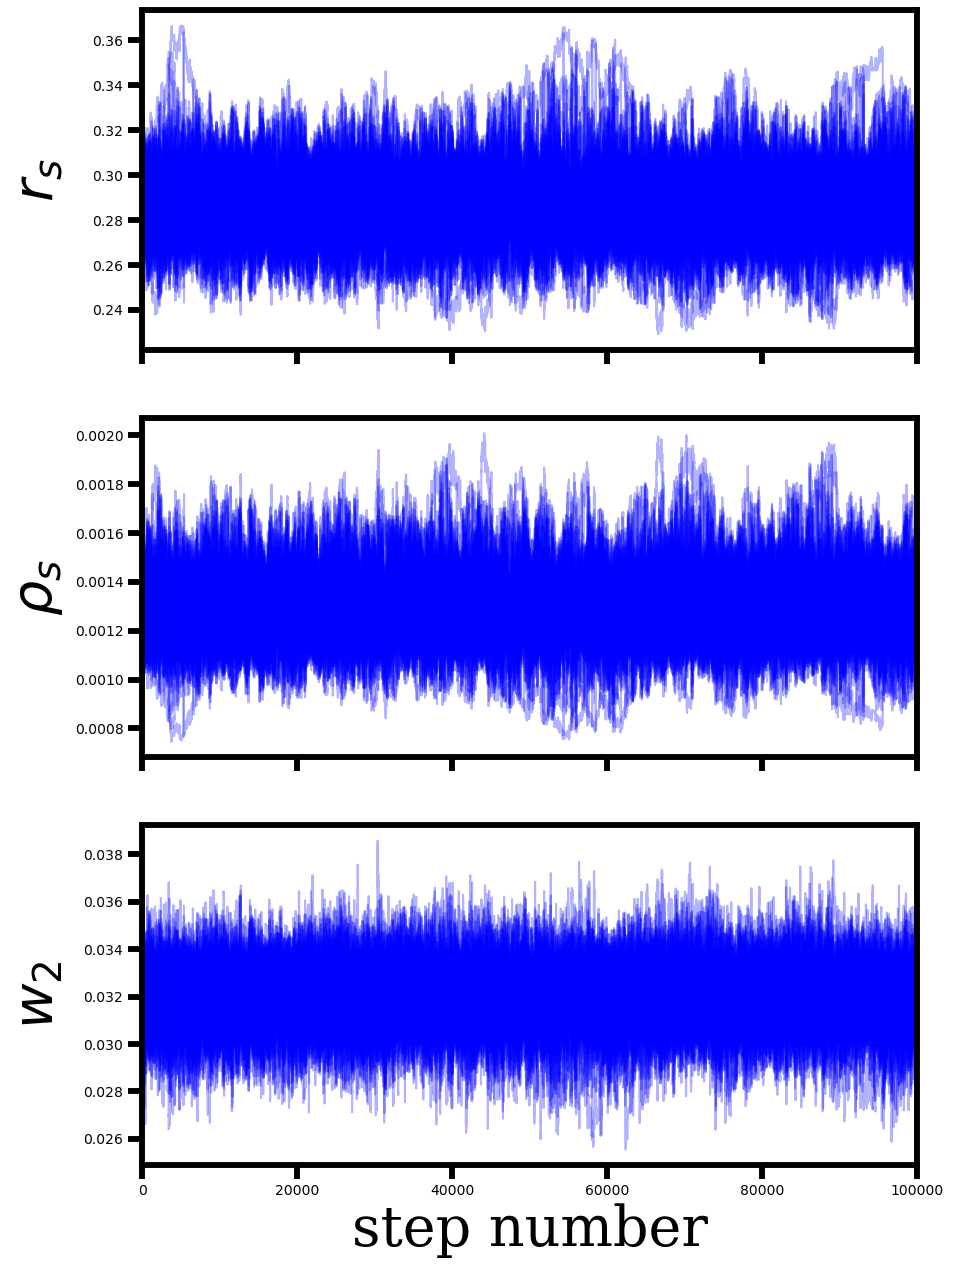

In [157]:
fig, axes = plt.subplots(3, figsize=(10, 15), sharex=True)

# Styling
rcParams["font.size"] = 10
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 10
rcParams["ytick.labelsize"] = 10
for i in range(np.shape(pos)[1]):
    ax = axes[i]
    ax.plot(samples[:, :, i], "blue", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontdict=font)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontdict=font);

plt.savefig("../figures/elliptical_profiles/SIS_SISell_NFW_NFWell_17-06-2025/trace_plot_mcmc_mock{}_model{}_{}iterations.png".format(i_mock, model, nsteps),
                                     dpi='figure', format='png')

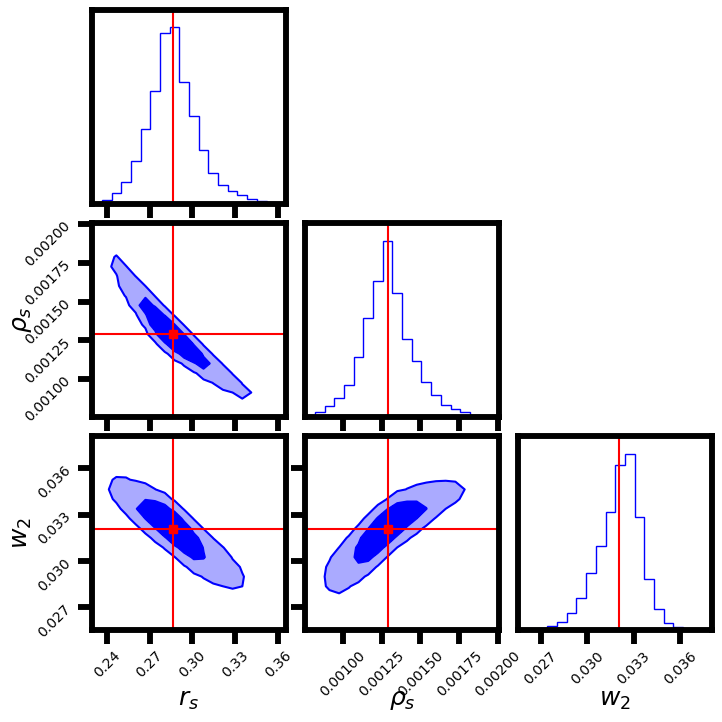

In [158]:
# Generate corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=means,
    truth_color="red",
    truth_kwargs={"lw": 2, "ls": "--"},
    label_kwargs={"fontsize": 18},
    color="blue",
    levels=[0.68, 0.95],
    smooth=0.5,
    fill_contours=True,
    plot_datapoints=False,
)

# Adjust spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig("../figures/elliptical_profiles/SIS_SISell_NFW_NFWell_17-06-2025/corner_plot_mcmc_mock{}_model{}_{}iterations.png".format(i_mock, model, nsteps),
                                     dpi='figure', format='png')

In [159]:
#Saving results
results = {
    "samples": samples,
    "flat_samples": flat_samples
}

with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/23-06-2025/results_{}_mock{}-{}chains_{}_iterations.txt'.
          format(model, i_mock, nwalkers, nsteps), 'wb') as f:
    pickle.dump(results, f)

#### Loop (can possibly delete this afterwards)

In [ ]:
# converged well for NFW: 0, 2
# did not converge for NFW: 1
# curve_fit cannot find best parameters for NFW: 3
# no major problems with SIS so far

In [ ]:
nsteps = 100000
nwalkers = 32
burn_in = 0.2


for i_mock in np.arange(0, 50, 1):

    halo_id = halo_ids_list_unique[i_mock]
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot_pdfs_mock[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]

    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)

    z_bins = 20
    bw = (halo_zspec.max() - halo_zspec.min()) / z_bins
    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
    zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
    log_dens_zz = kde.score_samples(zz)
    z_cluster = zz[np.argmax(np.exp(log_dens_zz))]

    m200 = scat["m_crit200"][mask_good][halo_mask].max() * 1e10 * u.Msun / cosmo.h
    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)
    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)
    if i_mock == 0:
        r200_mpc = 2.9086829322414 * u.Mpc
        r200_deg = 0.13733324834507615 #deg

    t = pd.read_csv("tables/testing-on-mocks/membership-mock-clusters/10-06-2025/fz1={}/cluster-mock_{}_members.csv".format(1.0, i_mock))
    ra_selected = np.array(t["RA"])
    dec_selected = np.array(t["DEC"])

    #Distribuição cumulativa observada
    x = ra_selected
    y = dec_selected

    Rp = clustercentric_distance(x, y, ra0, dec0)
    Hz, Rcz = np.histogram(Rp, bins=100, density=True)
    dx1 = Rcz[1] - Rcz[0]
    Fz = np.cumsum(Hz)*dx1

    region_size = 5.0
    xbin_size = region_size*100
    ybin_size = region_size*100
    xbins=xbin_size*1j
    ybins=ybin_size*1j

    dx2 = (x.max() - x.min()) / xbin_size
    dy2 = (y.max() - y.min()) / ybin_size

    #I approximate K as being the sqrt of the number of selected galaxies in the cluster
    K = int(np.round(np.sqrt(len(x))))
    xx, yy, zz = knn2D(np.deg2rad(x), np.deg2rad(y), K=K, xbins=xbins, ybins=ybins)

    #I redefine the center of the cluster as the point with maximum density
    ra0_new = np.rad2deg(xx[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dx2/2
    dec0_new = np.rad2deg(yy[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dy2/2

    xx_centered = np.rad2deg(xx) - ra0_new
    yy_centered = np.rad2deg(yy) - dec0_new   

    params = curve_fit(rho_SIS_, Rcz[1:], Fz, bounds=((0, 0, 0), (np.inf, np.inf, np.inf)))[0]
    w1, w2_SIS, alpha = params
    print("w1 = {}, w2 = {}, alpha = {}".format(w1, w2_SIS, alpha))

    rho_SIS = rho_SIS_(R=Rcz[1:], w1=w1, w2=w2_SIS, alpha=alpha)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)    
    ax.plot(Rcz[1:]/r200_deg, Fz, lw=5.0, c=colors3[1], label="Projected radial distribution of galaxies", alpha=0.3)
    ax.plot(Rcz[1:]/r200_deg, rho_SIS, lw=4.0, ls="--", label="Best combined fit", c=colors3[5])
    ax.set_xlabel(r"$R_c/r_{200}$", fontdict=font)
    ax.set_ylabel("CDF", fontdict=font)
    ax.legend(fontsize=15)


    # params = curve_fit(rho_NFW_, Rcz[1:], Fz, bounds=((0, 0, 0), (np.inf, np.inf, np.inf)))[0]
    # rs, rho_s, w2_NFW = params

    # if i_mock == 48:
    #     rs = 0.009
    #     rho_s = 21.8
    #     w2_NFW = 0.28

    # print("rs = {}, rho_s = {}, w2 = {}".format(rs, rho_s, w2_NFW))

    # rho_NFW = rho_NFW_(R=Rcz[1:], rs=rs, rho_s=rho_s, w2=w2_NFW)

    # fig = plt.figure(figsize=(10, 10))
    # ax = fig.add_subplot(111)    
    # ax.plot(Rcz[1:]/r200_deg, Fz, lw=5.0, c=colors3[1], label="Projected radial distribution of galaxies", alpha=0.3)
    # ax.plot(Rcz[1:]/r200_deg, rho_NFW, lw=4.0, ls="--", label="Best fit (NFW model)", c=colors3[5])
    # ax.set_xlabel(r"$R_c/r_{200}$", fontdict=font)
    # ax.set_ylabel("CDF", fontdict=font)
    # ax.set_title("Fit using scipy.optimize", fontdict=font)
    # ax.legend(fontsize=15)

    
    plt.savefig("../figures/elliptical_profiles/SIS_SISell_NFW_NFWell_17-06-2025/scipy_preliminary_fit_mock{}_model{}_{}iterations.png".format(i_mock, model, nsteps),
                                        dpi='figure', format='png')


    #ANTES DISSO AQUI TEM QUE LEMBRAR DE RODAR A CÉLULA LÁ EM CIMA COM AS DEFINIÇÕES DAS FUNÇÕES PRO MCMC E DO MODELO A SER CONSIDERADO
    #Let's try to minimize the -log_likelihood associated to the models
    #This is to kind of determine the initial values for the parameters when initializing the chains
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)

    if model == "SIS": 
        initial = np.array([w1, w2_SIS, alpha]) + 0.01 * np.random.randn(3)
        soln = minimize(nll, initial, args=(xx_centered, yy_centered, Rcz[1:], Fz))

    elif model == "SIS_ell": 
        initial = np.array([w1, w2_SIS, alpha, 0.75, np.pi/2]) + np.array([0.01, 0.01, 0.01, 0.1, 0.3]) * np.random.randn(5)
        soln = minimize(nll, initial, args=(xx_centered, yy_centered, Rcz[1:], Fz))

    elif model == "NFW": 
        initial = np.array([rs, rho_s, w2_NFW]) + 0.001 * np.random.randn(3)
        soln = minimize(nll, initial, bounds=[(0, np.inf), (0, np.inf), (0, np.inf)], args=(xx_centered, yy_centered, Rcz[1:], Fz))

    pos = soln.x + 1e-4 * np.random.randn(nwalkers, len(soln.x))

    if model == "SIS":
        sampler = run_mcmc(nsteps, 
                        pos,
                        log_probability, 
                        args=(xx_centered, yy_centered, Rcz[1:], Fz), 
                        moves=emcee.moves.StretchMove(),
                        multi_process=False)
        
        labels = [r"$w_1$", r"$w_2$", r"$\alpha$"]


    elif model == "NFW":
        nsteps0=20000
        sampler0 = run_mcmc(nsteps0, 
                        pos,
                        log_probability, 
                        args=(xx_centered, yy_centered, Rcz[1:], Fz), 
                        moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)],
                        multi_process=False)
        
        flat_samples = sampler0.get_chain(discard=int(nsteps0*burn_in), thin=15, flat=True)
        means = np.mean(flat_samples, axis=0)

        pos2 = means + 1e-4 * np.random.randn(nwalkers, len(means))
        sampler = run_mcmc(nsteps, 
                        pos2,
                        log_probability, 
                        args=(xx_centered, yy_centered, Rcz[1:], Fz), 
                        moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)],
                        multi_process=False)
        
        labels = [r"$r_s$", r"$\rho_s$", r"$w_2$"]


    samples = sampler.get_chain()

    #flat = flatten the chains across the ensample
    #discard = discard the burn_in phase
    #thin = "thins" the sample every N iterations (for instance 15)
    flat_samples = sampler.get_chain(discard=int(nsteps*burn_in), thin=15, flat=True)
    means = np.mean(flat_samples, axis=0)

    fig, axes = plt.subplots(3, figsize=(10, 15), sharex=True)
    # Styling
    rcParams["font.size"] = 10
    rcParams["axes.labelsize"] = 10
    rcParams["xtick.labelsize"] = 10
    rcParams["ytick.labelsize"] = 10
    for i in range(np.shape(pos)[1]):
        ax = axes[i]
        ax.plot(samples[:, :, i], "blue", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i], fontdict=font)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number", fontdict=font);

    plt.savefig("../figures/elliptical_profiles/SIS_SISell_NFW_NFWell_17-06-2025/trace_plot_mcmc_mock{}_model{}_{}iterations.png".format(i_mock, model, nsteps),
                                        dpi='figure', format='png')


    # Generate corner plot
    fig = corner.corner(
        flat_samples,
        labels=labels,
        truths=means,
        truth_color="red",
        truth_kwargs={"lw": 2, "ls": "--"},
        label_kwargs={"fontsize": 18},
        color="blue",
        levels=[0.68, 0.95],
        smooth=0.5,
        fill_contours=True,
        plot_datapoints=False,
    )

    # Adjust spacing
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.savefig("../figures/elliptical_profiles/SIS_SISell_NFW_NFWell_17-06-2025/corner_plot_mcmc_mock{}_model{}_{}iterations.png".format(i_mock, model, nsteps),
                                        dpi='figure', format='png')


    #Saving results
    results = {
        "samples": samples,
        "flat_samples": flat_samples
    }

    with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/23-06-2025/results_{}_mock{}-{}chains_{}_iterations.txt'.
            format(model, i_mock, nwalkers, nsteps), 'wb') as f:
        pickle.dump(results, f)

### Testing the convergence of chains

In [140]:
#R-hat test from arviz
idata = az.from_emcee(sampler)
print(az.rhat(idata))  # Should be <1.01 for all parameters


<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    var_0    float64 8B 1.031
    var_1    float64 8B 1.031
    var_2    float64 8B 1.019


In [142]:
#Autocorrelation time from emcee, but I am not sure how to interpret this
tau = emcee.autocorr.integrated_time(samples, quiet=True)
print(f"Autocorrelation time: {tau}")
print(f"Estimated nsteps for convergence: {50*tau}")

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [2595.7358587  2920.9759438  2132.37535056]


Autocorrelation time: [2595.7358587  2920.9759438  2132.37535056]
Estimated nsteps for convergence: [129786.79293483 146048.79719024 106618.76752785]


## MCMC Metropolis-Hastings approach

In [ ]:
#Metropolis-Hastings

# Parameters
niter = 1000000  # Number of iterations per chain
burn_in = 0.3  # Burn-in fraction

t0 = time.time()

model = "SIS"
# model = "SIS_ell"
# model = "NFW"
# model = "NFW_ell"

#Initial guess for parameters
if model == "SIS": initial_params = [w1, w2_SIS, alpha] #values from scipy for w1, w2, alpha
elif model == "SIS_ell": initial_params = [w1, w2_SIS, alpha, 0.75, np.pi/2] #values from scipy for w1, w2, alpha
elif model == "NFW": initial_params = [rs, rho_s, w2_NFW] #values from scipy for rs, rho_s, w2
elif model == "NFW_ell": initial_params = [rs, rho_s, w2_NFW, 0.75, np.pi/2] #values from scipy for rs, rho_s, w2
sp = 0.01*np.array(initial_params)


def transition_model(params, sp):
    return [np.random.normal(params[i], scale=sp[i], size=(1,))[0] for i in range(len(params))]


def log_likelihood(params, x, y, R, data): 
    
    if model == "SIS":
        w1, w2, alpha = params 
        model_density = rho_SIS_(R, w1, w2, alpha)
        
    elif model == "SIS_ell":
        w1, w2, alpha, q, theta = params 
        model_density = rho_SIS_ell_(x, y, R, w1, w2, alpha, q, theta)
        
    elif model == "NFW":
        rs, rho_s, w2 = params 
        model_density = rho_NFW_(R, rs, rho_s, w2)
        
    elif model == "NFW_ell":
        rs, rho_s, w2, q, theta = params 
        model_density = rho_NFW_ell_(x, y, R, rs, rho_s, w2, q, theta)
    
    residuals = data - model_density
    sigma = np.sqrt(1/len(data) * (residuals)**2)
    
    # Assuming Gaussian noise, the log likelihood is proportional to the square of residuals
    return -0.5 * np.sum(residuals**2/sigma**2 + np.log(2 * np.pi * sigma**2)) * 0.2


# Define prior distributions (simple uniform priors in this case)
def log_prior(params):
    
    if model == "SIS":    
        w1, w2, alpha = params
        if 0 < w1 < 1 and 0 < w2 < 2 and 0 < alpha:
            return 0.0  # log(1) = 0, uniform prior
        return -np.inf  # log(0) = -inf, to reject parameters outside these ranges
    
    elif model == "SIS_ell":    
        w1, w2, alpha, q, theta = params
        if 0.5 < q < 1 and 0 < theta < np.pi and 0 < w1 < 1 and 0 < w2 < 2 and 0 < alpha:
            return 0.0  # log(1) = 0, uniform prior
        return -np.inf  # log(0) = -inf, to reject parameters outside these ranges
    
    elif model == "NFW":    
        rs, rho_s, w2 = params
        if 0 < rs < 1 and 0 < rho_s and 0 < w2 < 3:
            return 0.0  # log(1) = 0, uniform prior
        return -np.inf  # log(0) = -inf, to reject parameters outside these ranges
    
    elif model == "NFW_ell":    
        rs, rho_s, w2, q, theta = params
        if 0.5 < q < 1 and 0 < theta < np.pi and 0 < rs < 1 and 0 < rho_s and 0 < w2 < 3:
            return 0.0  # log(1) = 0, uniform prior
        return -np.inf  # log(0) = -inf, to reject parameters outside these ranges


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new - x)))
    

    
def metropolis_hastings(likelihood, prior, transition_model, param_init, iterations, x, y, R, data, acceptance_rule, sp):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample

    #whether or not you should recalculate the new likelihood, should only be one if p has changed
    should_recalculate = True
    
    p = param_init
    accepted = []
    rejected = []
    log_likelihood_old = []
    log_likelihood_new = []
    
    flag = False
    for i in tqdm.tqdm(range(iterations)):
        if i > iterations/2 and flag == True: 
            sp = sp * 0.3
            flag = False
        
        #ideia do yuri, sp*np.random.random(0, 1)
        p_new =  transition_model(p, sp)   
        
        if(should_recalculate):
            p_like = likelihood(p, x, y, R, data)
        p_new_like = likelihood(p_new, x, y, R, data) 
        log_likelihood_new.append(p_new_like)
        log_likelihood_old.append(p_like)
        
        if (acceptance(p_like + prior(p), p_new_like + prior(p_new))):            
            p = p_new
            accepted.append(p_new + [i])
            should_recalculate = True
        else:
            should_recalculate = False
            rejected.append(p_new + [i])            
                
    return np.array(accepted), np.array(rejected), np.array(log_likelihood_old), np.array(log_likelihood_new)

### Multiple chains run

In [218]:
def run_chain(seed, likelihood, prior, transition_model, param_init, iterations, x, y, R, data, acceptance_rule, sp):
    np.random.seed(seed)  # Ensure reproducibility for this chain
    accepted, rejected, likelihood_old, likelihood_new = metropolis_hastings(
        likelihood=likelihood,
        prior=prior,
        transition_model=transition_model,
        param_init=param_init,
        iterations=iterations,
        x=x,
        y=y,
        R=R,
        data=data,
        acceptance_rule=acceptance_rule,
        sp=sp
    )
    return {
        "seed": seed,
        "accepted": accepted,
        "rejected": rejected,
        "likelihood_old": likelihood_old,
        "likelihood_new": likelihood_new
    }


def run_parallel_chains(num_chains, likelihood, prior, transition_model, param_init, iterations, x, y, R, data, acceptance_rule, sp):
    
    seeds = [42 + i for i in range(num_chains)] 
    
    args = [(seed, likelihood, prior, transition_model, param_init, iterations, x, y, R, data, acceptance_rule, sp) 
            for seed in seeds]
    
    with Pool(num_chains) as pool:
        results = list(tqdm.tqdm(pool.starmap(run_chain, args), total=num_chains))
    
    return results

In [ ]:
t0 = time.time()
num_chains = 30  # Number of chains to run

# Run the chains
results = run_parallel_chains(
    num_chains=num_chains,
    likelihood=log_likelihood,
    prior=log_prior,
    transition_model=transition_model,
    param_init=initial_params,
    iterations=niter,
    x=xx_centered,
    y=yy_centered,
    R=Rcz[1:],
    data=Fz,
    acceptance_rule=acceptance,
    sp=sp
)


# Combine and analyze results
for i, result in enumerate(results):
    print(f"\nChain {i + 1} (Seed: {result['seed']}):")
    print(f"Number of accepted samples: {len(result['accepted'])}")
    print(f"Acceptance rate: {len(result['accepted']) / niter * 100:.2f}%. This number should be around 30%")

print("\nTotal processing time:", time.time() - t0)

# Example: Combine all accepted samples from the chains
all_accepted = np.vstack([result["accepted"] for result in results])
print(f"\nTotal accepted samples across all chains: {len(all_accepted)}")

100%|██████████| 30/30 [00:00<00:00, 574562.19it/s]



Chain 1 (Seed: 42):
Number of accepted samples: 80534
Acceptance rate: 8.05%. This number should be around 30%

Chain 2 (Seed: 43):
Number of accepted samples: 82013
Acceptance rate: 8.20%. This number should be around 30%

Chain 3 (Seed: 44):
Number of accepted samples: 80869
Acceptance rate: 8.09%. This number should be around 30%

Chain 4 (Seed: 45):
Number of accepted samples: 80550
Acceptance rate: 8.05%. This number should be around 30%

Chain 5 (Seed: 46):
Number of accepted samples: 82944
Acceptance rate: 8.29%. This number should be around 30%

Chain 6 (Seed: 47):
Number of accepted samples: 82923
Acceptance rate: 8.29%. This number should be around 30%

Chain 7 (Seed: 48):
Number of accepted samples: 82459
Acceptance rate: 8.25%. This number should be around 30%

Chain 8 (Seed: 49):
Number of accepted samples: 81023
Acceptance rate: 8.10%. This number should be around 30%

Chain 9 (Seed: 50):
Number of accepted samples: 81268
Acceptance rate: 8.13%. This number should be aro

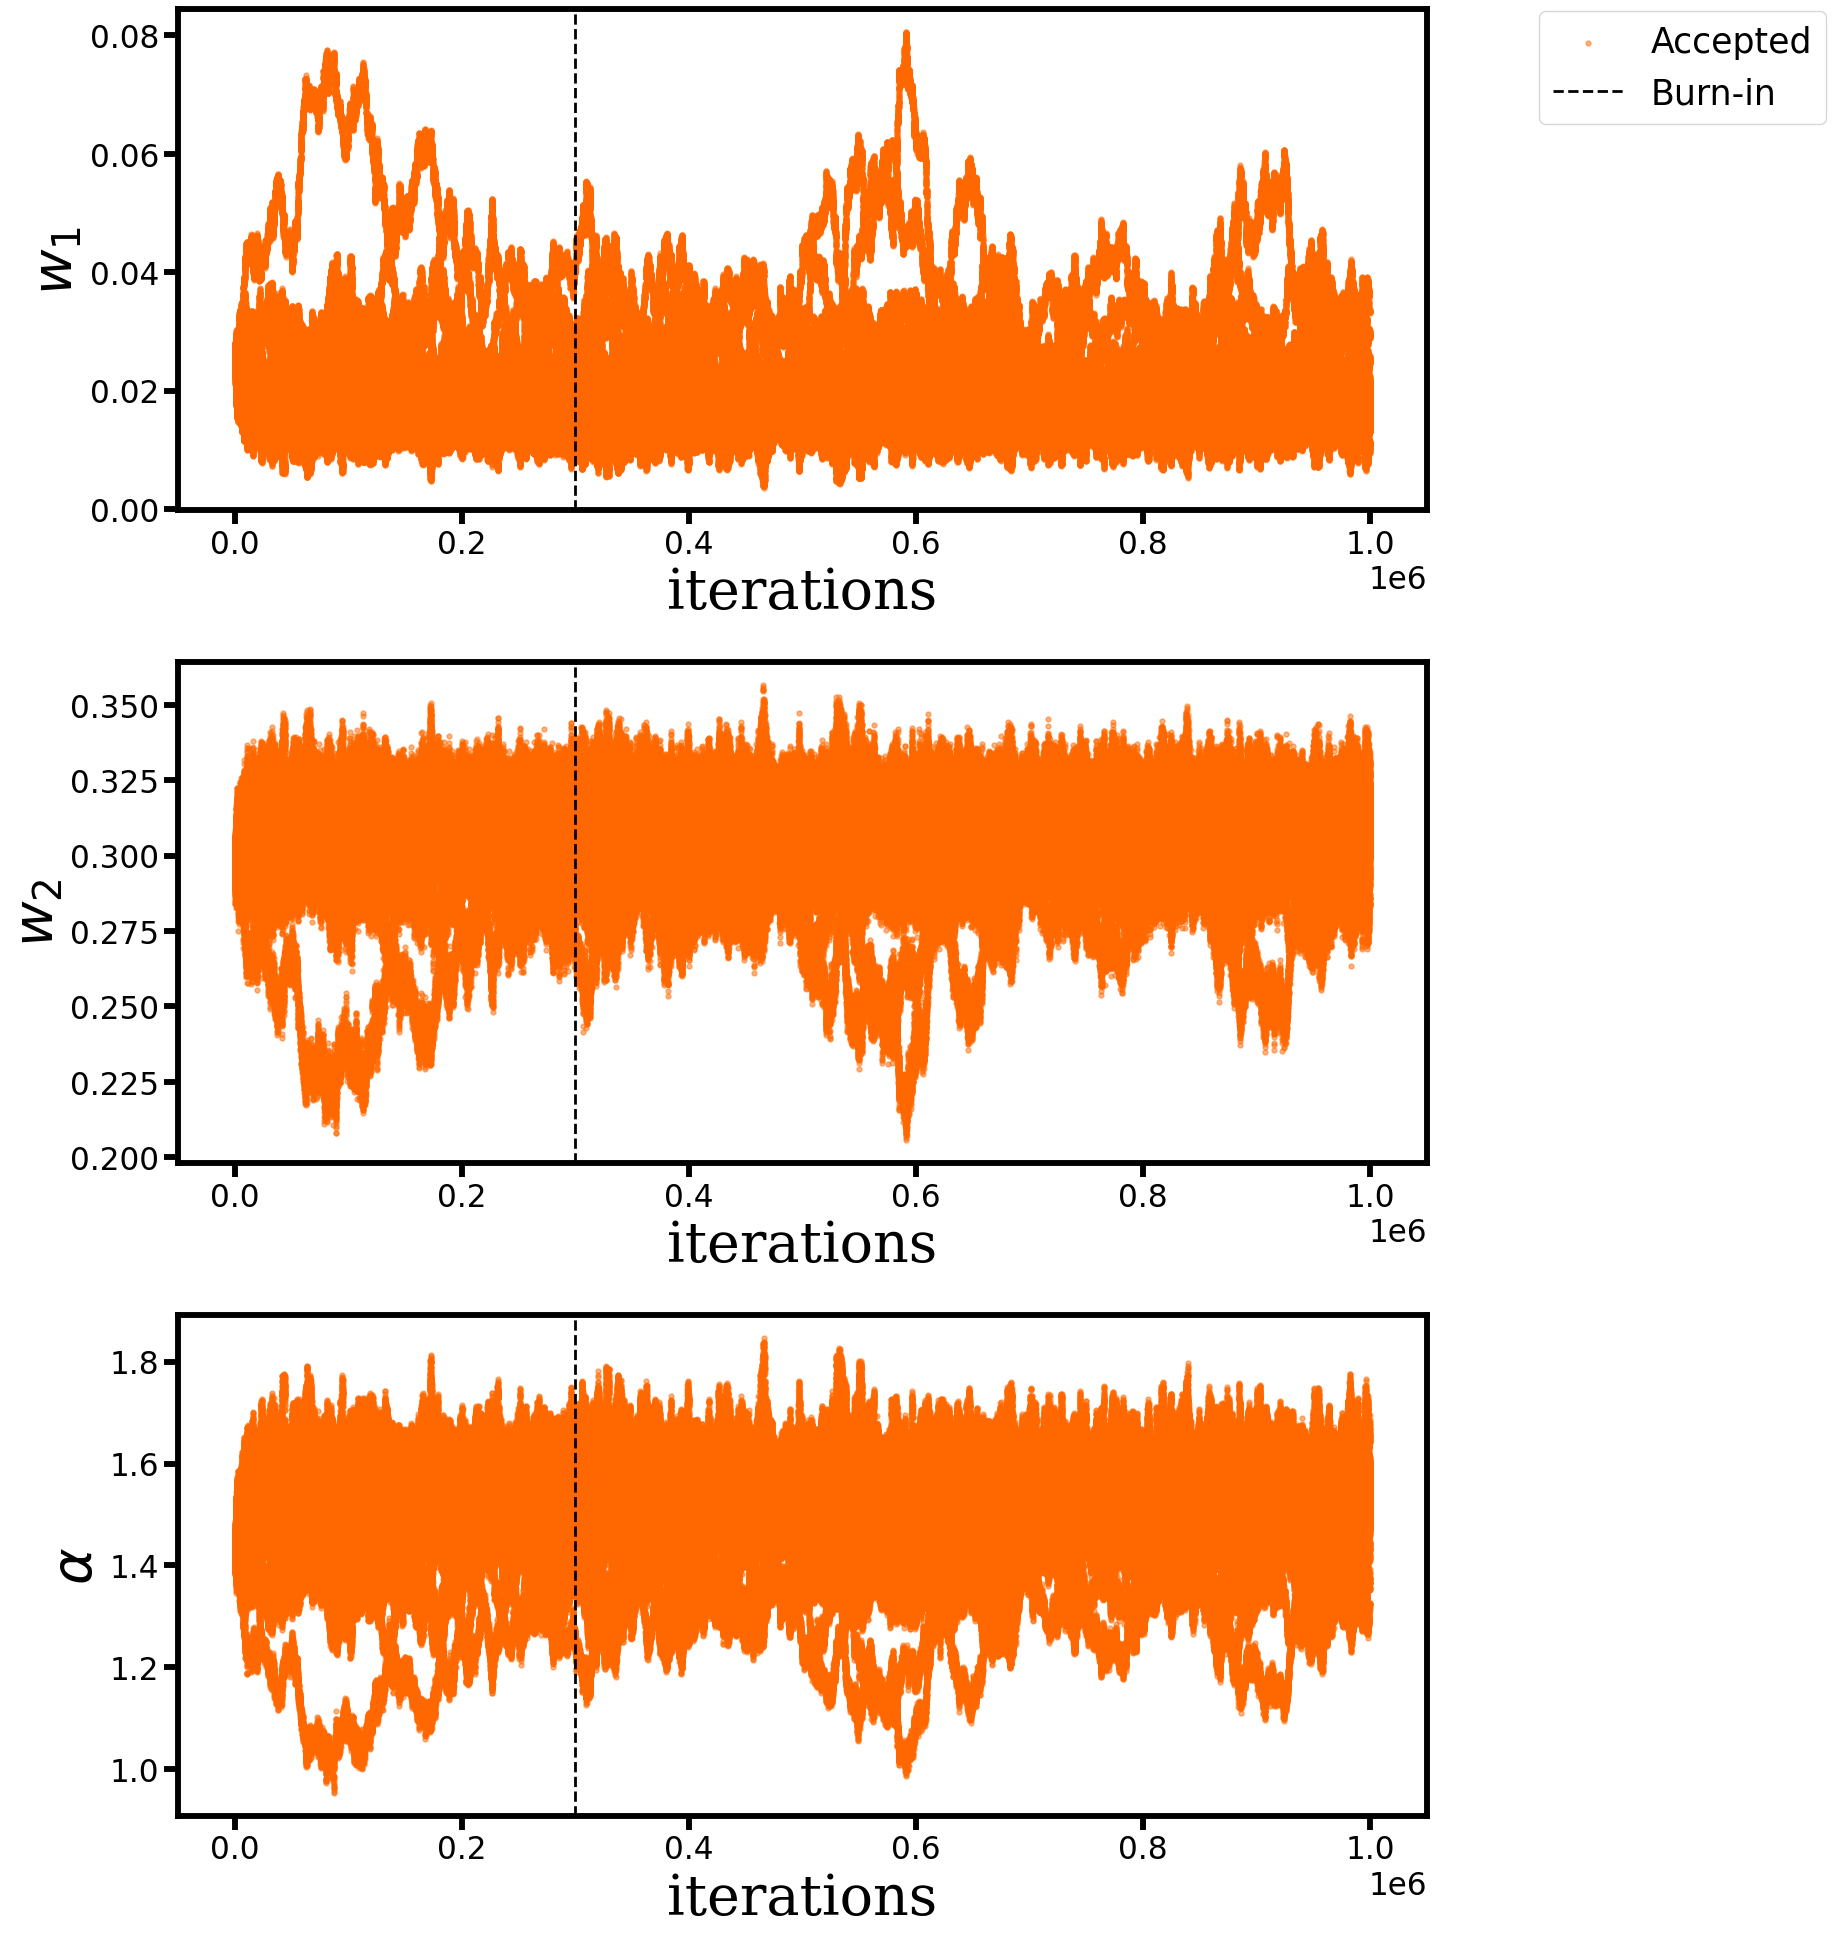

In [220]:
best_fit_params = np.array([np.mean(result["accepted"][:, i][result["accepted"][:, -1] > int(np.floor(burn_in * niter))]) 
                            for i in range(len(result["accepted"][0, :])-1) for result in results])

if model in ["SIS", "NFW"]: fig, axs = plt.subplots(3, 1, figsize=(15, 20))
elif model in ["SIS_ell", "NFW_ell"]: fig, axs = plt.subplots(5, 1, figsize=(15, 30))

legend_labels = []
legend_handles = []

for i, ax in enumerate(axs):
    for j, result in enumerate(results):
        # scatter_rejected = ax.scatter(result["rejected"][:, -1], result["rejected"][:, i], 
        #                                marker='X', color=colors1[1], label="Rejected", alpha=0.5, s=10)
        scatter_accepted = ax.scatter(result["accepted"][:, -1], result["accepted"][:, i], 
                                       marker='.', color=colors1[7], label="Accepted", alpha=0.5, s=50)
        
        # line_mean = ax.axhline(y=best_fit_params[i], color="black", lw=2, label="Mean values")
        
        # for handle, label in zip([scatter_rejected, scatter_accepted, line_mean], 
        #                          ["Rejected", "Accepted", "Mean values"]):
        for handle, label in zip([scatter_accepted], 
                                 ["Accepted"]):
            if label not in legend_labels:
                legend_labels.append(label)
                legend_handles.append(handle)
    
    ax.axvline(int(np.floor(burn_in * niter)), color="black", lw=2, ls="--", label="Burn-in")
    if "Burn-in" not in legend_labels:
        legend_labels.append("Burn-in")
        legend_handles.append(ax.get_lines()[-1])
    
    ax.set_xlabel("iterations", fontdict=font)

if model == "SIS":
    axs[0].set_ylabel(r'$w_1$', fontdict=font)
    axs[1].set_ylabel(r'$w_2$', fontdict=font)  
    axs[2].set_ylabel(r'$\alpha$', fontdict=font) 
    
elif model == "SIS_ell":
    axs[0].set_ylabel(r'$w_1$', fontdict=font)
    axs[1].set_ylabel(r'$w_2$', fontdict=font)  
    axs[2].set_ylabel(r'$\alpha$', fontdict=font) 
    axs[3].set_ylabel(r'$q$', fontdict=font) 
    axs[4].set_ylabel(r'$\theta$', fontdict=font) 
    
elif model == "NFW":
    axs[0].set_ylabel(r'$r_s$', fontdict=font)
    axs[1].set_ylabel(r'$\rho_s$', fontdict=font)  
    axs[2].set_ylabel(r'$w_2$', fontdict=font) 
    
elif model == "NFW_ell":
    axs[0].set_ylabel(r'$r_s$', fontdict=font)
    axs[1].set_ylabel(r'$\rho_s$', fontdict=font)  
    axs[2].set_ylabel(r'$w_2$', fontdict=font) 
    axs[3].set_ylabel(r'$q$', fontdict=font) 
    axs[4].set_ylabel(r'$\theta$', fontdict=font)

fig.legend(handles=legend_handles, labels=legend_labels, fontsize=25, loc='center right', bbox_to_anchor=(1.25, 0.95))
fig.tight_layout(pad=3.0)

plt.savefig("../figures/elliptical_profiles/SIS_SISell_NFW_NFWell/multiple-chains/parameters-time-series_{}_mock{}-30chains_{}_iterations.png".
                            format(model, i_mock, niter), dpi='figure', format='png')

In [221]:
print(model)
print(i_mock)

with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/results_{}_mock{}-30chains_{}_iterations.txt'.format(model, i_mock, niter), 'wb') as f:
    pickle.dump(results, f)

SIS
0


### Testing the convergence of chains

In [70]:
#Code from PyCBC: https://pycbc.org/pycbc/latest/html/_modules/pycbc/inference/gelman_rubin.html
#Cite paper: https://ui.adsabs.harvard.edu/abs/2019PASP..131b4503B/abstract

def gelman_rubin(chains, auto_burn_in=True):
    """ Calculates the univariate Gelman-Rubin convergence statistic
    which compares the evolution of multiple chains in a Markov-Chain Monte
    Carlo process and computes their difference to determine their convergence.
    The between-chain and within-chain variances are computed for each sampling
    parameter, and a weighted combination of the two is used to determine the
    convergence. As the chains converge, the point scale reduction factor
    should go to 1.

    Parameters
    ----------
    chains : iterable
        An iterable of numpy.array instances that contain the samples
        for each chain. Each chain has shape (nparameters, niterations).
    auto_burn_in : bool
        If True, then only use later half of samples provided.

    Returns
    -------
    psrf : numpy.array
        A numpy.array of shape (nparameters) that has the point estimates of
        the potential scale reduction factor.
    """

    # remove first half of samples
    # this will have shape (nchains, nparameters, niterations)
    if auto_burn_in:
        _, _, niterations = np.array(chains).shape
        chains = np.array([chain[:, niterations // 2 + 1:]
                              for chain in chains])

    # get number of chains, parameters, and iterations
    chains = np.array(chains)
    nchains, nparameters, niterations = chains.shape

    # calculate the covariance matrix for each chain
    # this will have shape (nchains, nparameters, nparameters)
    chains_covs = np.array([np.cov(chain) for chain in chains])
    if nparameters == 1:
        chains_covs = chains_covs.reshape((nchains, 1, 1))

    # calculate W the within-chain variance
    # this will have shape (nparameters, nparameters)
    w = np.zeros(chains_covs[0].shape)
    for i, row in enumerate(chains_covs[0]):
        for j, _ in enumerate(row):
            w[i, j] = np.mean(chains_covs[:, i, j])
    if nparameters == 1:
        w = w.reshape((1, 1))

    # calculate B the between-chain variance
    # this will have shape (nparameters, nparameters)
    means = np.zeros((nparameters, nchains))
    for i, chain in enumerate(chains):
        means[:, i] = np.mean(chain, axis=1).transpose()
    b = niterations * np.cov(means)
    if nparameters == 1:
        b = b.reshape((1, 1))

    # get diagonal elements of W and B
    # these will have shape (nparameters)
    w_diag = np.diag(w)
    b_diag = np.diag(b)

    # get variance for each chain
    # this will have shape (nparameters, nchains)
    var = np.zeros((nparameters, nchains))
    for i, chain_cov in enumerate(chains_covs):
        var[:, i] = np.diag(chain_cov)

    # get mean of means
    # this will have shape (nparameters)
    mu_hat = np.mean(means, axis=1)

    # get variance of variances
    # this will have shape (nparameters)
    s = np.var(var, axis=1)

    # get V the combined variance of all chains
    # this will have shape (nparameters)
    v = ((niterations - 1.) * w_diag / niterations +
         (1. + 1. / nchains) * b_diag / niterations)

    # get factors in variance of V calculation
    # this will have shape (nparameters)
    k = 2 * b_diag**2 / (nchains - 1)
    mid_term = np.cov(
        var, means**2)[nparameters:2*nparameters, 0:nparameters].T
    end_term = np.cov(
        var, means)[nparameters:2*nparameters, 0:nparameters].T
    wb = niterations / nchains * np.diag(mid_term - 2 * mu_hat * end_term)

    # get variance of V
    # this will have shape (nparameters)
    var_v = (
        (niterations - 1.) ** 2 * s +
        (1. + 1. / nchains) ** 2 * k +
        2. * (niterations - 1.) * (1. + 1. / nchains) * wb
    ) / niterations**2

    # get degrees of freedom
    # this will have shape (nparameters)
    dof = (2. * v**2) / var_v

    # more degrees of freedom factors
    # this will have shape (nparameters)
    df_adj = (dof + 3.) / (dof + 1.)

    # estimate R
    # this will have shape (nparameters)
    r2_fixed = (niterations - 1.) / niterations
    r2_random = (1. + 1. / nchains) * (1. / niterations) * (b_diag / w_diag)
    r2_estimate = r2_fixed + r2_random

    # calculate PSRF the potential scale reduction factor
    # this will have shape (nparameters)
    psrf = np.sqrt(r2_estimate * df_adj)

    return psrf

In [223]:
model = "SIS"
i_mock = 0
niter= 100000

burn_in = 0.3

#Loading results from the MCMC
with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/results_{}_mock{}-30chains.txt'.format(model, i_mock), 'rb') as f:
    results = pickle.load(f)

# with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/results_{}_mock{}-30chains_{}_iterations.txt'.format(model, i_mock, niter), 'rb') as f:
#     results = pickle.load(f)


#Have to transform "results" from a dictionary into an iterable of numpy.array instances which for each chain has shape (nparameters, niterations)
chains_list = []

for result in results:
    if (model == "SIS") | (model == "NFW"):
        accepted = np.array([result["accepted"][:, 0][result["accepted"][:, -1] > int(np.floor(burn_in * niter))] for i in range(0, 3)])

    if (model == "SIS_ell") | (model == "NFW_ell"):
        accepted = np.array([result["accepted"][:, 0][result["accepted"][:, -1] > int(np.floor(burn_in * niter))] for i in range(0, 5)])

    chains_list.append(accepted)


#The list of chain must be homogeneous, i.e., with the same number of iteration in each chain. I remove the first N iteration of each chain so that all of them
#have the same length as the chain with the lowest number of iterations.
chain_lengths = np.array([chain.shape[1] for chain in chains_list])
chain_lengths_diff = np.array(chain_lengths - chain_lengths.min())

chains_list_homogeneous = [chains_list[i][:, j:] for i, j in zip(range(len(chains_list)), chain_lengths_diff)]

#Run Gelman-Rubin convergence test
print("Gelman-Rubin R-hat statistics:")
gelman_rubin(chains_list_homogeneous, auto_burn_in=False)

Gelman-Rubin R-hat statistics:


array([1.73117824, 1.73117824, 1.73117824])

### MCMC plots and BIC

In [25]:
models = ["SIS", "SIS_ell", "NFW", "NFW_ell"]
i_mocks = [0, 7, 48]

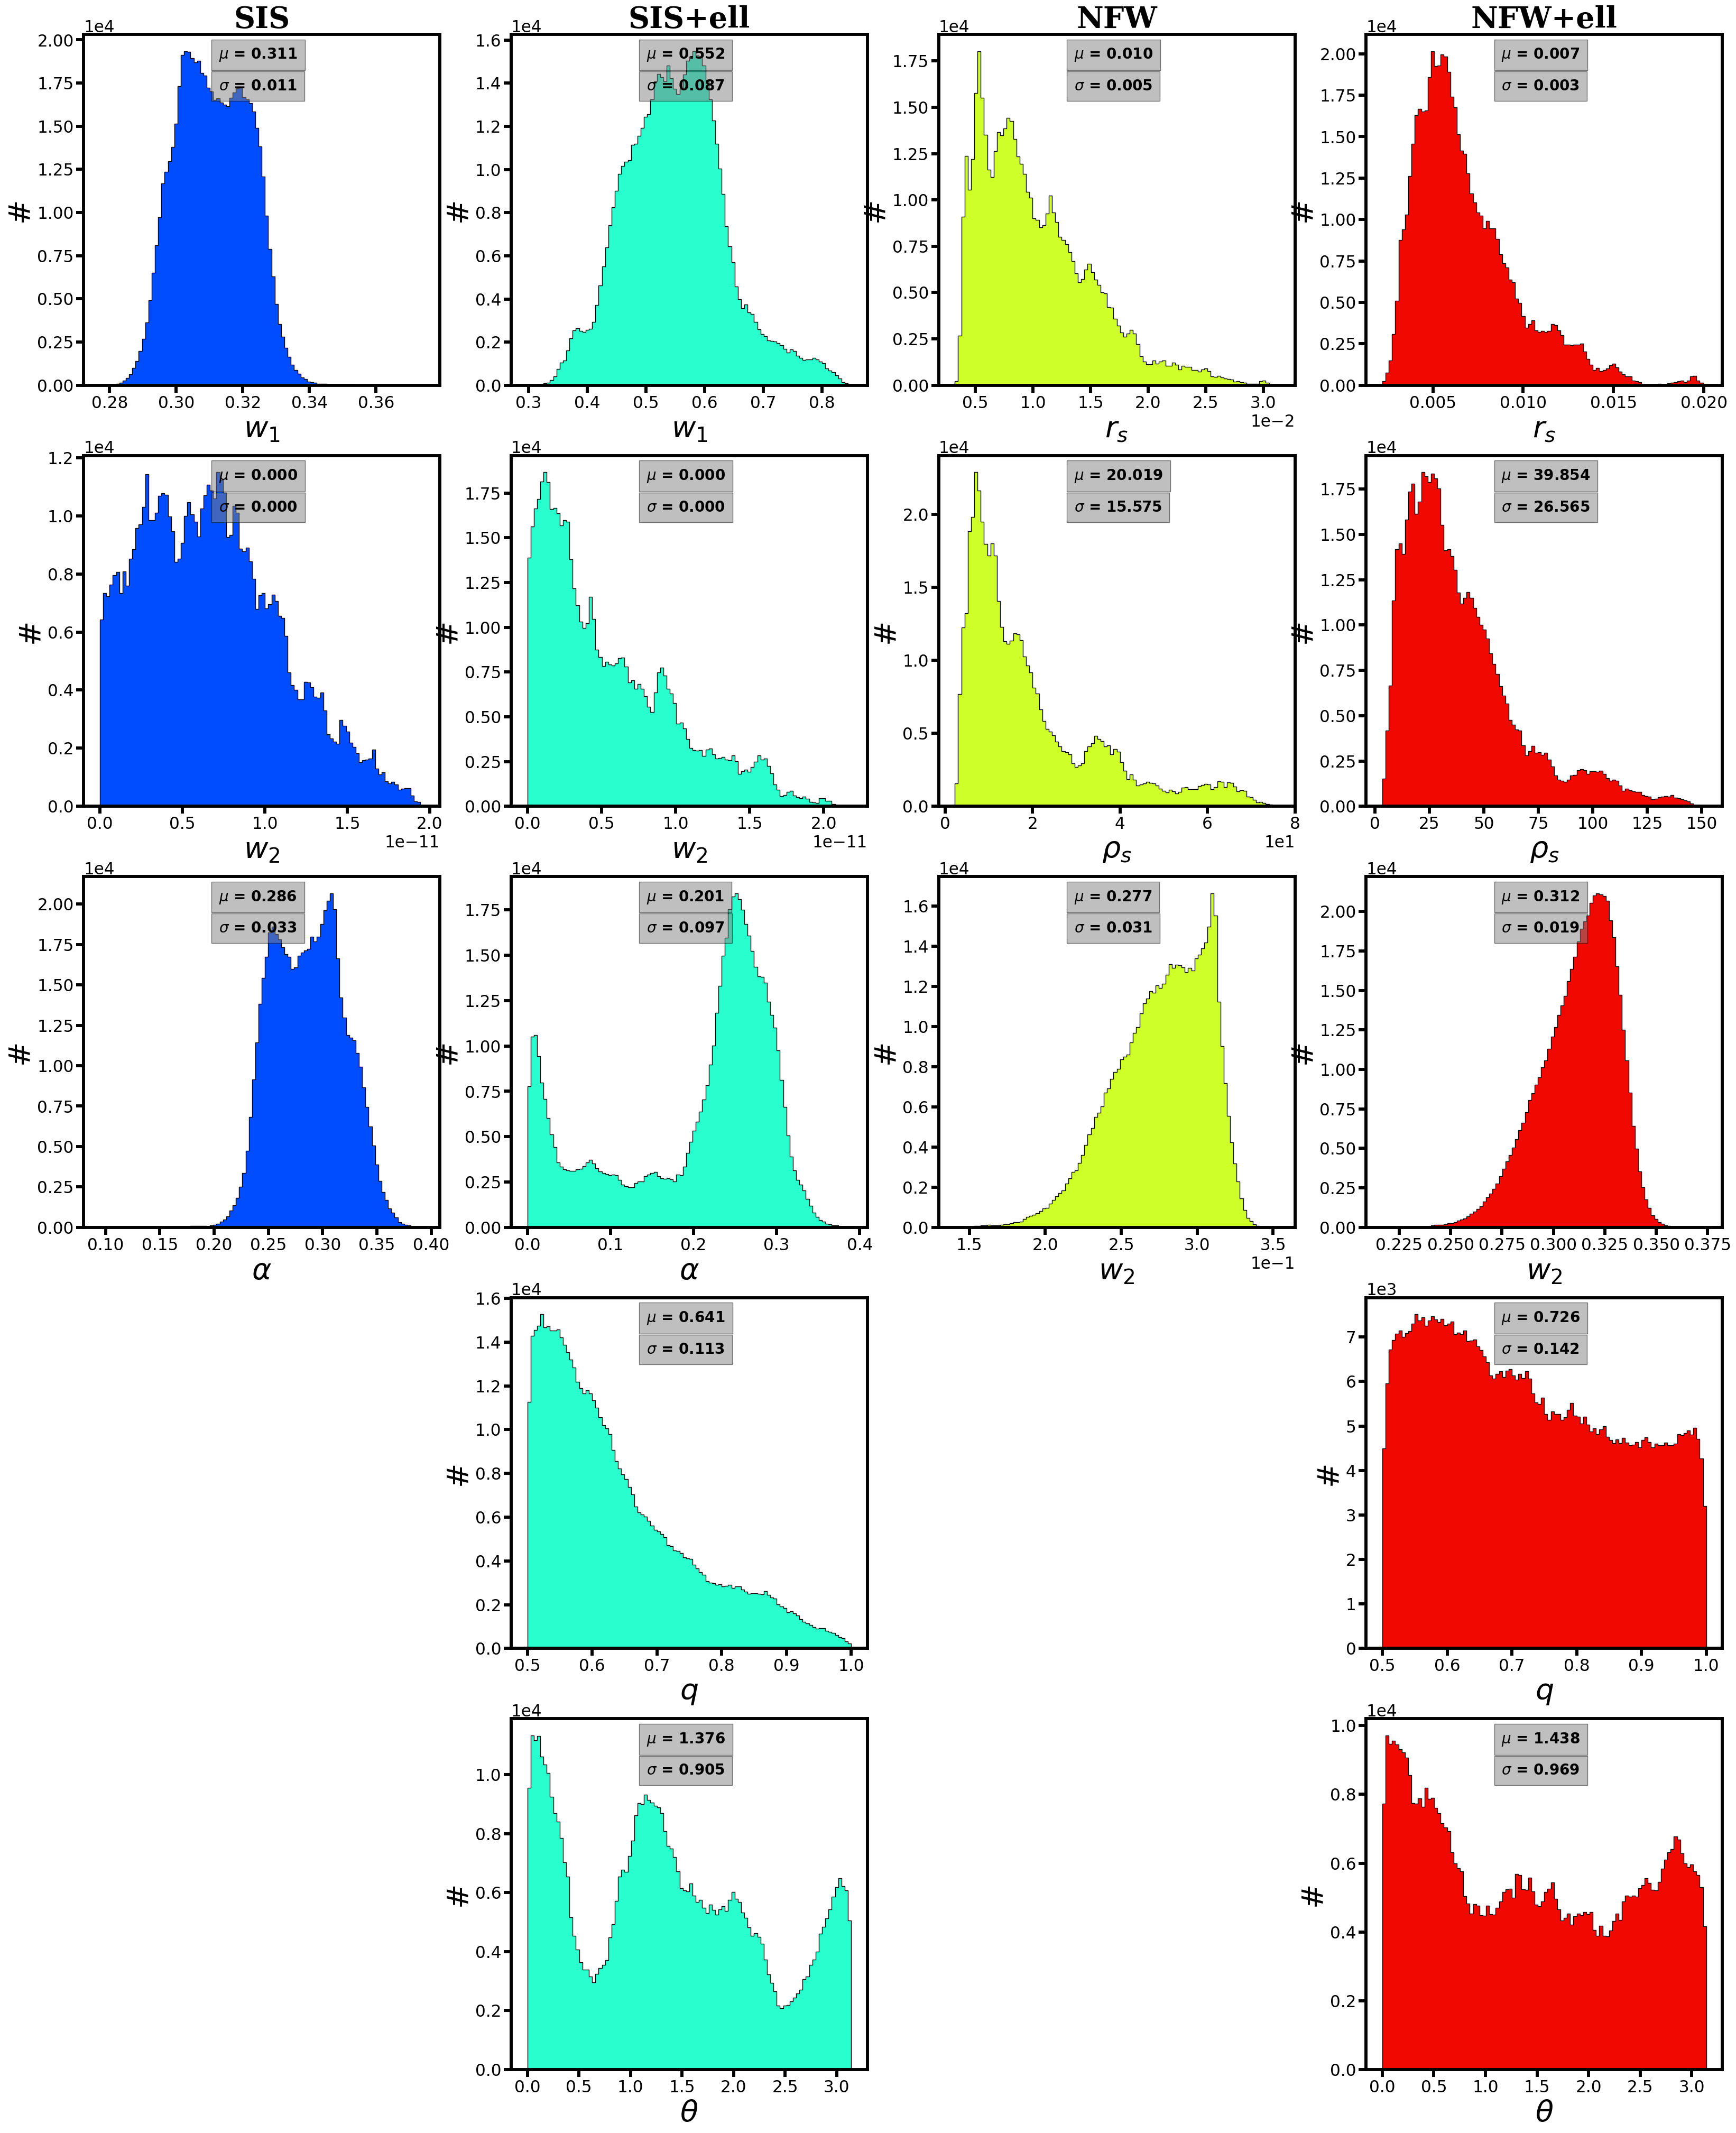

In [72]:
fig, axs = plt.subplots(5, 4, figsize=(40, 50))
i_mock = 48

#==============================================
#SIS
#==============================================
j = 0
model = models[j]

for i in range(0, 3):
    ax = axs[i, j]

    with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/results_{}_mock{}-30chains.txt'.format(model, i_mock), 'rb') as f:
        results = pickle.load(f)

    params = np.hstack([result["accepted"][:, i][result["accepted"][:, -1] > int(np.floor(burn_in * niter))] for result in results])
    mean = np.mean(params)
    std = np.sqrt(np.sum((params - mean)**2)/len(params))

    ax.annotate(r"$\mu$ = {:.3f}".format(mean), xy=(0.38, 0.93), xycoords='axes fraction', fontsize=20, fontweight="bold", 
                bbox=dict(facecolor='gray', edgecolor='k', pad=10.0, alpha=0.5))

    ax.annotate(r"$\sigma$ = {:.3f}".format(std), xy=(0.38, 0.84), xycoords='axes fraction', fontsize=20, fontweight="bold",
                bbox=dict(facecolor='gray', edgecolor='k', pad=10.0, alpha=0.5))

    ax.hist(params, bins=100, color=colors1[1], histtype='stepfilled', edgecolor='k')[2]
    ax.set_ylabel("#", fontdict=font)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    if i == 0: ax.set_xlabel(r"$w_1$", fontdict=font)
    if i == 1: ax.set_xlabel(r"$w_2$", fontdict=font)
    if i == 2: ax.set_xlabel(r"$\alpha$", fontdict=font)


axs[0, j].set_title("SIS", fontdict=font, fontweight="bold")
axs[3, j].set_axis_off()
axs[4, j].set_axis_off()

    
#==============================================
#SIS_ell
#==============================================
j = 1
model = models[j]

for i in range(0, 5):
    ax = axs[i, j]

    with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/results_{}_mock{}-30chains.txt'.format(model, i_mock), 'rb') as f:
        results = pickle.load(f)

    params = np.hstack([result["accepted"][:, i][result["accepted"][:, -1] > int(np.floor(burn_in * niter))] for result in results])
    mean = np.mean(params)
    std = np.sqrt(np.sum((params - mean)**2)/len(params))

    ax.annotate(r"$\mu$ = {:.3f}".format(mean), xy=(0.38, 0.93), xycoords='axes fraction', fontsize=20, fontweight="bold", 
                bbox=dict(facecolor='gray', edgecolor='k', pad=10.0, alpha=0.5))

    ax.annotate(r"$\sigma$ = {:.3f}".format(std), xy=(0.38, 0.84), xycoords='axes fraction', fontsize=20, fontweight="bold",
                bbox=dict(facecolor='gray', edgecolor='k', pad=10.0, alpha=0.5))

    ax.hist(params, bins=100, color=colors1[3], histtype='stepfilled', edgecolor='k')[2]
    ax.set_ylabel("#", fontdict=font)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    if i == 0: ax.set_xlabel(r"$w_1$", fontdict=font)
    if i == 1: ax.set_xlabel(r"$w_2$", fontdict=font)
    if i == 2: ax.set_xlabel(r"$\alpha$", fontdict=font)
    if i == 3: ax.set_xlabel(r"$q$", fontdict=font)
    if i == 4: ax.set_xlabel(r"$\theta$", fontdict=font)

axs[0, j].set_title("SIS+ell", fontdict=font, fontweight="bold")

#==============================================
#NFW
#==============================================
j = 2
model = models[j]

for i in range(0, 3):
    ax = axs[i, j]

    with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/results_{}_mock{}-30chains.txt'.format(model, i_mock), 'rb') as f:
        results = pickle.load(f)

    params = np.hstack([result["accepted"][:, i][result["accepted"][:, -1] > int(np.floor(burn_in * niter))] for result in results])
    mean = np.mean(params)
    std = np.sqrt(np.sum((params - mean)**2)/len(params))

    ax.annotate(r"$\mu$ = {:.3f}".format(mean), xy=(0.38, 0.93), xycoords='axes fraction', fontsize=20, fontweight="bold", 
                bbox=dict(facecolor='gray', edgecolor='k', pad=10.0, alpha=0.5))

    ax.annotate(r"$\sigma$ = {:.3f}".format(std), xy=(0.38, 0.84), xycoords='axes fraction', fontsize=20, fontweight="bold",
                bbox=dict(facecolor='gray', edgecolor='k', pad=10.0, alpha=0.5))

    ax.hist(params, bins=100, color=colors1[5], histtype='stepfilled', edgecolor='k')[2]
    ax.set_ylabel("#", fontdict=font)
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

    if i == 0: ax.set_xlabel(r"$r_s$", fontdict=font)
    if i == 1: ax.set_xlabel(r"$\rho_s$", fontdict=font)
    if i == 2: ax.set_xlabel(r"$w_2$", fontdict=font)

axs[0, j].set_title("NFW", fontdict=font, fontweight="bold")
axs[3, j].set_axis_off()
axs[4, j].set_axis_off()

#==============================================
#NFW_ell
#==============================================
j = 3
model = models[j]

for i in range(0, 5):
    ax = axs[i, j]

    with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/results_{}_mock{}-30chains.txt'.format(model, i_mock), 'rb') as f:
        results = pickle.load(f)

    params = np.hstack([result["accepted"][:, i][result["accepted"][:, -1] > int(np.floor(burn_in * niter))] for result in results])
    mean = np.mean(params)
    std = np.sqrt(np.sum((params - mean)**2)/len(params))

    ax.annotate(r"$\mu$ = {:.3f}".format(mean), xy=(0.38, 0.93), xycoords='axes fraction', fontsize=20, fontweight="bold", 
                bbox=dict(facecolor='gray', edgecolor='k', pad=10.0, alpha=0.5))

    ax.annotate(r"$\sigma$ = {:.3f}".format(std), xy=(0.38, 0.84), xycoords='axes fraction', fontsize=20, fontweight="bold",
                bbox=dict(facecolor='gray', edgecolor='k', pad=10.0, alpha=0.5))

    ax.hist(params, bins=100, color=colors1[8], histtype='stepfilled', edgecolor='k')[2]
    ax.set_ylabel("#", fontdict=font)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    if i == 0: ax.set_xlabel(r"$r_s$", fontdict=font)
    if i == 1: ax.set_xlabel(r"$\rho_s$", fontdict=font)
    if i == 2: ax.set_xlabel(r"$w_2$", fontdict=font)
    if i == 3: ax.set_xlabel(r"$q$", fontdict=font)
    if i == 4: ax.set_xlabel(r"$\theta$", fontdict=font)

axs[0, j].set_title("NFW+ell", fontdict=font, fontweight="bold")

plt.savefig("../figures/membership-method-paper/MCMC-all-parameters-histogram_mock{}-30chains.png".format(i_mock), dpi='figure', format='png')

/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_178810/2233719085.py:38: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/2233719085.py:39: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/2233719085.py:59: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/2233719085.py:60: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as ke

Text(0, 0.5, 'CDF')

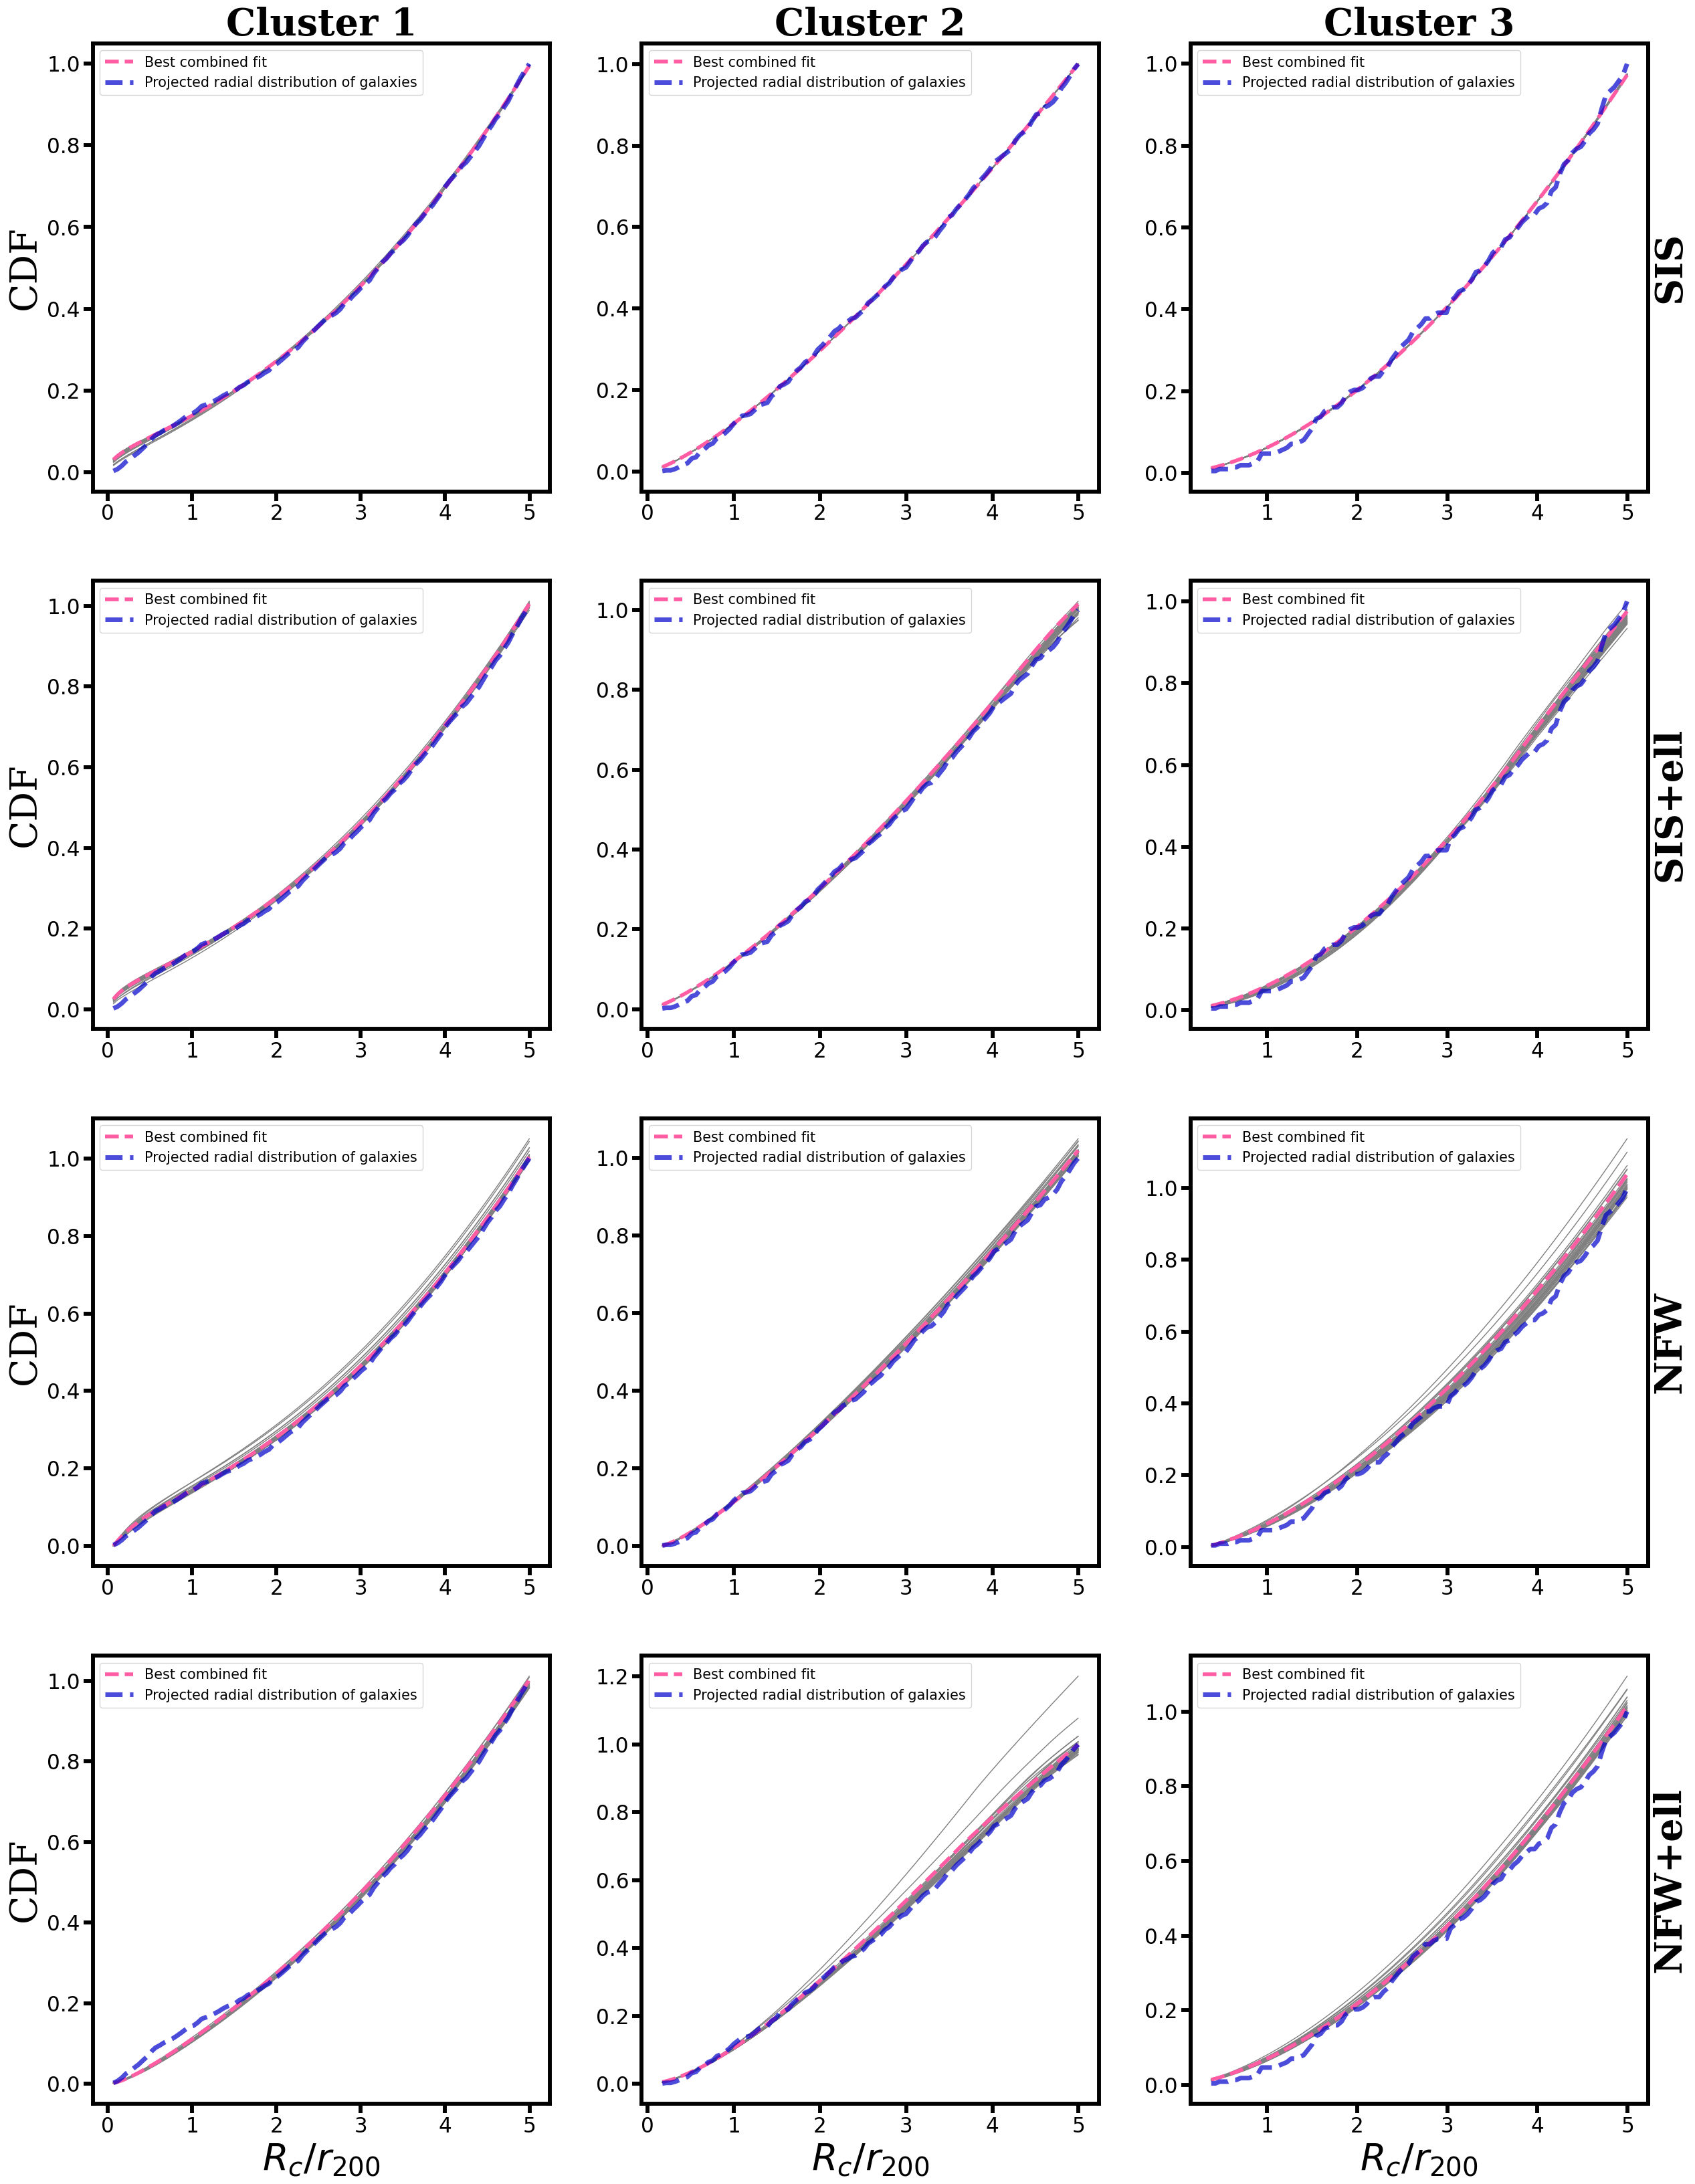

In [73]:
fig, axs = plt.subplots(4, 3, figsize=(30, 40))

for j, i_mock in zip(range(0, 3), i_mocks):
    halo_id = halo_ids_list_unique[i_mock]
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot_pdfs[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]

    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)

    z_bins = 20
    bw = (halo_zspec.max() - halo_zspec.min()) / z_bins
    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
    zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
    log_dens_zz = kde.score_samples(zz)
    z_cluster = zz[np.argmax(np.exp(log_dens_zz))]

    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h
    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)
    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

    t = pd.read_csv("tables/testing-on-mocks/membership-mock-clusters/fz1=1.0/cluster-mock_{}_members.csv".format(i_mock))
    x= np.array(t["RA"])
    y = np.array(t["DEC"])

    Rp = clustercentric_distance(x, y, ra0, dec0)
    Hz, Rcz = np.histogram(Rp, bins=100, density=True)
    dx1 = Rcz[1] - Rcz[0]
    Fz = np.cumsum(Hz)*dx1

    region_size = 5.0
    xbin_size = region_size*100
    ybin_size = region_size*100
    xbins=xbin_size*1j
    ybins=ybin_size*1j
    dx2 = (x.max() - x.min()) / xbin_size
    dy2 = (y.max() - y.min()) / ybin_size
    K = int(np.round(np.sqrt(len(x))))
    xx, yy, zz = knn2D(np.deg2rad(x), np.deg2rad(y), K=K, xbins=xbins, ybins=ybins)
    #I redefine the center of the cluster as the point with maximum density
    ra0_new = np.rad2deg(xx[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dx2/2
    dec0_new = np.rad2deg(yy[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dy2/2
    xx_centered = np.rad2deg(xx) - ra0_new
    yy_centered = np.rad2deg(yy) - dec0_new  

    for i, model in zip(range(0, 4), models):
        ax = axs[i, j]

        with open('tables/testing-on-mocks/testing-models-SIC_SICell_NFW_NFWell/results_{}_mock{}-30chains.txt'.format(model, i_mock), 'rb') as f:
            results = pickle.load(f)

        for k in range(0, 30):
            #valores médios dos parâmetros em cada uma das 30 cadeias
            #isso aqui plota os melhores ajustes das 30 cadeias separadamente

            if model == "SIS":
                params = np.array([np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) for l in range(0, 3)])
                rho_fitted = rho_SIS_(Rcz[1:], *params)
                ax.plot(Rcz[1:]/r200_deg, rho_fitted, lw=1.0, c="gray", alpha=1.0)

            elif model == "NFW":
                params = np.array([np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) for l in range(0, 3)])
                rho_fitted = rho_NFW_(Rcz[1:], *params)
                ax.plot(Rcz[1:]/r200_deg, rho_fitted, lw=1.0, c="gray", alpha=1.0)

            elif model == "SIS_ell":
                params = np.array([np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) for l in range(0, 5)])
                rho_fitted = rho_SIS_ell_(xx_centered, yy_centered, Rcz[1:], *params)
                ax.plot(Rcz[1:]/r200_deg, rho_fitted, lw=1.0, c="gray", alpha=1.0)

            elif model == "NFW_ell":
                params = np.array([np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) for l in range(0, 5)])
                rho_fitted = rho_NFW_ell_(xx_centered, yy_centered, Rcz[1:], *params)
                ax.plot(Rcz[1:]/r200_deg, rho_fitted, lw=1.0, c="gray", alpha=1.0)

        
        if model == "SIS":
            mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 3)] for k in range(0, 30)]), axis=0)
            rho_fitted_mean = rho_SIS_(Rcz[1:], *mean_params)

        elif model == "NFW":
            mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 3)] for k in range(0, 30)]), axis=0)
            rho_fitted_mean = rho_NFW_(Rcz[1:], *mean_params)

        elif model == "SIS_ell":
            mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 5)] for k in range(0, 30)]), axis=0)
            rho_fitted_mean = rho_SIS_ell_(xx_centered, yy_centered, Rcz[1:], *mean_params)

        elif model == "NFW_ell":
            mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 5)] for k in range(0, 30)]), axis=0)
            rho_fitted_mean = rho_NFW_ell_(xx_centered, yy_centered, Rcz[1:], *mean_params)

        ax.plot(Rcz[1:]/r200_deg, rho_fitted_mean, lw=4.0, ls="--", label="Best combined fit", c=colors3[5])
        ax.plot(Rcz[1:]/r200_deg, Fz, lw=5.0, c=colors3[1], ls="--", label="Projected radial distribution of galaxies", alpha=0.7)   

        ax.legend(fontsize=15)


axs[0, 2].twinx().set_ylabel("SIS", fontdict=font, fontweight="bold")
plt.tick_params(right=False, labelright=False)
axs[1, 2].twinx().set_ylabel("SIS+ell", fontdict=font, fontweight="bold")
plt.tick_params(right=False, labelright=False)
axs[2, 2].twinx().set_ylabel("NFW", fontdict=font, fontweight="bold")
plt.tick_params(right=False, labelright=False)
axs[3, 2].twinx().set_ylabel("NFW+ell", fontdict=font, fontweight="bold")
plt.tick_params(right=False, labelright=False)

axs[0, 0].set_title("Cluster 1", fontdict=font, fontweight="bold")
axs[0, 1].set_title("Cluster 2", fontdict=font, fontweight="bold")
axs[0, 2].set_title("Cluster 3", fontdict=font, fontweight="bold") 

axs[3, 0].set_xlabel(r"$R_c/r_{200}$", fontdict=font)
axs[3, 1].set_xlabel(r"$R_c/r_{200}$", fontdict=font)
axs[3, 2].set_xlabel(r"$R_c/r_{200}$", fontdict=font)

axs[0, 0].set_ylabel("CDF", fontdict=font)
axs[1, 0].set_ylabel("CDF", fontdict=font)
axs[2, 0].set_ylabel("CDF", fontdict=font)
axs[3, 0].set_ylabel("CDF", fontdict=font)

# plt.savefig("../figures/membership-method-paper/plot-ajustes.png", dpi='figure', format='png')

/tmp/ipykernel_180570/469602298.py:52: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_180570/469602298.py:53: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)


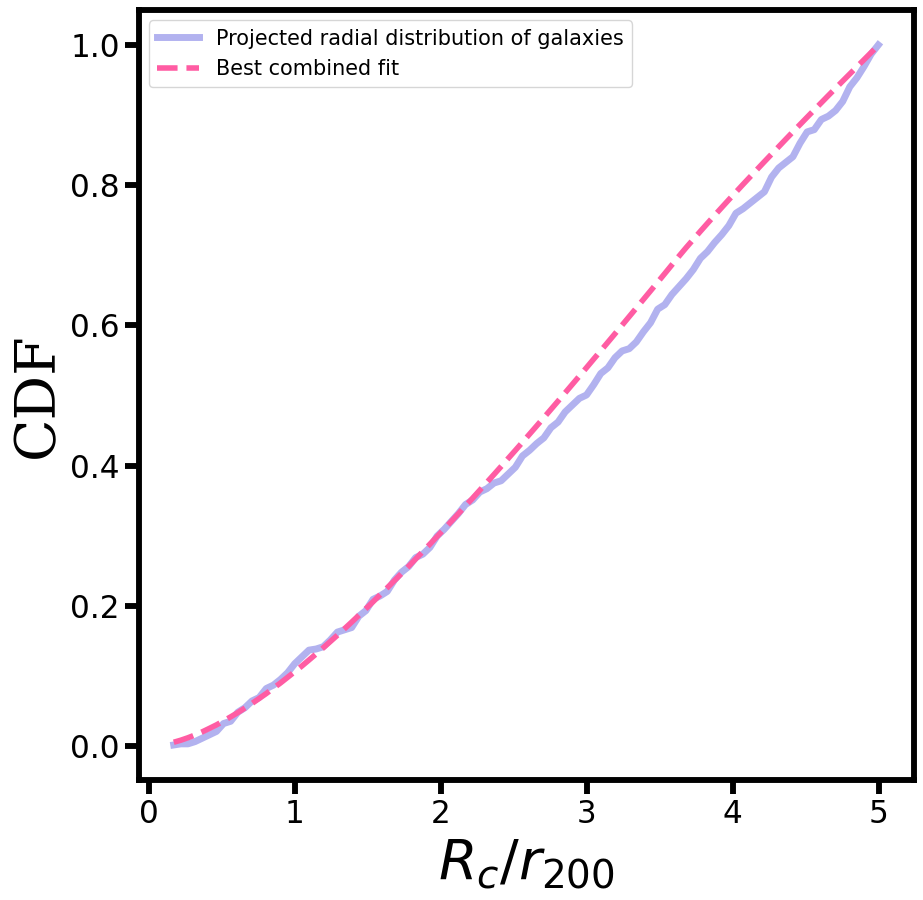

In [131]:
if model == "SIS":
    w1, w2, alpha = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 3)] for k in range(0, 30)]), axis=0)
    rho = rho_SIS_(Rcz[1:], w1, w2, alpha)

elif model == "NFW":
    rs, rho_s, w2 = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 3)] for k in range(0, 30)]), axis=0)
    rho = rho_NFW_(Rcz[1:], rs, rho_s, w2)

elif model == "SIS_ell":
    w1, w2, alpha, q, theta = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 5)] for k in range(0, 30)]), axis=0)
    rho = rho_SIS_ell_(xx_centered, yy_centered, Rcz[1:], w1=w1, w2=w2, alpha=alpha, q=q, theta=theta)

elif model == "NFW_ell":
    rs, rho_s, w2, q, theta = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 5)] for k in range(0, 30)]), axis=0)
    rho = rho_NFW_ell_(xx_centered, yy_centered, Rcz[1:], rs=rs, rho_s=rho_s, w2=w2, q=q, theta=theta)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)    

ax.plot(Rcz[1:]/r200_deg, Fz, lw=5.0, c=colors3[1], label="Projected radial distribution of galaxies", alpha=0.3)
ax.plot(Rcz[1:]/r200_deg, rho, lw=4.0, ls="--", label="Best combined fit", c=colors3[5])

ax.set_xlabel(r"$R_c/r_{200}$", fontdict=font)
ax.set_ylabel("CDF", fontdict=font)
ax.legend(fontsize=15)

# plt.savefig("../figures/elliptical_profiles/SIS_SISell_NFW_NFWell/profile_fit_{}iterations_{}_mock{}.png".format(niter, model, i_mock), dpi='figure', format='png')

In [ ]:
#Run BIC

for i_mock in i_mocks:
    halo_id = halo_ids_list_unique[i_mock]
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot_pdfs[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]

    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)

    z_bins = 20
    bw = (halo_zspec.max() - halo_zspec.min()) / z_bins
    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
    zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
    log_dens_zz = kde.score_samples(zz)
    z_cluster = zz[np.argmax(np.exp(log_dens_zz))]

    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h
    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)
    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

    t = pd.read_csv("tables/testing-on-mocks/membership-mock-clusters/fz1=1.0/cluster-mock_{}_members.csv".format(i_mock))
    x= np.array(t["RA"])
    y = np.array(t["DEC"])

    Rp = clustercentric_distance(x, y, ra0, dec0)
    Hz, Rcz = np.histogram(Rp, bins=100, density=True)
    dx1 = Rcz[1] - Rcz[0]
    Fz = np.cumsum(Hz)*dx1

    region_size = 5.0
    xbin_size = region_size*100
    ybin_size = region_size*100
    xbins=xbin_size*1j
    ybins=ybin_size*1j
    dx2 = (x.max() - x.min()) / xbin_size
    dy2 = (y.max() - y.min()) / ybin_size
    K = int(np.round(np.sqrt(len(x))))
    xx, yy, zz = knn2D(np.deg2rad(x), np.deg2rad(y), K=K, xbins=xbins, ybins=ybins)
    #I redefine the center of the cluster as the point with maximum density
    ra0_new = np.rad2deg(xx[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dx2/2
    dec0_new = np.rad2deg(yy[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dy2/2
    xx_centered = np.rad2deg(xx) - ra0_new
    yy_centered = np.rad2deg(yy) - dec0_new  

    for model in models:

        if model == "SIS":
            mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 3)] for k in range(0, 30)]), axis=0)
            log_lik = log_likelihood(mean_params, xx_centered, yy_centered, Rcz[1:], Fz)
            bic = len(mean_params)*np.log(len(Fz)) - 2*log_lik
            print("i_mock = {}, model = {}, BIC = {}".format(i_mock, model, bic))

        elif model == "NFW":
            mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 3)] for k in range(0, 30)]), axis=0)
            log_lik = log_likelihood(mean_params, xx_centered, yy_centered, Rcz[1:], Fz)
            bic = len(mean_params)*np.log(len(Fz)) - 2*log_lik
            print("i_mock = {}, model = {}, BIC = {}".format(i_mock, model, bic))

        elif model == "SIS_ell":
            mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 5)] for k in range(0, 30)]), axis=0)
            log_lik = log_likelihood(mean_params, xx_centered, yy_centered, Rcz[1:], Fz)
            bic = len(mean_params)*np.log(len(Fz)) - 2*log_lik
            print("i_mock = {}, model = {}, BIC = {}".format(i_mock, model, bic))

        elif model == "NFW_ell":
            mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 5)] for k in range(0, 30)]), axis=0)
            log_lik = log_likelihood(mean_params, xx_centered, yy_centered, Rcz[1:], Fz)
            bic = len(mean_params)*np.log(len(Fz)) - 2*log_lik
            print("i_mock = {}, model = {}, BIC = {}".format(i_mock, model, bic))

/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


i_mock = 0, model = SIS, BIC = 2058.1785783252894
i_mock = 0, model = SIS_ell, BIC = 2067.385032961088
i_mock = 0, model = NFW, BIC = 1749.407843038846


/tmp/ipykernel_180570/469602298.py:31: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_180570/469602298.py:32: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_180570/469602298.py:52: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_180570/469602298.py:53: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


i_mock = 0, model = NFW_ell, BIC = 1840.3588707378683
i_mock = 7, model = SIS, BIC = 2055.772555789048
i_mock = 7, model = SIS_ell, BIC = 2064.97903264336


/tmp/ipykernel_180570/469602298.py:31: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_180570/469602298.py:32: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_180570/469602298.py:52: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_180570/469602298.py:53: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


i_mock = 7, model = NFW, BIC = 1849.0734799203028
i_mock = 7, model = NFW_ell, BIC = 1871.022172820379
i_mock = 48, model = SIS, BIC = 2074.118538247708
i_mock = 48, model = SIS_ell, BIC = 2083.325396952456
i_mock = 48, model = NFW, BIC = 1778.2435706495805
i_mock = 48, model = NFW_ell, BIC = 1811.0766361632052


/tmp/ipykernel_180570/469602298.py:31: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_180570/469602298.py:32: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_180570/469602298.py:52: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_180570/469602298.py:53: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)


### Run MCMC for all clusters with the NFW profile and compute P(C|R)

In [ ]:
#Aglomerados do mock que dão problema (e isso que eu só rodei até o 384):

#MCMC deu pau no 41, 81, 86, 98, 115, 158, 159, 176, 205, 241, 243, 246, 252, 253, 281, 283, 294, 319, 323, 326, 329, 338, 339, 340, 342, 348, 353
# 354, 360, 376, 379, 380, 381, 383

#aglomerado 156 só tem duas galáxias selecionadas pelo P(C|P(zp))
#aglomerado 179 só tem duas galáxias selecionadas pelo P(C|P(zp))
#aglomerado 180 só tem duas galáxias selecionadas pelo P(C|P(zp))
#aglomerado 262 só tem três galáxias selecionadas pelo P(C|P(zp))
#aglomerado 357 só tem três galáxias selecionadas pelo P(C|P(zp))
#aglomerado 360 tem zero galáxias selecionadas pelo P(C|P(zp))
#aglomerado 361 só tem três galáxias selecionadas pelo P(C|P(zp))
#aglomerado 369 só tem nove galáxias selecionadas pelo P(C|P(zp))

In [ ]:
for i_mock in np.arange(382, 500, 1):

    #Load and compute cluster data
    halo_id = halo_ids_list_unique[i_mock]
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot_pdfs[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]

    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)

    z_bins = 20
    bw = (halo_zspec.max() - halo_zspec.min()) / z_bins

    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
    zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
    log_dens_zz = kde.score_samples(zz)

    z_cluster = zz[np.argmax(np.exp(log_dens_zz))]

    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h

    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)

    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

    t = pd.read_csv("tables/testing-on-mocks/membership-mock-clusters/fz1=1.0/cluster-mock_{}_members.csv".format(i_mock))
    ra_selected = np.array(t["RA"])
    dec_selected = np.array(t["DEC"])

    #Compute observed cumulative number density
    x = ra_selected
    y = dec_selected

    Rp = clustercentric_distance(x, y, ra0, dec0)
    Hz, Rcz = np.histogram(Rp, bins=100, density=True)
    dx1 = Rcz[1] - Rcz[0]
    Fz = np.cumsum(Hz)*dx1

    region_size = 5.0
    xbin_size = region_size*100
    ybin_size = region_size*100
    xbins=xbin_size*1j
    ybins=ybin_size*1j

    dx2 = (x.max() - x.min()) / xbin_size
    dy2 = (y.max() - y.min()) / ybin_size

    #I approximate K as being the sqrt of the number of selected galaxies in the cluster
    K = int(np.round(np.sqrt(len(x))))
    xx, yy, zz = knn2D(np.deg2rad(x), np.deg2rad(y), K=K, xbins=xbins, ybins=ybins)

    #I redefine the center of the cluster as the point with maximum density
    ra0_new = np.rad2deg(xx[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dx2/2
    dec0_new = np.rad2deg(yy[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]]) + dy2/2

    xx_centered = np.rad2deg(xx) - ra0_new
    yy_centered = np.rad2deg(yy) - dec0_new  


    #Run MCMC

    try:
        params = curve_fit(rho_NFW_, Rcz[1:], Fz, bounds=((0, 0, 0), (np.inf, np.inf, 3)))[0]
        rs, rho_s, w2_NFW = params
        print("Parameters estimated by scipy: rs = {}, rho_s = {}, w2 = {}".format(rs, rho_s, w2_NFW))
        initial_params = [rs, rho_s, w2_NFW] #values from scipy for rs, rho_s, w2

    except RuntimeError:
        initial_params = [0.010, 50, 0.3] #educated guesses for rs, rho_s, w2


    # Parameters
    sp = 0.01*np.array(initial_params)
    num_chains = 30  # Number of chains to run
    niter = 100000  # Number of iterations per chain
    burn_in = 0.3  # Burn-in fraction

    t0 = time.time()

    # Run the chains
    results = run_parallel_chains(
        num_chains=num_chains,
        likelihood=log_likelihood,
        prior=log_prior,
        transition_model=transition_model,
        param_init=initial_params,
        iterations=niter,
        x=xx_centered,
        y=yy_centered,
        R=Rcz[1:],
        data=Fz,
        acceptance_rule=acceptance,
        sp=sp
    )

    # Combine and analyze results
    for i, result in enumerate(results):
        print(f"\nChain {i + 1} (Seed: {result['seed']}):")
        print(f"Number of accepted samples: {len(result['accepted'])}")
        print(f"Acceptance rate: {len(result['accepted']) / niter * 100:.2f}%. This number should be around 30%")

    print("\nTotal processing time:", time.time() - t0)

    # Example: Combine all accepted samples from the chains
    all_accepted = np.vstack([result["accepted"] for result in results])
    print(f"\nTotal accepted samples across all chains: {len(all_accepted)}")

    with open('tables/testing-on-mocks/MCMC-NFW-results/results_{}_mock{}-30chains.txt'.format(model, i_mock), 'wb') as f:
        pickle.dump(results, f)

/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_3573242/747006610.py:34: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_3573242/747006610.py:35: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)


Parameters estimated by scipy: rs = 0.0005442046812053324, rho_s = 3212.834879312543, w2 = 2.832792260834332


100%|██████████| 30/30 [00:00<00:00, 537731.28it/s]



Chain 1 (Seed: 42):
Number of accepted samples: 28167
Acceptance rate: 28.17%. This number should be around 30%

Chain 2 (Seed: 43):
Number of accepted samples: 37697
Acceptance rate: 37.70%. This number should be around 30%

Chain 3 (Seed: 44):
Number of accepted samples: 35139
Acceptance rate: 35.14%. This number should be around 30%

Chain 4 (Seed: 45):
Number of accepted samples: 41513
Acceptance rate: 41.51%. This number should be around 30%

Chain 5 (Seed: 46):
Number of accepted samples: 41557
Acceptance rate: 41.56%. This number should be around 30%

Chain 6 (Seed: 47):
Number of accepted samples: 40664
Acceptance rate: 40.66%. This number should be around 30%

Chain 7 (Seed: 48):
Number of accepted samples: 30905
Acceptance rate: 30.90%. This number should be around 30%

Chain 8 (Seed: 49):
Number of accepted samples: 35814
Acceptance rate: 35.81%. This number should be around 30%

Chain 9 (Seed: 50):
Number of accepted samples: 37559
Acceptance rate: 37.56%. This number shou

/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


ValueError: zero-size array to reduction operation maximum which has no identity

In [12]:
i_mock_list = []
rs_list = []
rho_s_list = []
w2_list = []
cut_R_list = []
c_R_max_list = []
p_R_max_list = []
f1_R_max_list = []
c_R_list = []
p_R_list = []


imocks = np.arange(0, 384, 1)
#Teve um monte de aglomerados que o MCMC não rodou direito. Por enquanto vou só ignorar eles, mas talvez mais tarde dê vontade de entender pq não rodou direito.
for i_mock in imocks[~np.isin(imocks, [41, 81, 86, 98, 115, 156, 158, 159, 176, 179, 180, 205, 241, 243, 246, 252, 253, 262, 281, 283, 294, 
                                       319, 323, 326, 329, 338, 339, 340, 342, 348, 353, 354, 357, 360, 361, 369, 376, 379, 380, 381, 383])]:
    
    print("COMPUTING FOR CLUSTER {}".format(i_mock))
    
    #Load and compute cluster data
    halo_id = halo_ids_list_unique[i_mock]
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot_pdfs[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]

    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)

    z_bins = 20
    bw = (halo_zspec.max() - halo_zspec.min()) / z_bins

    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
    zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
    log_dens_zz = kde.score_samples(zz)

    z_cluster = zz[np.argmax(np.exp(log_dens_zz))]

    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h

    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)

    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

    t = pd.read_csv("tables/testing-on-mocks/membership-mock-clusters/fz1=1.0/cluster-mock_{}_members.csv".format(i_mock))
    ra_selected = np.array(t["RA"])
    dec_selected = np.array(t["DEC"])

    #Distribuição cumulativa observada
    x = ra_selected
    y = dec_selected

    Rp = clustercentric_distance(x, y, ra0, dec0)
    Hz, Rcz = np.histogram(Rp, bins=100, density=True)
    dx1 = Rcz[1] - Rcz[0]
    Fz = np.cumsum(Hz)*dx1

    #Loading results from the MCMC
    with open('tables/testing-on-mocks/MCMC-NFW-results/results_{}_mock{}-30chains.txt'.format(model, i_mock), 'rb') as f:
        results = pickle.load(f)

    mean_params = np.median(np.array([[np.mean(results[k]["accepted"][results[k]["accepted"][:, -1] > int(np.floor(burn_in * niter))][:, l]) 
                                                for l in range(0, 3)] for k in range(0, 30)]), axis=0)
    
    #Computing the radial membership probabilities
    Pmem_R_C, rho_c_interp, rho_f_interp = radial_mem_prob(R=np.deg2rad(Rcz[1:]), clc_dist=np.deg2rad(Rp), rs=mean_params[0], rho_s=mean_params[1], 
                                                                        w2=mean_params[2], dx1=dx1)
    
    # bins = 50
    # fig = plt.figure(figsize=(20, 10))
    # ax1 = fig.add_subplot(121)
    # ax = fig.add_subplot(122)  


    # ax1.hist(Pmem_R_C, bins=bins, histtype='stepfilled', 
    #             color=colors3[1], alpha=1.0, range=[0, 1.0])
    # ax1.set_xlabel("P(C|zp)", fontdict=font)
    # ax1.set_ylabel("Number of objects", fontdict=font)  

    # ax.plot(Rcz[1:]/r200_deg, Fz, lw=5.0, c=colors3[1], label="Projected radial distribution of galaxies", alpha=0.3)
    # ax.scatter(Rp/r200_deg, rho_c_interp+rho_f_interp, lw=4.0, ls="--", label="Best combined fit", c=colors3[5])
    # ax.scatter(Rp/r200_deg, rho_c_interp, lw=3.0, ls="-", label="Best cluster fit", c=colors3[3], alpha=0.7)
    # ax.scatter(Rp/r200_deg, rho_f_interp, lw=3.0, ls="-", label="Best field fit", c=colors3[6], alpha=0.7)

    # ax.set_xlabel(r"$R_c/r_{200}$", fontdict=font)
    # ax.set_ylabel("CDF", fontdict=font)
    # ax.legend(fontsize=15)

    # fig.tight_layout(pad=3.0)

    # plt.savefig("../figures/membership-testing-on-mocks/P(C|R)-results/P(C|R)-distribution-and-density-fit_mock{}.png".format(i_mock), dpi='figure', format='png')


    completeness_R = []
    purity_R = []
    d = 0.01
    Pmem_cut_arr_R = np.arange(0.0, 1.0, d)

    for Pmem_cut in Pmem_cut_arr_R:
            c = np.sum(np.isin(galaxyId[halo_mask], np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])) / len(galaxyId[halo_mask])
            p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])

            completeness_R.append(c)
            purity_R.append(p)


    #We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
    completeness_R = np.array(completeness_R)
    purity_R = np.array(purity_R)

    F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)

    cut_R = Pmem_cut_arr_R[np.argmax(F1_R[~np.isnan(F1_R)])]


    # fig = plt.figure(figsize=(10, 10))
    # ax1 = fig.add_subplot(111)

    # ms = 10
    # ax1.plot(Pmem_cut_arr_R, completeness_R, marker='o', color=colors1[2],
    #         label="Completeness", markersize=ms, markeredgecolor="black")
    # ax1.plot(Pmem_cut_arr_R, purity_R, marker='o', color=colors1[5],
    #         label="Purity", markersize=ms, markeredgecolor="black")
    # ax1.plot(Pmem_cut_arr_R, F1_R, marker='o', color=colors1[8],
    #         label="F1 score", markersize=ms, markeredgecolor="black")

    # # ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
    # ax1.set_ylabel("%", fontdict=font)
    # ax1.set_xlabel("P(C | R) cut", fontdict=font)

    # ax1.axvline(cut_R, color="black")
    # ax1.text(x=cut_R-0.18, y=0.2, s="Cut at {:.2f}".format(cut_R), fontsize=15)

    # ax1.legend(fontsize=labelsize, loc=2)

    # fig.tight_layout()
    # plt.savefig("../figures/membership-testing-on-mocks/P(C|R)-results/P(C|R)-purity-completeness_mock{}.png".format(i_mock), dpi='figure', format='png')

    #Saving results
    i_mock_list.append(i_mock)
    rs_list.append(mean_params[0])
    rho_s_list.append(mean_params[1])
    w2_list.append(mean_params[2])
    cut_R_list.append(cut_R)
    c_R_max_list.append(completeness_R[np.argmax(F1_R[~np.isnan(F1_R)])])
    p_R_max_list.append(purity_R[np.argmax(F1_R[~np.isnan(F1_R)])])
    f1_R_max_list.append(F1_R[np.argmax(F1_R[~np.isnan(F1_R)])])
    c_R_list.append(completeness_R)
    p_R_list.append(purity_R)

    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/i_mock_list", i_mock_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/rs_list", rs_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/rho_s_list", rho_s_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/w2_list", w2_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/cut_R_list", cut_R_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/c_R_max_list", c_R_max_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/p_R_max_list", p_R_max_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/f1_R_max_list", f1_R_max_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/c_R_list", c_R_list)
    np.save("tables/testing-on-mocks/mock_clusters_properties/P(C|R)-results/p_R_list", p_R_list)


COMPUTING FOR CLUSTER 0


/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.

COMPUTING FOR CLUSTER 1


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 2


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 3


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 4


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 5


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 6


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 7


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 8


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 9


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 10


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 11


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 12


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 13


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 14


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 15


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 16


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 17


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 18


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 19


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 20


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 21


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 22


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 23


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 24


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 25


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 26


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 27


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 28


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 29


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 30


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 31


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 32


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 33


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 34


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 35


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 36


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 37


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 38


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 39


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 40


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 42


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 43


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 44


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 45


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 46


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 47


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 48


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 49


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 50


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 51


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 52


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 53


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 54


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 55


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 56


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 57


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 58


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 59


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 60


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 61


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 62


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 63


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 64


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 65


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 66


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 67


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 68


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 69


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 70


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 71


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 72


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 73


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 74


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 75


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 76


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 77


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 78


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 79


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 80


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 82


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 83


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 84


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 85


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 87


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 88


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 89


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 90


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 91


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 92


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 93


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 94


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 95


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 96


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 97


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 99


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 100


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 101


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 102


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 103


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 104


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 105


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 106


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 107


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 108


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 109


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 110


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 111


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 112


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 113


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 114


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 116


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 117


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 118


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 119


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 120


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 121


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 122


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 123


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 124


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 125


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 126


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 127


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 128


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 129


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 130


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 131


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 132


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 133


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 134


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 135


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 136


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 137


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 138


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 139


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 140


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 141


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 142


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 143


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 144


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 145


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 146


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 147


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 148


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 149


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 150


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 151


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 152


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 153


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 154


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 155


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 157


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 160


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 161


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 162


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 163


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 164


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 165


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 166


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 167


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 168


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 169


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 170


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 171


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 172


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 173


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 174


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 175


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 177


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 178


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 181


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 182


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 183


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 184


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 185


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 186


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 187


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 188


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 189


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 190


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 191


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 192


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 193


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 194


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 195


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 196


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 197


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 198


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 199


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 200


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 201


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 202


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 203


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 204


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 206


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 207


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 208


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 209


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 210


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 211


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 212


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 213


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 214


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 215


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 216


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 217


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 218


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 219


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 220


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 221


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 222


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 223


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 224


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 225


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 226


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 227


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 228


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 229


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 230


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 231


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 232


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 233


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 234


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 235


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 236


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 237


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 238


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 239


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 240


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 242


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 244


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 245


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 247


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 248


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 249


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 250


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 251


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 254


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 255


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 256


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 257


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 258


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 259


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 260


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 261


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 263


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 264


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 265


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 266


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 267


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 268


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 269


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 270


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 271


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 272


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 273


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 274


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 275


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 276


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 277


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 278


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 279


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 280


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 282


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 284


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 285


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 286


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 287


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 288


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 289


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 290


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 291


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 292


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 293


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 295


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 296


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 297


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 298


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 299


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 300


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 301


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 302


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 303


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 304


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 305


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 306


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 307


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 308


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 309


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 310


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 311


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 312


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 313


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 314


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 315


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 316


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 317


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 318


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 320


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 321


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 322


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 324


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 325


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 327


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 328


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 330


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 331


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 332


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 333


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 334


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 335


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 336


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 337


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 341


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 343


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 344


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 345


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 346


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 347


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 349


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 350


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 351


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 352


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 355


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 356


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 358


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 359


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 362


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 363


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 364


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress t

COMPUTING FOR CLUSTER 365


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 366


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:402: RuntimeWarning: invalid value encountered in arccosh
  C_lt1 = np.where(x < 1, np.arccosh(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/home/elismar/miniconda3/envs/Doc/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


COMPUTING FOR CLUSTER 367


/home/elismar/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:401: RuntimeWarning: invalid value encountered in arccos
  C_gt1 = np.where(x > 1, np.arccos(1/x), 0)
/tmp/ipykernel_178810/1587410758.py:107: RuntimeWarning: invalid value encountered in scalar divide
  p = np.sum(np.isin(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(np.array(t["galaxyId"])[Pmem_R_C > Pmem_cut])
/tmp/ipykernel_178810/1587410758.py:117: RuntimeWarning: invalid value encountered in divide
  F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)


ValueError: attempt to get argmax of an empty sequence

## Elliptical surface density profile

In [213]:
#Possible density profiles

def Sigma_NFW_(x, y, rho_s, r_s, q, theta):
    '''
    theta: inclination of the ellipse (radians)
    '''
    
    x_prime = x*np.cos(theta) - y*np.sin(theta)
    y_prime = x*np.sin(theta) + y*np.cos(theta)
    
    r = np.sqrt(x_prime**2 + y_prime**2/q**2) / r_s
        
    #where(condition, x(if condition is True), y(if condition is False))    
    c_gt1 = np.where(r > 1, np.arccos(1/r), 0)
    c_lt1 = np.where(r < 1, np.arccosh(1/r), 0)
    
    c = c_gt1 + c_lt1
    
    return 2 * rho_s * r_s * (1 - c/np.sqrt(np.abs(r**2 - 1))) / (r**2 - 1)


def Sersic_profile_(x, y, Sigma0, re, n, q, theta):
    '''
    theta: inclination of the ellipse (radians)
    '''

    x_prime = x*np.cos(theta) - y*np.sin(theta)
    y_prime = x*np.sin(theta) + y*np.cos(theta)
    
    r = np.sqrt(x_prime**2 + y_prime**2/q**2)
    
    #Approximation by Graham & Driver (2005):
    bn = 2*n - 1/3 + 8/(405*2*n) + 184/(25515*(2*n)**2) + 1048/(1148175*(2*n)**3)
    
    return Sigma0 * np.exp(-bn * ((r/re)**(1/n) - 1))


def Sigma_2halo_(R, r_out, rho_m, gamma):
    
#     r_out = 1.1*r200_deg[0]
    
    term = (R/r_out) ** gamma
    beta_term = beta((gamma - 1)/2, 1/2)
    sigma = rho_m * (term * beta_term + 1)
    return sigma


def Sigma_(x, y, R, rho_s, r_s, r_out, rho_m, gamma, q, theta):
    '''
    theta: inclination of the ellipse (radians)
    '''

    x_prime = x*np.cos(theta) - y*np.sin(theta)
    y_prime = x*np.sin(theta) + y*np.cos(theta)
    
    r = np.sqrt(x_prime**2 + y_prime**2/q**2)
    
    #Approximation by Graham & Driver (2005):
    #bn = 2*n - 1/3 + 8/(405*2*n) + 184/(25515*(2*n)**2) + 1048/(1148175*(2*n)**3)
    
#     return Sersic_profile_(x, y, Sigma0, re, n, q, theta)*np.exp(-(r/Rt)**tau) + Sigma_2halo_(R, rho_m, gamma)
    return Sigma_NFW_(x, y, rho_s, r_s, q, theta) + Sigma_2halo_(R, r_out, rho_m, gamma)


In [193]:
# x1 = halo_ra #like longitude
# y1 = halo_dec #like latitude

x1 = ra_selected
y1 = dec_selected

region_size = 5.0
xbin_size = region_size*100
ybin_size = region_size*100
xbins=xbin_size*1j
ybins=ybin_size*1j

R1 = clustercentric_distance(x1, y1, ra0, dec0)
x1 = x1[R1 < region_size*r200_deg]
y1 = y1[R1 < region_size*r200_deg]

#I approximate K as being the sqrt of the number of selected galaxies in the cluster
K = int(np.round(np.sqrt(len(x1))))
xx, yy, zz = knn2D(np.deg2rad(x1), np.deg2rad(y1), K=K, xbins=xbins, ybins=ybins)

#I redefine the center of the cluster as the point with maximum density
ra0_new = np.rad2deg(xx[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]])
dec0_new = np.rad2deg(yy[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]])

xx_centered = np.rad2deg(xx) - ra0_new
yy_centered = np.rad2deg(yy) - dec0_new   

R = clustercentric_distance(xx_centered, yy_centered, 0, 0)
zz_trunc = np.where(R < (region_size - 0.5)*r200_deg, zz, np.nan)

In [ ]:
#Plotting the profiles to see how they look like
#Densiy maps
fig = plt.figure(figsize=(16, 7))


ax1 = fig.add_subplot(121)
conversion_factor = 1
sc1 = ax1.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz_trunc/conversion_factor), cmap=cm3)
ax1.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax1.set_ylabel("DEC (deg)", fontdict=font)
ax1.set_xlabel("RA (deg)", fontdict=font)

c0 = SkyCoord(ra=ra0_new, dec=dec0_new, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.invert_xaxis()
ax1.set_title(r"$\Sigma_{Obs}$", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)


ax2 = fig.add_subplot(122)
sc1 = ax2.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.where(R < (region_size-0.5)*r200_deg, Sigma_NFW, np.nan), cmap=cm3)
# ax2.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax2.set_ylabel("DEC (deg)", fontdict=font)
ax2.set_xlabel("RA (deg)", fontdict=font)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax2.set_title(r"$\Sigma_{NFW}$", fontdict=font)
ax2.legend(fontsize=15, loc=2, framealpha=0.4)
ax2.invert_xaxis()

fig.tight_layout(pad=3.0)

In [ ]:
#Metropolis-Hastings
def transition_model(params):
    return [np.random.normal(params[i], scale=0.05, size=(1,))[0] for i in range(len(params))]



# Likelihood function: Log of the probability of observing the data given the model
def log_likelihood(params, x, y, R, data): 
    
    rho_s, r_s, r_out, rho_m, gamma, q, theta = params 
    model_density = Sigma_(x, y, R, rho_s, r_s, r_out, rho_m, gamma, q, theta)
    
#     Sigma0, Re, n, r_out, rho_m, gamma, q, theta = params 
#     model_density = Sigma_(x, y, R, Sigma0, Re, n, r_out, rho_m, gamma, q, theta)

#     Sigma0, Re, n, q, theta = params 
#     model_density = Sersic_profile_(x, y, Sigma0, Re, n, q, theta)

    residuals = np.where(~np.isnan(data), data - model_density, 0)
    # Assuming Gaussian noise, the log likelihood is proportional to the square of residuals
    return -0.5 * np.sum(residuals**2)



# Define prior distributions (simple uniform priors in this case)
def log_prior(params):
        
    rho_s, r_s, r_out, rho_m, gamma, q, theta = params
    if 0 < q < 1 and 0 < rho_s and 0 < r_s and 0 < theta < np.pi and 1.0 < gamma and 0 < rho_m and 0 < r_out:
    
#     Sigma0, Re, n, r_out, rho_m, gamma, q, theta = params
#     if 0 < q < 1 and 0 < Sigma0 and 0 < Re < 3*r200_deg and 0 < n < 1 and 0 < theta < np.pi and 1.0 < gamma and 0 < rho_m:

#     Sigma0, Re, n, q, theta = params
#     if 0 < q < 1 and 0 < Sigma0 and 0 < Re < 5*r200_deg and 0 < n < 1 and 0 < theta < np.pi:

        return 0.0  # log(1) = 0, uniform prior
    return -np.inf  # log(0) = -inf, to reject parameters outside these ranges



#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new - x)))


    
def metropolis_hastings(likelihood, prior, transition_model, param_init, iterations, x, y, R, data, acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    p = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        p_new =  transition_model(p)    
        p_like = likelihood(p, x, y, R, data)
        p_new_like = likelihood(p_new, x, y, R, data) 
        if (acceptance(p_like + prior(p), p_new_like + prior(p_new))):            
            p = p_new
            accepted.append(p_new + [i])
        else:
            rejected.append(p_new + [i])            
                
    return np.array(accepted), np.array(rejected)



#Initial guess for parameters
# initial_params = [3.5, 1.0*r200_deg[0], 0.5, 3.0*r200_deg[0], 4.0, 1.0, 1.5, 0.5, 0]  #[Sigma0, Re, n, Rt, tau, rho_m, gamma, q, theta]
# initial_params = [3.5, 1.0*r200_deg[0], 0.5, 0.5, 0]  #[Sigma0, Re, n, q, theta]
# initial_params = [3.5, 1.0*r200_deg[0], 0.5, 1.0*r200_deg[0], 3.0, 1.5, 0.5, 0]  #[Sigma0, Re, n, r_out, rho_m, gamma, q, theta]
initial_params = [3.5, 1.0*r200_deg[0], 1.0*r200_deg[0], 3.0, 1.5, 0.5, 0]  #[rho_s, r_s, r_out, rho_m, gamma, q, theta]



niter = 30000
burn_in = 0.3
accepted, rejected = metropolis_hastings(
        likelihood=log_likelihood,
        prior=log_prior,
        transition_model=transition_model,
        param_init=initial_params,
        iterations=niter, 
        x=xx_centered,
        y=yy_centered, 
        R=R,
        data=np.log10(zz_trunc),
        acceptance_rule=acceptance)


print("Number of accepted samples: {}".format(len(accepted)))

In [ ]:
best_fit_params = [np.mean(accepted[:, i][accepted[:, -1] > int(np.floor(burn_in * niter))]) for i in range(len(accepted[0, :])-1)]

fig, axs = plt.subplots(8, 1, figsize=(15, 50))

for i in range(len(axs)):
    axs[i].scatter(rejected[:, -1], rejected[:, i], marker='X', color="red", label="Rejected", alpha=0.5)
    axs[i].scatter(accepted[:, -1], accepted[:, i], marker='.', color="blue", label="Accepted", alpha=0.5, s=500)
    axs[i].set_xlabel("iterations", fontdict=font)
    axs[i].axvline(int(np.floor(burn_in * niter)), color="black", lw=2, ls="--", label="Burn-in")
    axs[i].axhline(y=best_fit_params[i], color="black", lw=2, label="Mean value")
    axs[i].legend(fontsize=20)

    
axs[0].set_ylabel(r'$\Sigma_0$', fontdict=font)
axs[1].set_ylabel(r'$R_e$', fontdict=font)  
axs[2].set_ylabel(r'$n$', fontdict=font) 
# axs[3].set_ylabel(r'$R_t$', fontdict=font) 
# axs[4].set_ylabel(r'$\tau$', fontdict=font) 
axs[3].set_ylabel(r'$r_{out}$', fontdict=font) 
axs[4].set_ylabel(r'$\rho_m$', fontdict=font) 
axs[5].set_ylabel(r'$\gamma$', fontdict=font) 
axs[6].set_ylabel(r'$q$', fontdict=font) 
axs[7].set_ylabel(r'$\theta$', fontdict=font) 

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/elliptical_profiles/MH-parameters-time-series_mock{}.png".format(i_mock), dpi='figure', format='png')

In [167]:
Sigma = Sigma_(xx_centered, yy_centered, R, *best_fit_params)

In [ ]:
#Densiy maps
fig = plt.figure(figsize=(35, 10))

ax1 = fig.add_subplot(131)
conversion_factor = 1
sc1 = ax1.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz_trunc/conversion_factor), cmap=cm3)

ax1.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax1.set_ylabel("DEC (deg)", fontdict=font)
ax1.set_xlabel("RA (deg)", fontdict=font)

c0 = SkyCoord(ra=ra0_new, dec=dec0_new, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.invert_xaxis()
ax1.set_title("Mock cluster", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)


ax2 = fig.add_subplot(132)
sc1 = ax2.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.where(R < (region_size -0.5)*r200_deg, Sigma, np.nan), cmap=cm3)

ax2.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")
# r1 = SphericalCircle(c0, Re*u.deg, resolution=100, vertex_unit='deg', 
#             lw=3, label=r"$r_e$", edgecolor="red", facecolor="None")
# ax2.add_patch(r1)

ax2.set_ylabel("DEC (deg)", fontdict=font)
ax2.set_xlabel("RA (deg)", fontdict=font)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax2.set_title("Elliptical profile fit", fontdict=font)
ax2.legend(fontsize=15, loc=2, framealpha=0.4)
ax2.invert_xaxis()

ax3 = fig.add_subplot(133)
sc1 = ax3.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.abs(np.log10(zz_trunc/conversion_factor)- np.where(R < region_size*r200_deg, Sigma, np.nan)), cmap=cm3)

ax3.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax3.set_ylabel("DEC (deg)", fontdict=font)
ax3.set_xlabel("RA (deg)", fontdict=font)

divider = make_axes_locatable(ax3)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$\left\| log(\Sigma_{obs}) - log(\Sigma_{model}) \right\|$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax3.set_title("Residual", fontdict=font)
ax3.invert_xaxis()

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/elliptical_profiles/density-profiles_mock{}.png".format(i_mock), dpi='figure', format='png')

In [ ]:
#MCMC emcee implementation

# Likelihood function: Log of the probability of observing the data given the model
def log_likelihood(params, x, y, observed_density):  
    Sigma0, bn, re, n, q, theta = params 
    model_density = Sersic_profile_(x, y, Sigma0, bn, re, n, q, theta)
    residuals = observed_density - model_density
    # Assuming Gaussian noise, the log likelihood is proportional to the square of residuals
    return -0.5 * np.sum(residuals**2)


# Define prior distributions (simple uniform priors in this case)
def log_prior(params):
    Sigma0, bn, re, n, q, theta = params
    if 0.01 < q < 1 and 0 < Sigma0 and 0 < re and 0 < n < 10 and 0 < theta < 180:
        return 0.0  # log(1) = 0, uniform prior
    return -np.inf  # log(0) = -inf, to reject parameters outside these ranges


# Full log probability function (posterior)
def log_probability(params, x, y, observed_density):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, observed_density)


# Initial guess for parameters
initial_params = [1.0, 1.0, 1.0, 1.0, 0.5, 45]  # [Sigma0, bn, re, n, q, theta]

# Set up the MCMC sampler
nwalkers = 24  # Number of walkers (chains)
ndim = len(initial_params)  # Number of parameters to estimate

pos = initial_params + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xx_centered, yy_centered, zz))
nsteps = 5000  # Number of steps for each walker
sampler.run_mcmc(pos, nsteps, progress=True)
samples = sampler.get_chain(discard=2000, thin=15, flat=True)


#========================================
#CORNER PLOT
#========================================

corner_kwargs = dict(
    label_kwargs=dict(fontsize=25, rotation=0),
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=4,
    title_fmt=".2E"
)

f = 0.6

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 3.3 * f
rcParams["xtick.minor.width"] = 3.3 * f
rcParams["ytick.major.width"] = 3.3 * f
rcParams["ytick.minor.width"] = 3.3 * f
rcParams["xtick.major.size"] = 6.5 * f
rcParams["xtick.minor.size"] = 3.5 * f
rcParams["ytick.major.size"] = 6.5 * f
rcParams["ytick.minor.size"] = 3.5 * f
rcParams["axes.labelpad"] = "0.1"

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


fig = corner.corner(samples, 
                    labels=[r"$\Sigma_0$", r"$b_n$", r"$r_e$", "n", "q", r"$\theta$"],
                   color=colors3[0],
                   **corner_kwargs)

plt.savefig("../figures/elliptical_profiles/MCMC_corner_plot_mock{}.png".format(i_mock), dpi='figure', format='png')

#========================================
#BEST FIT PARAMS
#========================================
# Median of posterior samples (best-fit parameters)
best_fit_params = np.median(samples, axis=0)
print("Best fit parameters:", best_fit_params)

#========================================
#SETTING PLOT PARAMETERS BACK TO NORMAL
#========================================
f = 0.8

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Sigma_0$", r"$b_n$", r"$r_e$", "n", "q", r"$\theta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontdict=font)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontdict=font)

plt.savefig("../figures/elliptical_profiles/MCMC_params_evolution_mock{}.png".format(i_mock), dpi='figure', format='png')

In [34]:
completeness_ell = []
purity_ell = []

Sigma_lim_arr = np.linspace(np.log10(Sersic_profile).min(), np.log10(Sersic_profile).max()-0.5, 100)

for Sigma_lim in Sigma_lim_arr:
    
#     mask_inside_Sigma_lim = np.array([np.log10(zz[np.argmin(np.abs(x[i] - xx.T[0])), np.argmin(np.abs(y[i] - yy[0]))]) 
#                                                > Sigma_lim for i in range(len(x))])

    mask_inside_Sigma_lim = np.array([np.log10(Sersic_profile[np.argmin(np.abs(x[i] - xx.T[0])), np.argmin(np.abs(y[i] - yy[0]))]) 
                                               > Sigma_lim for i in range(len(x))])
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster_unbiased][P_pz_C_array > cut_zp][mask_2r200][mask_inside_Sigma_lim])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster_unbiased][P_pz_C_array > cut_zp][mask_2r200][mask_inside_Sigma_lim],
                       galaxyId[halo_mask])) / len(galaxyId[mask_cluster_unbiased][P_pz_C_array > cut_zp][mask_2r200][mask_inside_Sigma_lim])
    
    completeness_ell.append(c)
    purity_ell.append(p)
    
    
completeness_ell = np.array(completeness_ell)
purity_ell = np.array(purity_ell)
F1_ell = 2 * completeness_ell*purity_ell/(completeness_ell + purity_ell)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Sigma_lim_arr, completeness_ell, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Sigma_lim_arr, purity_ell, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Sigma_lim_arr, F1_ell, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel(r"$\Sigma_{lim}$", fontdict=font)

ax1.axvline(Sigma_lim_arr[np.argmax(F1_ell[~np.isnan(F1_ell)])], color="black")
ax1.axhline(purity_ell[np.argmax(F1_ell[~np.isnan(F1_ell)])], color="black")
ax1.axhline(completeness_ell[np.argmax(F1_ell[~np.isnan(F1_ell)])], color="black")

ax1.legend(fontsize=labelsize, loc=2)

fig.tight_layout()

plt.savefig("../figures/elliptical_profiles/purity_completeness_ellipses_mock{}.png".format(i_mock), dpi='figure', format='png')

In [32]:
#To go to the radial probabilities, we have to define a cut in P(C | zp), computed above
mask_cluster_zp = (P_pz_C_array > cut_zp)

def radial_fit():
    no_radial_fit = False
    frr = 5
    while frr > 0:
        try:
            mask_cluster_R = (dist[mask_cluster_unbiased] < frr*r200_deg) & mask_cluster_zp
            Pmem_R_C, Pmem_R_F, w1, w2, alpha = radial_mem_prob(dist[mask_cluster_unbiased][mask_cluster_R], rc=r200_deg, name=i_mock, fz=fz2, cluster_profile="power-law", plot=True)
            return Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit
        except RuntimeError:
            frr -= 0.5
            if frr == 0:
                print(f"Fit attempt with frr={frr} failed. It seems this cluster cannot be fitted with the given profile.")
                no_radial_fit = True

                Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R = [np.nan] * 6
                return Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit

            else:
                pass

In [ ]:
Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit = radial_fit()

In [203]:
completeness_R = []
purity_R = []
d = 0.01
Pmem_cut_arr_R = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_R:
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > Pmem_cut])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(galaxyId[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > Pmem_cut])
    
    completeness_R.append(c)
    purity_R.append(p)

In [204]:
#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_R = np.array(completeness_R)
purity_R = np.array(purity_R)

F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)

cut_R = Pmem_cut_arr_R[np.argmax(F1_R[~np.isnan(F1_R)])]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_R, completeness_R, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_R, purity_R, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_R, F1_R, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C | R) cut", fontdict=font)

ax1.axvline(cut_R, color="black")
ax1.text(x=cut_R-0.18, y=0.2, s="Cut at {:.2f}".format(cut_R), fontsize=15)

# c_best = 0.56
# ax1.axhline(c_best, color="black", linestyle="dashed")
# ax1.text(0.2, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

# p_best = 0.56
# ax1.axhline(p_best, color="black", linestyle="dashed")
# ax1.text(0.2, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)


ax1.legend(fontsize=labelsize, loc=2)

fig.tight_layout()

# plt.savefig("../figures/membership-testing-on-mocks/purity_completeness_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

In [ ]:
fig = plt.figure(figsize=(30, 10))


ax1 = fig.add_subplot(131)
sc1 = ax1.scatter(ra[mask_cluster_unbiased][mask_cluster_R], dec[mask_cluster_unbiased][mask_cluster_R], 
                  marker='o', c=Pmem_R_C, cmap="jet", rasterized=True)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.invert_xaxis()
# ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$P(C)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r5)
ax1.legend(fontsize=labelsize)



ax2 = fig.add_subplot(132)
ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], c="lightblue", s=10, label="Field")
sc2 = ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R], dec[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R],
                  marker='o', c="blue", rasterized=True, label="Galaxies with Pmem > {:.2f}".format(cut_R))
ax2.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.invert_xaxis()

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax2.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r5)
ax2.legend(fontsize=labelsize)



ax3 = fig.add_subplot(133)
ax3.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax3.scatter(halo_ra, halo_dec, c="blue", label="Cluster")
ax3.set_xlabel("R.A. (deg)", fontdict=font)
ax3.set_ylabel("Dec. (deg)", fontdict=font)
ax3.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax3.legend(fontsize=labelsize)
ax3.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax3.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax3.add_patch(r5)
ax3.invert_xaxis()


fig.tight_layout(pad=3.0)
 
fig.tight_layout()

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

## Unifying potentially infalling galaxies with potential member galaxies on the same plot:

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                color="lightblue", s=10, label="Field")
ax1.scatter(ra[mask_cluster_unbiased][mask_infalling], dec[mask_cluster_unbiased][mask_infalling], color="yellow", label="Spectroscopically nearby galaxies", edgecolor="k")
ax1.scatter(halo_ra, halo_dec, color=colors1[1], label="True cluster members")


r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r5)
ax1.invert_xaxis()

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
# ax1.set_title("'Ideal' scenario", fontsize=25)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.legend(fontsize=10)
ax1.tick_params(axis='x', rotation=45)




ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                color="lightblue", s=10, label="Field")
ax2.scatter(ra[mask_cluster_unbiased][P_pz_C_array > cut_zp], dec[mask_cluster_unbiased][P_pz_C_array > cut_zp], color="yellow", 
                label="P(C | zp) > {:.2f}".format(cut_zp), edgecolor="k")
sc2 = ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R], dec[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R],
                  marker='o', color=colors1[1], rasterized=True, label="P(C | R) > {:.2f}".format(cut_R))


ax2.text(ra0, dec0+5*r200_deg, s="Potentially infalling galaxies", fontsize=15, color="purple", bbox=dict(boxstyle="round", ec="k",
                   fc="white"), fontweight="bold")
ax2.text(ra0, dec0-1.5*r200_deg, s="Potential member galaxies", fontsize=15, color=colors1[1], bbox=dict(boxstyle="round", ec="k",
                   fc="white"), fontweight="bold")

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax2.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r5)


ax2.set_title("Galaxies selected by the method", fontsize=25)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax2.tick_params(axis='x', rotation=45)
ax2.invert_xaxis()
ax2.legend(fontsize=10, loc=3)

    
fig.tight_layout(pad=3.0)

fig.tight_layout()

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_sepration_final_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

### Additional plots

In [ ]:
mask_zphot = (z_phot_pdfs_unbiased[~halo_mask] > z_cluster - 0.03) & (z_phot_pdfs_unbiased[~halo_mask] < z_cluster + 0.03) & (dist[~halo_mask] < 5*r200_deg)
zphot_interlopers = z_phot_pdfs_unbiased[~halo_mask][mask_zphot]

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(dist[~halo_mask][mask_zphot]/r200_deg, zphot_interlopers - z_cluster, color="blue", label="interlopers")
ax1.scatter(dist[mask_cluster_unbiased][mask_infalling]/r200_deg, z_phot_pdfs_unbiased[mask_cluster_unbiased][mask_infalling] - z_cluster, color="orange", label="Infalling galaxies")
ax1.scatter(dist[halo_mask]/r200_deg, halo_zphot - z_cluster, color="red", label="Cluster members according to the mock")
ax1.set_ylim(-0.03, 0.03)
ax1.set_ylabel(r"$z_{photo} - z_C$", fontdict=font)
ax1.set_xlabel(r"$R_C/R_{200}$", fontdict=font)
ax1.set_title("Mock {}".format(i_mock), fontdict=font)
ax1.legend(fontsize=15)


ax2.scatter(dist/r200_deg, z_phot_pdfs_unbiased - z_cluster, color="blue", label="interlopers")
ax2.scatter(dist[mask_cluster_unbiased][P_pz_C_array > cut_zp]/r200_deg, z_phot_pdfs_unbiased[mask_cluster_unbiased][P_pz_C_array > cut_zp] - z_cluster, color="orange", 
            label="Infalling galaxies selected by the method")
ax2.scatter(dist[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R]/r200_deg, z_phot_pdfs_unbiased[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R] - z_cluster, 
            color="red", label="Cluster members selected by the method")
ax2.set_ylim(-0.03, 0.03)
ax2.set_xlim(0, 5)
ax2.set_ylabel(r"$z_{photo} - z_C$", fontdict=font)
ax2.set_xlabel(r"$R_C/R_{200}$", fontdict=font)
ax2.set_title("Selected by the method", fontdict=font)
ax2.legend(fontsize=15)

fig.tight_layout(pad=4.0)
fig.tight_layout()

In [ ]:
mask_zspec = (z_spec[~halo_mask] > z_cluster - 0.02) & (z_spec[~halo_mask] < z_cluster + 0.02) & (dist[~halo_mask] < 5*r200_deg)
zspec_interlopers = z_spec[~halo_mask][mask_zspec]

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(dist[~halo_mask][mask_zspec]/r200_deg, zspec_interlopers - z_cluster, color="blue", label="interlopers")
ax1.scatter(dist[mask_cluster_unbiased][mask_infalling]/r200_deg, z_spec[mask_cluster_unbiased][mask_infalling] - z_cluster, color="orange", label="Infalling galaxies")
ax1.scatter(dist[halo_mask]/r200_deg, halo_zspec - z_cluster, color="red", label="Cluster members according to the mock")
ax1.set_ylim(-0.02, 0.02)
ax1.set_ylabel(r"$z_{spec} - z_C$", fontdict=font)
ax1.set_xlabel(r"$R_C/R_{200}$", fontdict=font)
ax1.set_title("Mock {}".format(i_mock), fontdict=font)
ax1.legend(fontsize=15)


ax2.scatter(dist/r200_deg, z_spec - z_cluster, color="blue", label="interlopers")
ax2.scatter(dist[mask_cluster_unbiased][P_pz_C_array > cut_zp]/r200_deg, z_spec[mask_cluster_unbiased][P_pz_C_array > cut_zp] - z_cluster, color="orange", 
            label="Infalling galaxies selected by the method")
ax2.scatter(dist[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R]/r200_deg, z_spec[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R] - z_cluster, 
            color="red", label="Cluster members selected by the method")
ax2.set_ylim(-0.02, 0.02)
ax2.set_xlim(0, 5)
ax2.set_ylabel(r"$z_{spec} - z_C$", fontdict=font)
ax2.set_xlabel(r"$R_C/R_{200}$", fontdict=font)
ax2.set_title("Selected by the method", fontdict=font)
ax2.legend(fontsize=15)

fig.tight_layout(pad=4.0)
fig.tight_layout()